In [5]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime as dt
from datetime import time as t

## Exploratory Data Analysis

In [3]:
# Contiguous time intervals
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        with 
        lagged as (
            select
                ts
                ,lag(ts, 1, datetime(ts, '-1 second')) over (order by ts asc) as prev_ts
            from train_data
        ),
        flagged as (
            select
                ts
                ,sum(strftime('%s', ts) - strftime('%s', prev_ts) - 1) over (order by ts rows unbounded preceding) as group_id
            from lagged
        )
        select
            group_id
            ,min(ts) as start_ts
            ,max(ts) as end_ts
            ,count(*) as duration_in_secs
        from flagged
        group by group_id
        order by start_ts asc
    """, con, parse_dates=['start_ts', 'end_ts'])

In [5]:
df.head()

group_id            start_ts              end_ts  duration_in_secs
0         0 2022-01-01 06:00:00 2022-01-02 02:00:00             72001
1     14399 2022-01-02 06:00:00 2022-01-03 02:00:00             72001
2     28798 2022-01-03 06:00:00 2022-01-04 02:00:00             72001
3     43197 2022-01-04 06:00:00 2022-01-05 02:00:00             72001
4     57596 2022-01-05 06:00:00 2022-01-06 02:00:00             72001

In [22]:
df[(df.start_ts.dt.time != t(6)) | (df.end_ts.dt.time != t(2)) | (df.duration_in_secs != 72001)]

group_id            start_ts              end_ts  duration_in_secs
20     287980 2022-01-21 06:00:00 2022-01-21 16:04:45             36286
21     289034 2022-01-21 16:22:20 2022-01-22 02:00:00             34661
62     879393 2022-03-03 06:00:00 2022-03-04 01:32:01             70322
63    1016392 2022-03-05 15:35:21 2022-03-06 02:00:00             37480
71    1131584 2022-03-13 06:00:00 2022-03-13 21:42:47             56568
72    1194952 2022-03-14 15:18:56 2022-03-15 02:00:00             38465
81    1324543 2022-03-23 06:00:00 2022-03-23 19:30:25             48626
82    1381237 2022-03-24 11:15:20 2022-03-25 02:00:00             53081
83    1395636 2022-03-25 06:00:00 2022-03-26 00:43:29             67410
84    1415474 2022-03-26 06:14:08 2022-03-27 02:00:00             71153
152   2394606 2022-06-02 06:00:00 2022-06-02 15:49:53             35394

In [ ]:
# LPS Analysis
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        with 
        lagged as (
            select
                ts
                ,lps
                ,lag(lps, 1, 0) over (order by ts asc) as prev_lps
            from train_data
        ),
        flagged as (
            select
                ts
                ,lps
                ,sum(case when lps != prev_lps then 1 else 0 end) over (order by ts rows unbounded preceding) as group_id
            from lagged
        )
        select
            group_id
            ,min(ts) as start_ts
            ,max(ts) as end_ts
            ,count(*) as duration_in_secs
        from flagged
        where lps = 1
        group by group_id
        order by start_ts asc
    """, con=con)

failures = pd.DataFrame.from_records([
    ['failure1', '2022-02-28 21:53:00', '2022-03-01 02:00:00', (dt.strptime('2022-03-01 02:00:00', '%Y-%m-%d %H:%M:%S') - dt.strptime('2022-02-28 21:53:00', '%Y-%m-%d %H:%M:%S')).total_seconds()],
    ['failure2', '2022-03-23 14:54:00', '2022-03-23 15:24:00', (dt.strptime('2022-03-23 15:24:00', '%Y-%m-%d %H:%M:%S') - dt.strptime('2022-03-23 14:54:00', '%Y-%m-%d %H:%M:%S')).total_seconds()],
    ['failure3', '2022-05-30 12:00:00', '2022-06-02 06:18:00', (dt.strptime('2022-06-02 06:18:00', '%Y-%m-%d %H:%M:%S') - dt.strptime('2022-05-30 12:00:00', '%Y-%m-%d %H:%M:%S')).total_seconds()],
], columns=['group_id', 'start_ts', 'end_ts', 'duration_in_secs'])

df = pd.concat([df, failures]).sort_values(by='start_ts').reset_index(drop=True)

### LPS Time Intervals

In [120]:
with pd.option_context('display.max_rows', 1000):
    display(df)

group_id             start_ts               end_ts  duration_in_secs
0           1  2022-01-01 21:57:02  2022-01-01 22:00:58             237.0
1           3  2022-01-01 22:41:49  2022-01-01 22:47:02             314.0
2           5  2022-01-04 01:51:36  2022-01-04 01:57:41             366.0
3           7  2022-01-10 06:44:35  2022-01-10 07:21:16            2202.0
4           9  2022-01-10 08:05:50  2022-01-10 08:10:45             296.0
5          11  2022-01-10 09:45:38  2022-01-10 09:48:25             168.0
6          13  2022-01-11 09:45:25  2022-01-11 09:53:30             486.0
7          15  2022-01-11 15:00:13  2022-01-11 15:07:35             443.0
8          17  2022-01-11 21:50:01  2022-01-11 21:52:10             130.0
9          19  2022-01-12 09:03:51  2022-01-12 09:39:59            2169.0
10         21  2022-01-12 12:59:48  2022-01-12 13:03:29             222.0
11         23  2022-01-12 19:49:36  2022-01-12 19:55:38             363.0
12         25  2022-01-13 20:44:21  2022-01-13 20:50:38             378.0
13         27  2022-01-14 15:19:08  2022-01-14 15:21:09             122.0
14         29  2022-01-14 15:34:08  2022-01-14 15:40:56             409.0
15         31  2022-01-16 15:43:55  2022-01-16 15:49:03             309.0
16         33  2022-01-16 16:23:42  2022-01-16 16:26:33             172.0
17         35  2022-01-25 01:36:08  2022-01-25 01:36:59              52.0
18         37  2022-01-25 17:45:56  2022-01-25 17:50:14             259.0
19         39  2022-01-26 06:20:42  2022-01-26 06:24:41             240.0
20         41  2022-01-26 06:30:28  2022-01-26 06:37:05             398.0
21         43  2022-01-28 07:10:15  2022-01-28 07:14:53             279.0
22         45  2022-01-28 07:35:01  2022-01-28 07:42:21             441.0
23         47  2022-01-30 21:34:34  2022-01-30 21:35:46              73.0
24         49  2022-01-31 17:44:20  2022-01-31 17:45:33              74.0
25         51  2022-02-01 06:39:07  2022-02-01 06:44:44             338.0
26         53  2022-02-01 22:13:55  2022-02-01 22:20:30             396.0
27         55  2022-02-01 22:23:43  2022-02-01 22:24:54              72.0
28         57  2022-02-06 18:23:15  2022-02-06 18:28:16             302.0
29         59  2022-02-07 18:08:02  2022-02-07 18:08:24              23.0
30         61  2022-02-08 20:38:01  2022-02-08 20:40:22             142.0
31         63  2022-02-08 20:42:50  2022-02-08 20:51:08             499.0
32         65  2022-02-08 21:37:38  2022-02-08 21:44:41             424.0
33         67  2022-02-10 20:17:24  2022-02-10 20:25:39             496.0
34         69  2022-02-11 19:46:31  2022-02-12 01:46:49           21619.0
35         71  2022-02-13 09:57:09  2022-02-13 10:00:58             230.0
36         73  2022-02-13 10:36:58  2022-02-13 10:39:27             150.0
37         75  2022-02-15 12:16:43  2022-02-15 12:20:28             226.0
38         77  2022-02-15 12:51:30  2022-02-15 12:54:12             163.0
39         79  2022-02-17 14:26:05  2022-02-17 14:31:38             334.0
40         81  2022-02-20 19:15:49  2022-02-20 19:20:43             295.0
41         83  2022-02-20 19:55:37  2022-02-20 19:59:51             255.0
42         85  2022-02-23 16:50:21  2022-02-23 16:58:35             495.0
43         87  2022-02-24 20:05:09  2022-02-24 20:06:47              99.0
44         89  2022-02-24 20:59:45  2022-02-24 21:07:47             483.0
45         91  2022-02-24 21:44:32  2022-02-24 21:52:35             484.0
46         93  2022-02-26 09:49:18  2022-02-26 09:51:36             139.0
47         95  2022-02-26 10:44:07  2022-02-26 10:44:46              40.0
48         97  2022-02-27 08:48:55  2022-02-27 09:00:01             667.0
49   failure1  2022-02-28 21:53:00  2022-03-01 02:00:00           14820.0
50         99  2022-02-28 22:50:43  2022-03-01 06:25:22           12881.0
51        101  2022-03-02 15:58:38  2022-03-02 15:58:57              20.0
52        103  2022-03-09 08:01:30  2022-03-09 08:12:00             631.0
53       

### Normal Operation

In [24]:
analog_cols = [
    'tp2',
    'tp3',
    'h1',
    'dv_pressure',
    'reservoirs',
    'oil_temperature',
    'flowmeter',
    'motor_current'
]

digital_cols = [
    'comp',
    'dv_electric',
    'towers',
    'mpg',
    'lps',
    'pressure_switch',
    'oil_level',
    'caudal_impulses'
]

gps_cols = [
    'gps_long',
    'gps_lat',
    'gps_speed',
    'gps_quality'
]

In [ ]:
# Normal Operation Plots - Analog Sensors
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select ts, {columns} 
        from train_data 
        where '2022-01-05' <= date(ts) and date(ts) <= '2022-01-06'
        order by ts asc
    """.format(columns=','.join(analog_cols)), con=con, parse_dates=['ts'])

print(df.shape)

(144002, 9)


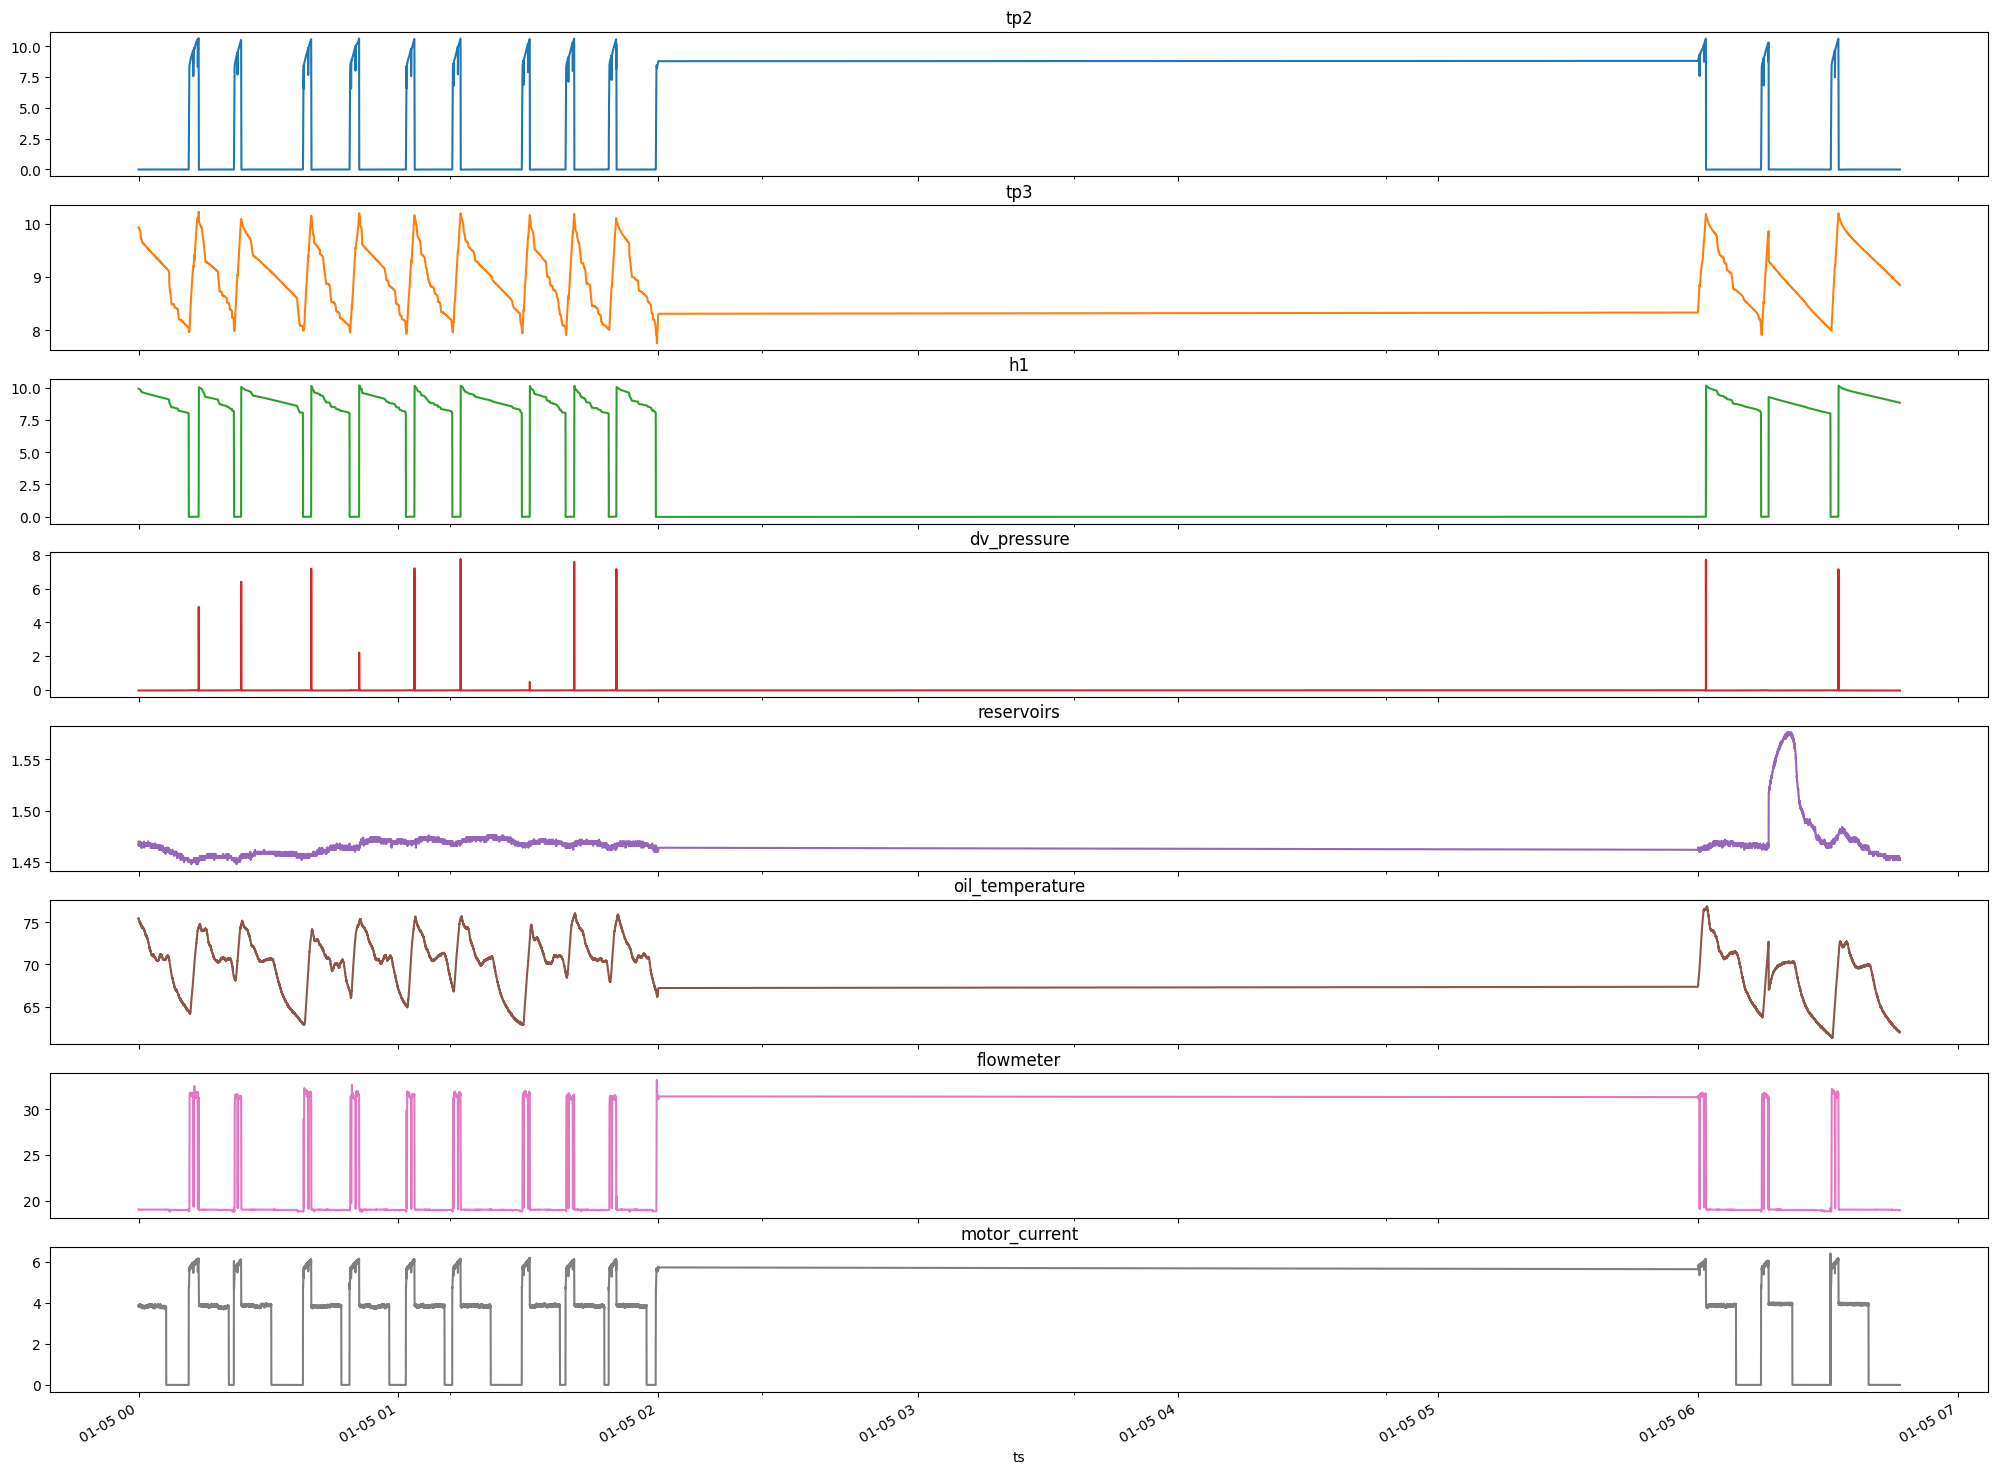

In [37]:
axes = df.head(10000).plot(x='ts', y=analog_cols, subplots=True, figsize=(25, 20), legend=False);

for ax, col in zip(axes, analog_cols):
    ax.set_title(col)

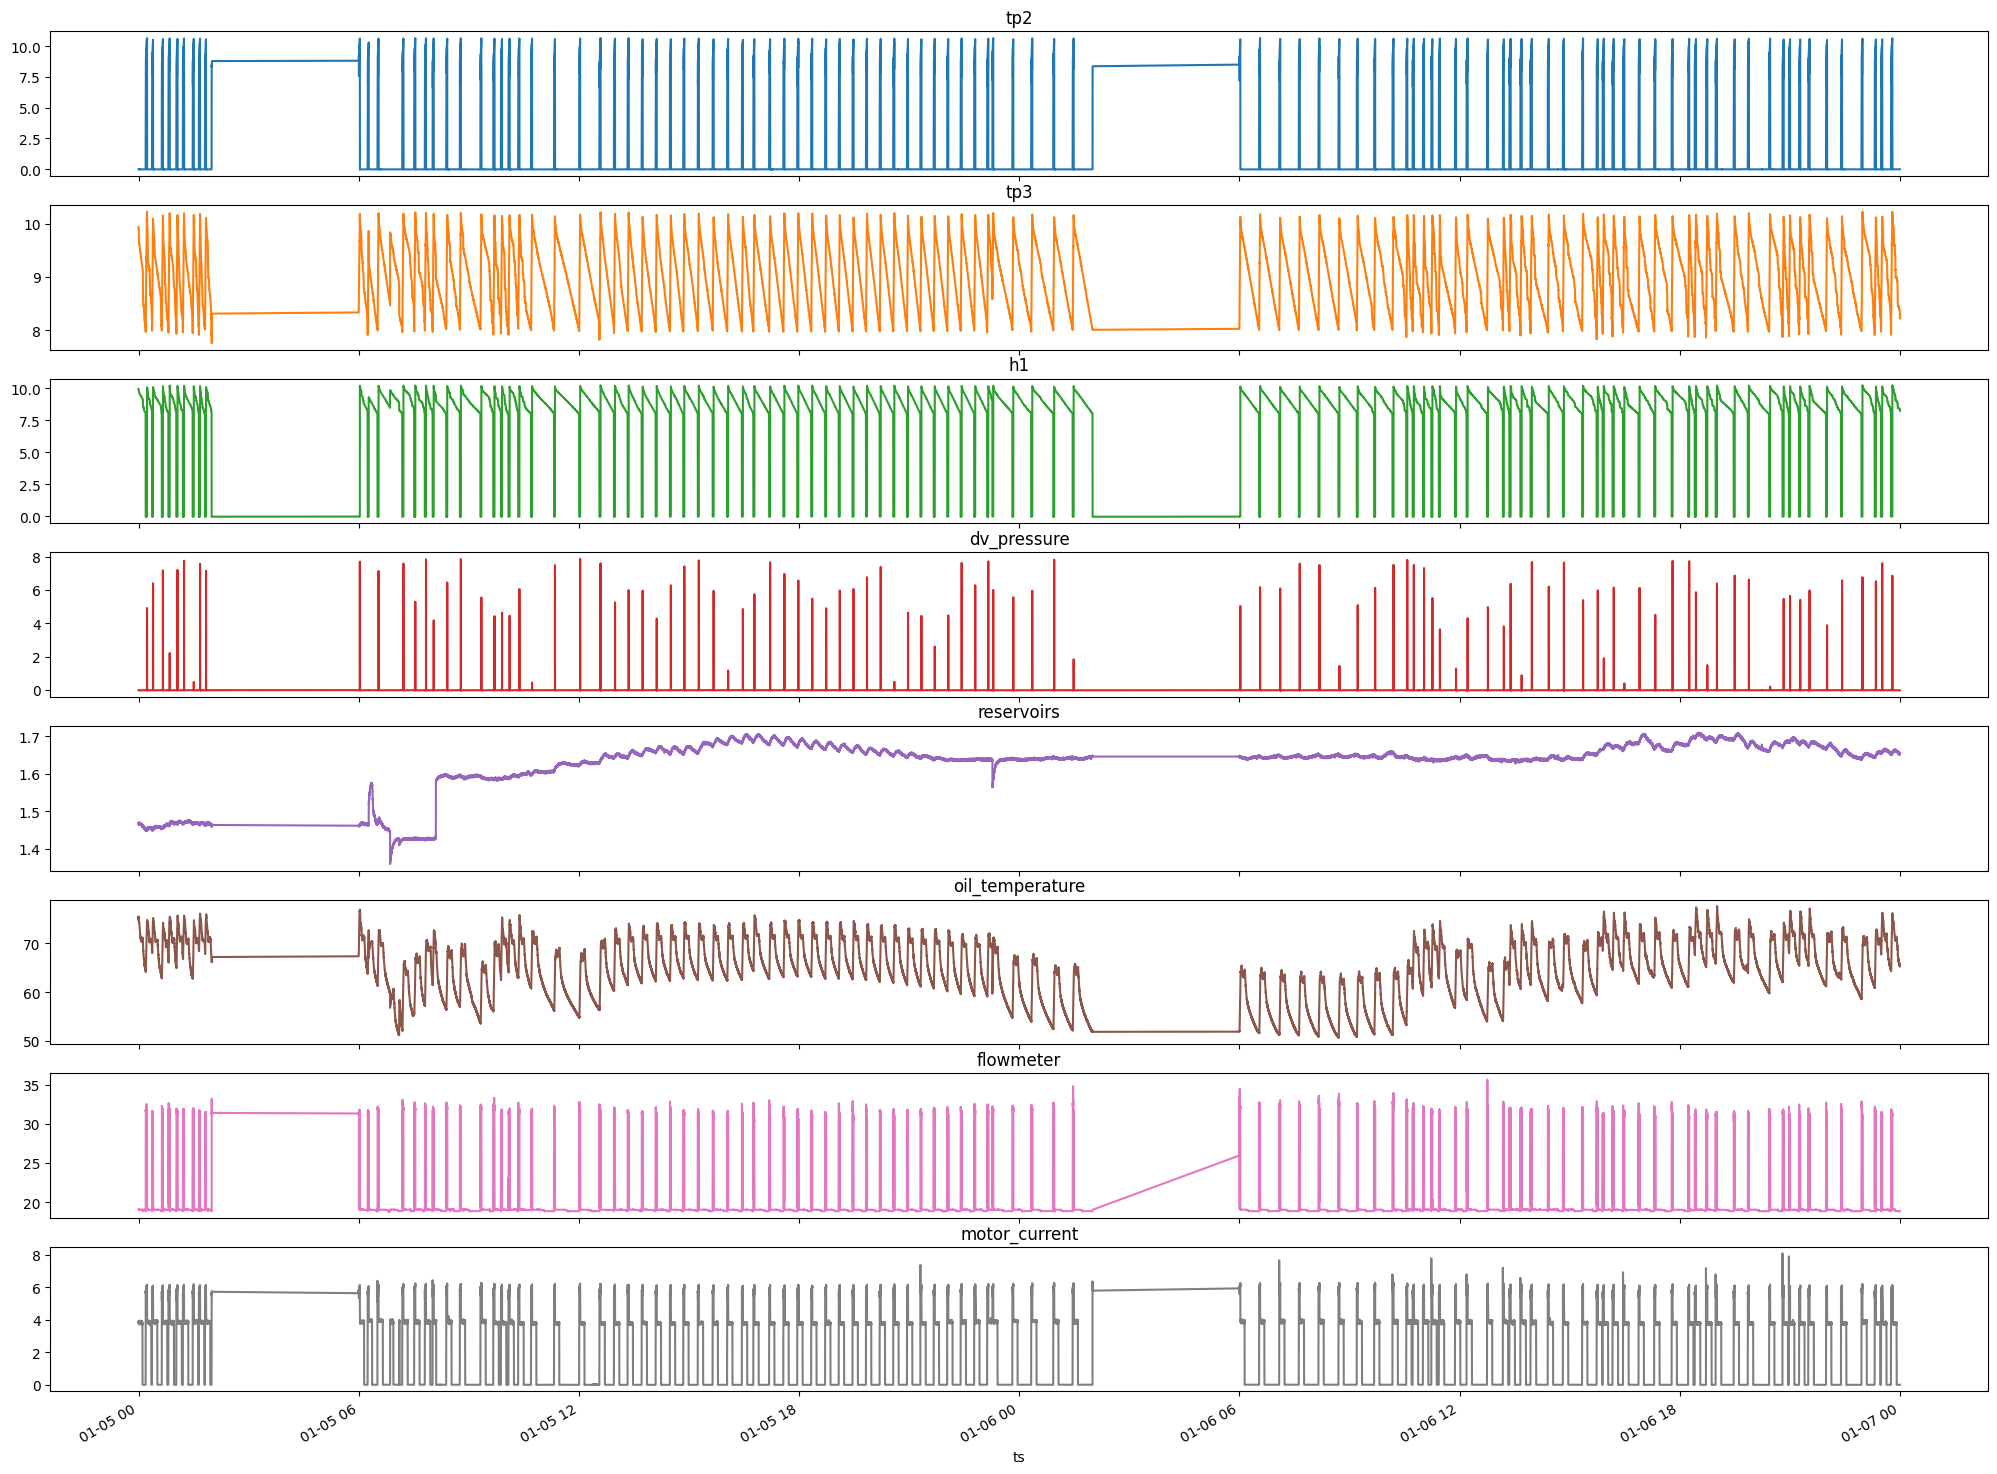

In [38]:
axes = df.plot(x='ts', y=analog_cols, subplots=True, figsize=(25, 20), legend=False);

for ax, col in zip(axes, analog_cols):
    ax.set_title(col)

In [40]:
# Normal Operation Plots - Digital Sensors
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select ts, {columns} 
        from train_data 
        where '2022-01-05' <= date(ts) and date(ts) <= '2022-01-06'
        order by ts asc
    """.format(columns=','.join(digital_cols)), con=con, parse_dates=['ts'])

print(df.shape)

(144002, 9)


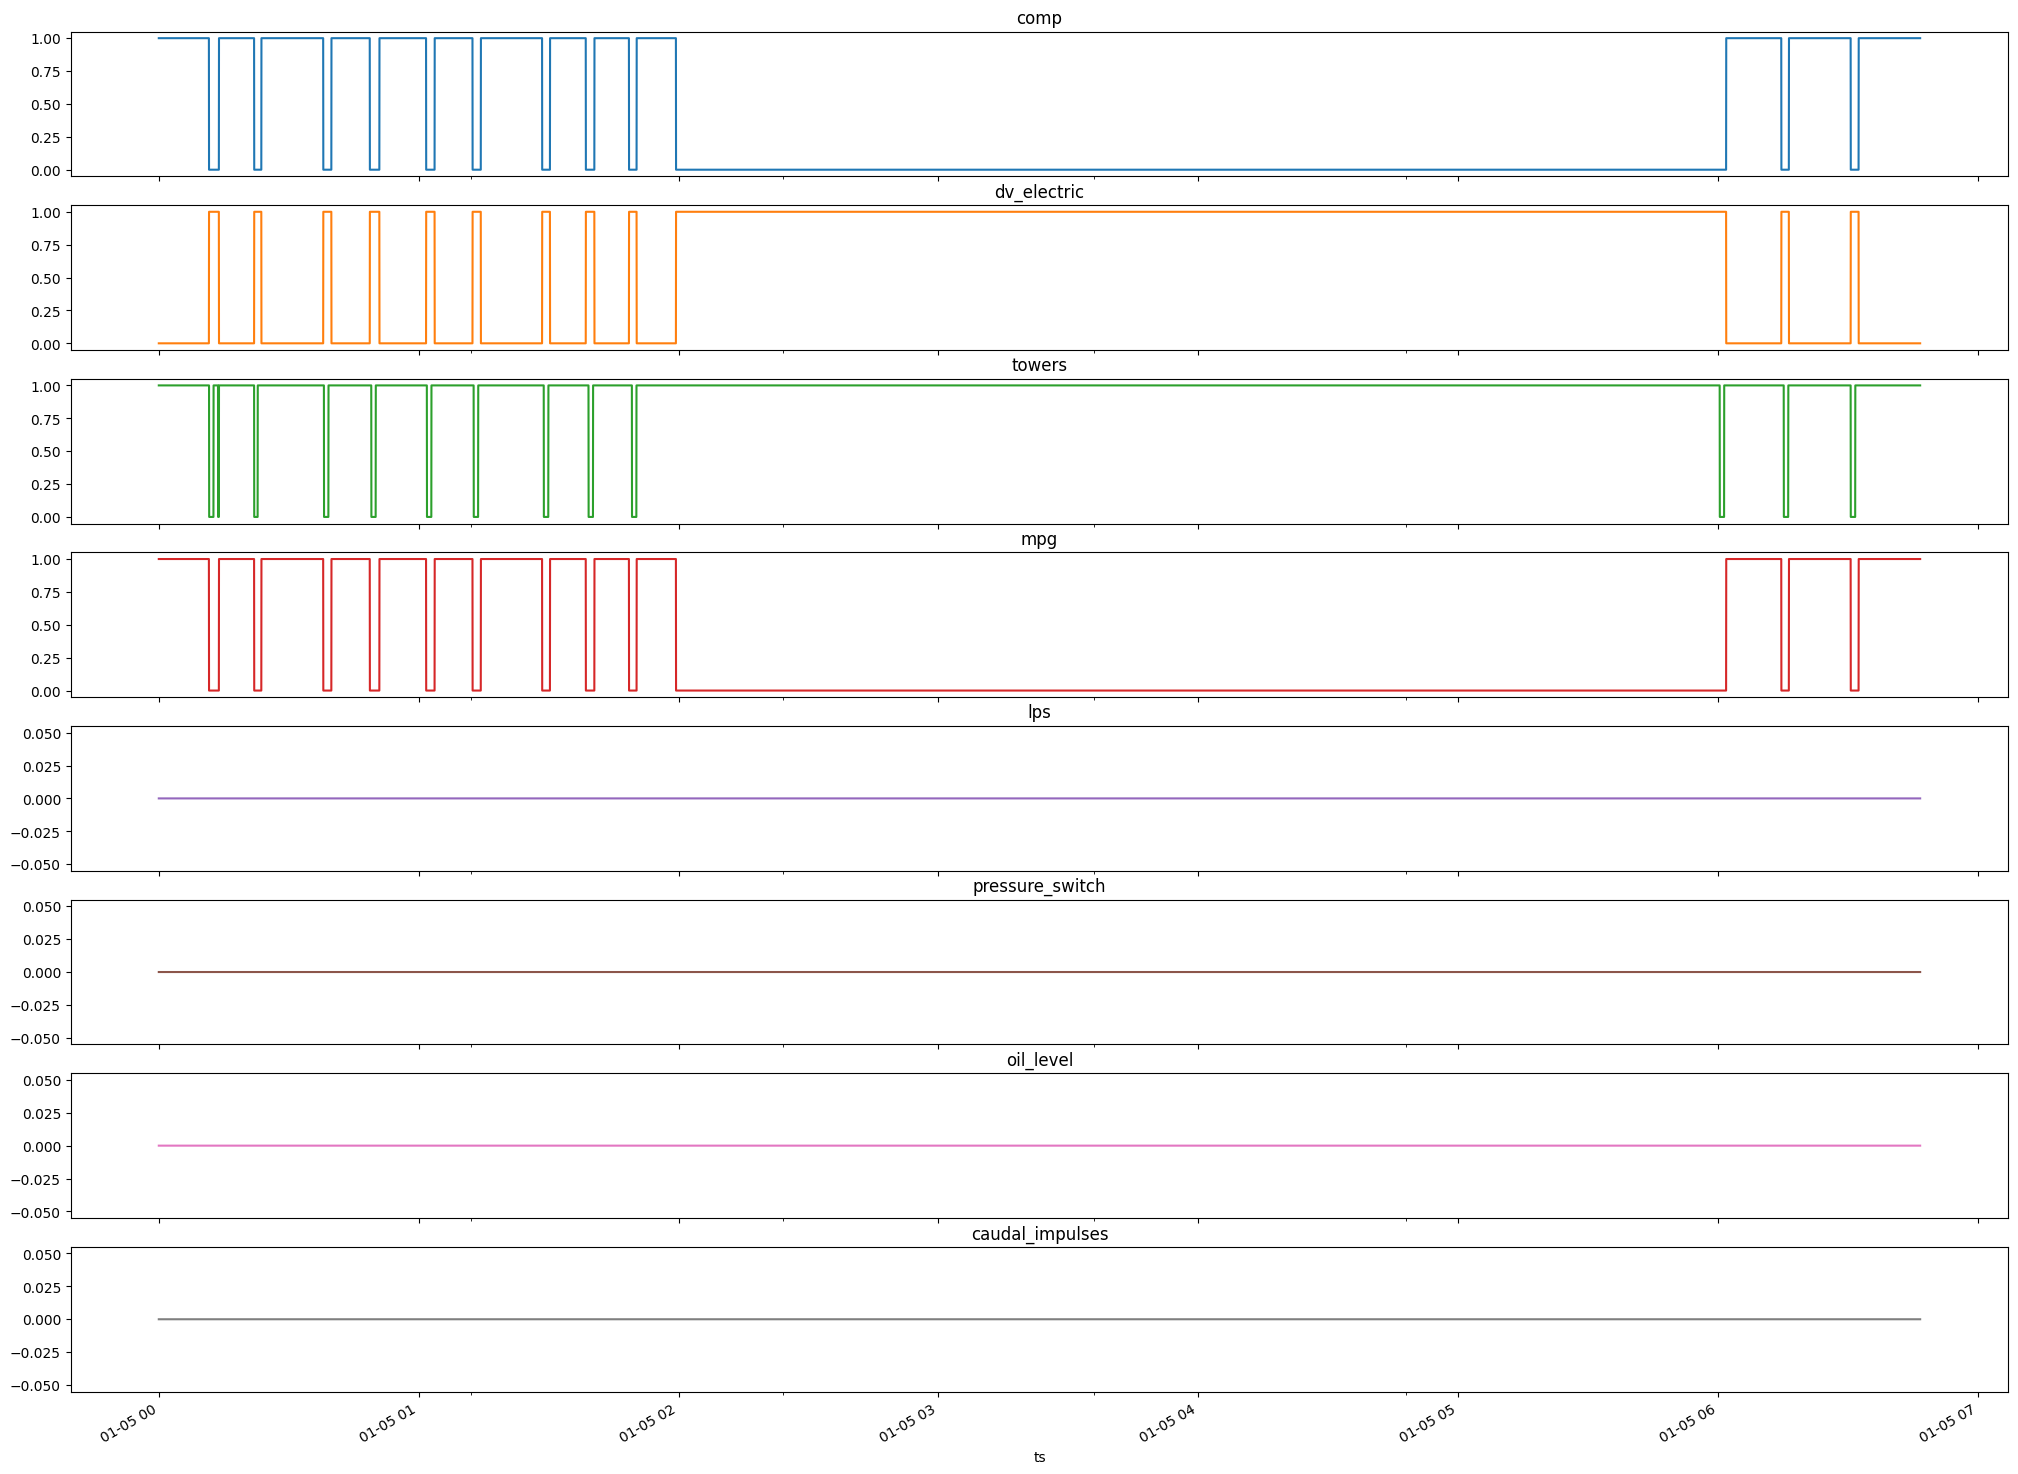

In [ ]:
axes = df.head(10000).plot(x='ts', y=digital_cols, subplots=True, figsize=(25, 20), legend=False);

for ax, col in zip(axes, digital_cols):
    ax.set_title(col)

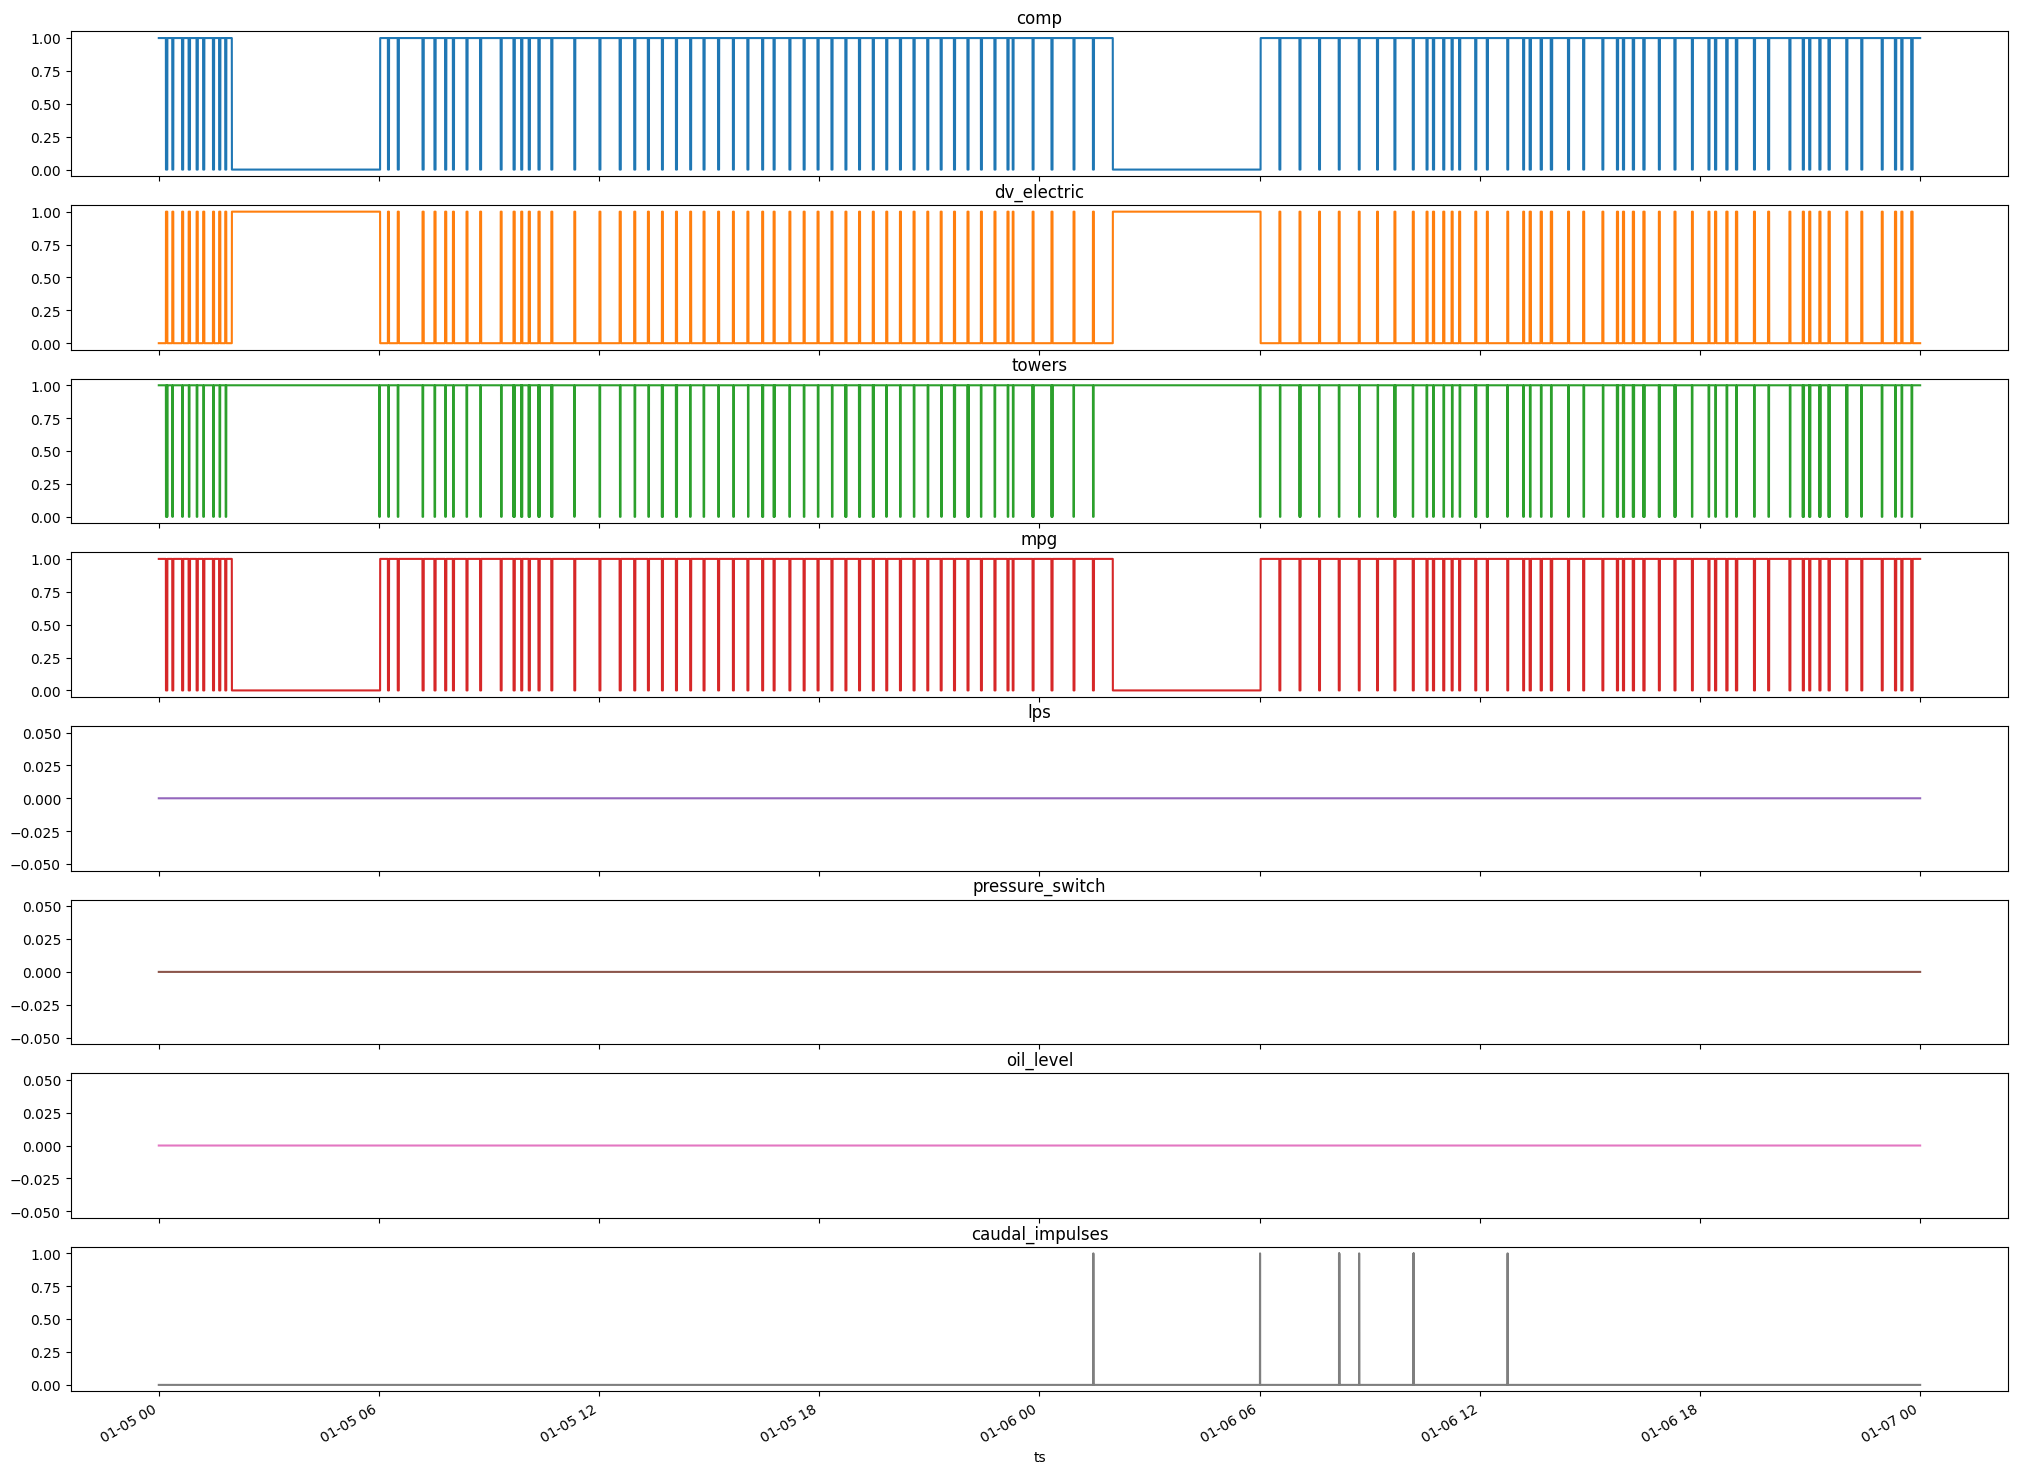

In [43]:
axes = df.plot(x='ts', y=digital_cols, subplots=True, figsize=(25, 20), legend=False);

for ax, col in zip(axes, digital_cols):
    ax.set_title(col)

### Failure 1

In [44]:
# Failure 1 Plots - Analog Sensors
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select ts, failure_id, {columns} 
        from train_data 
        where '2022-02-27 06:00:00' <= ts and ts < '2022-03-01 03:00:00'
        order by ts asc
    """.format(columns=','.join(analog_cols)), con=con, parse_dates=['ts'])

print(df.shape)

df['seconds'] = df['ts'].astype('int64') / 1e9 

(144002, 10)


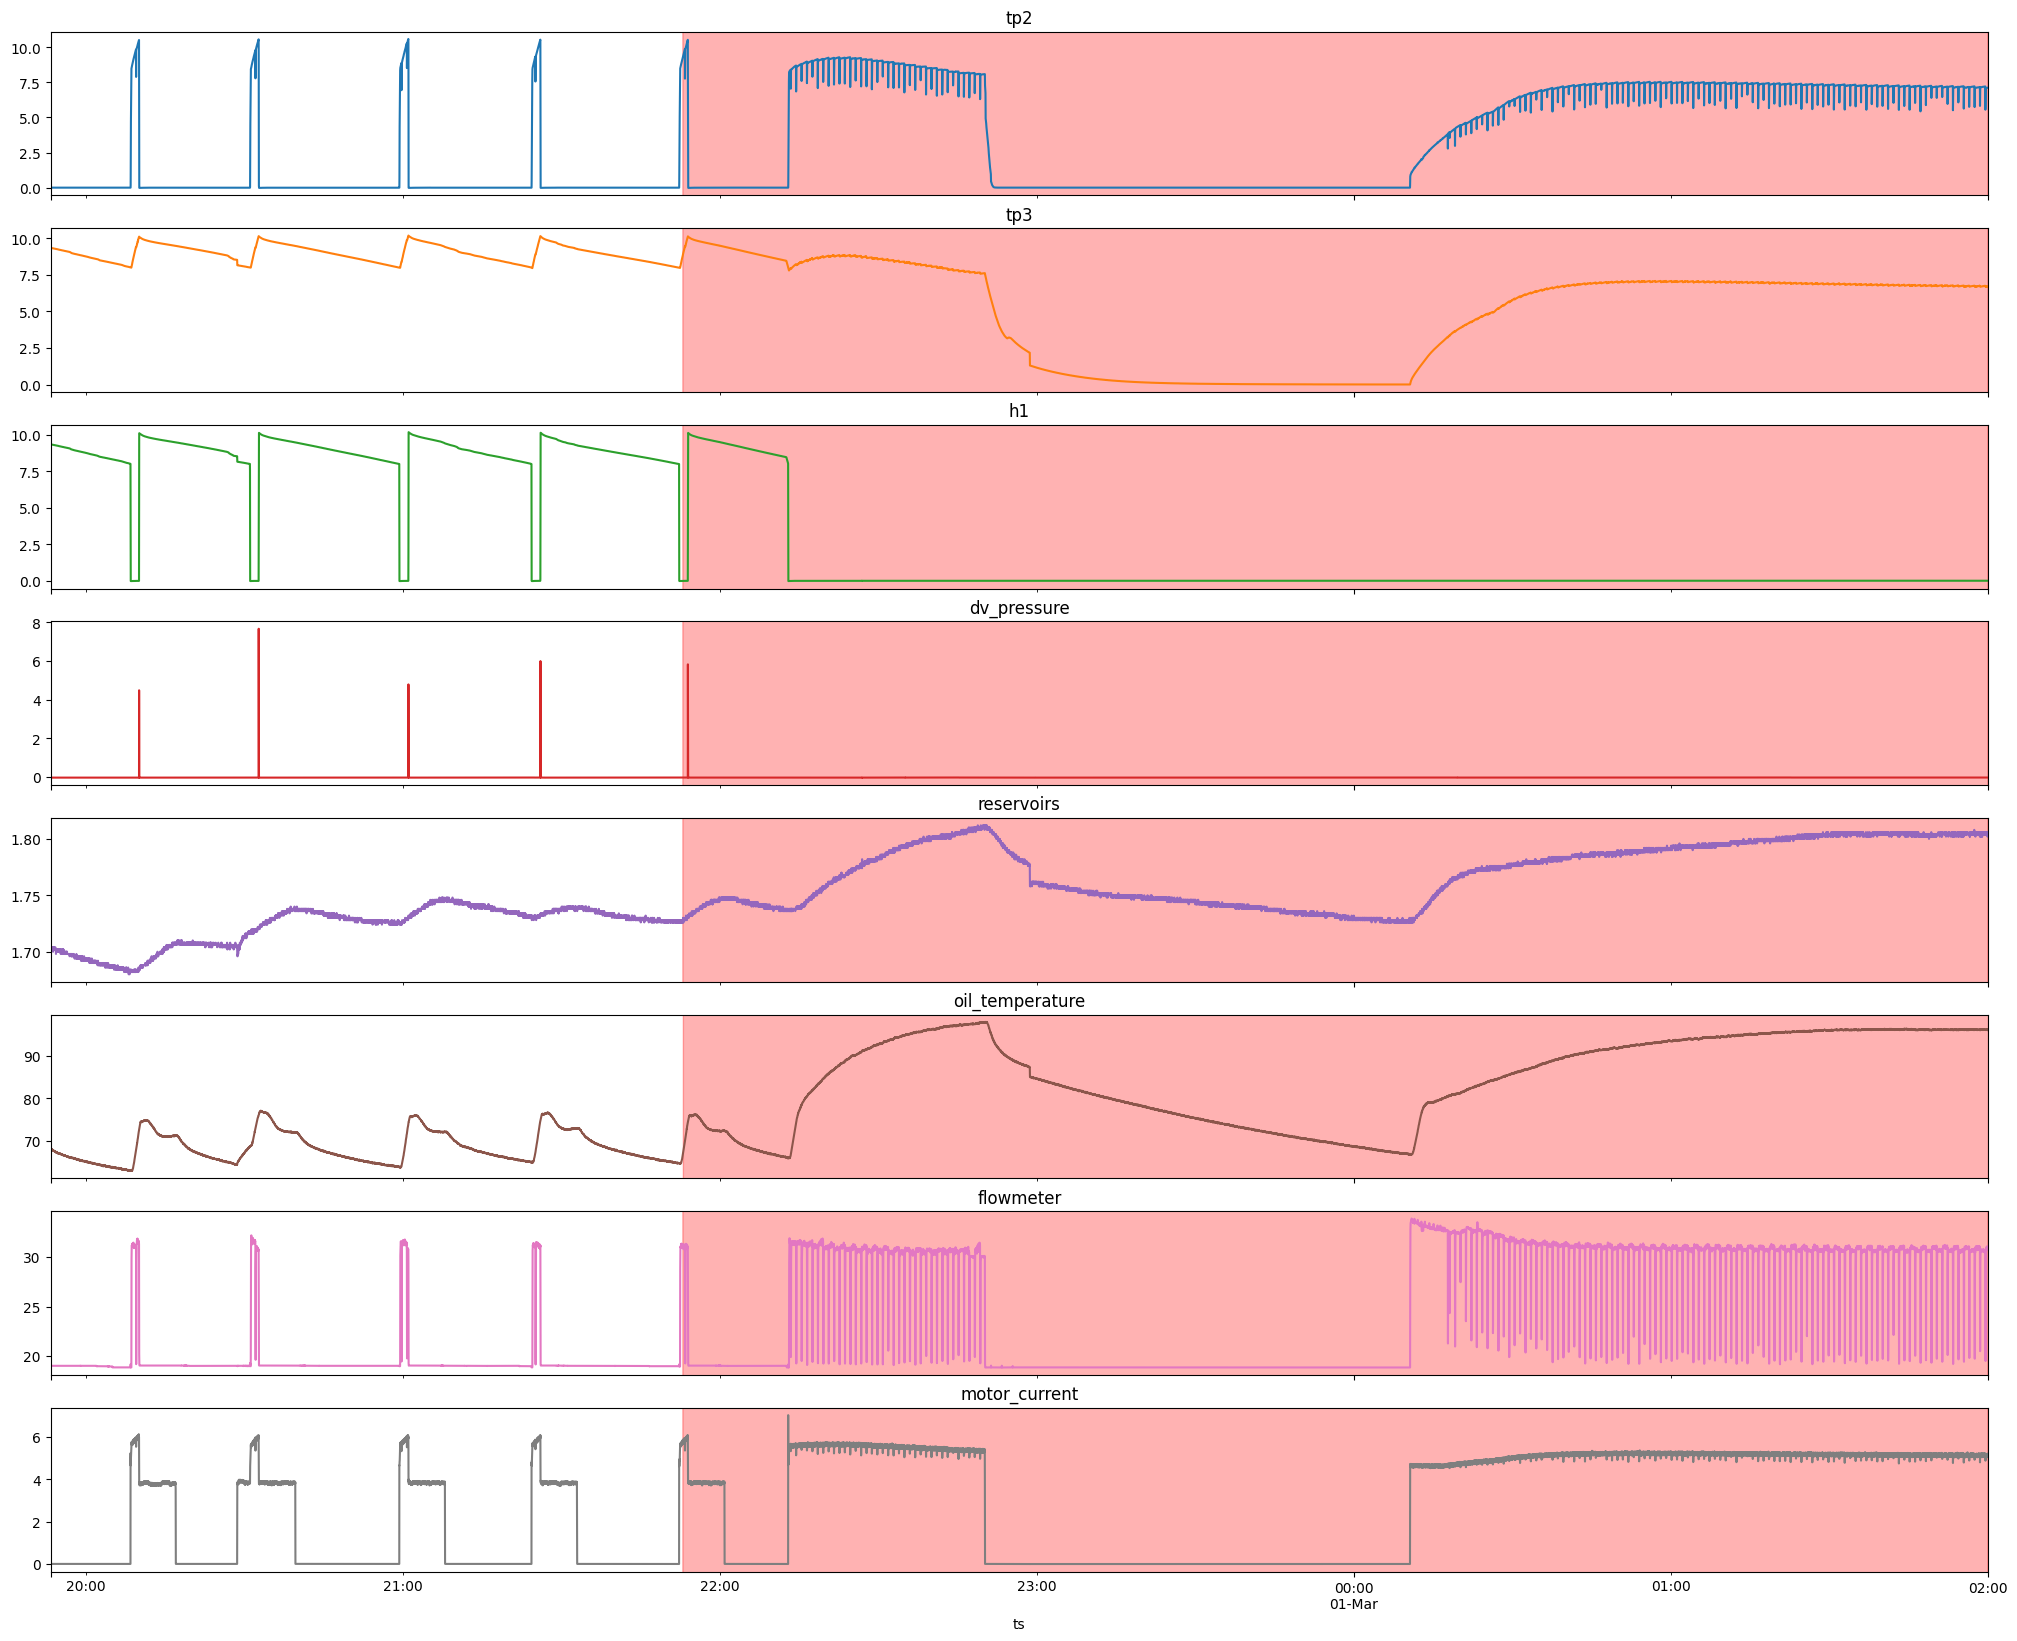

In [66]:
n = 22000

axes = df.tail(n).plot(
    x='ts',
    y=analog_cols,
    subplots=True,
    figsize=(25, 20),
    legend=False
)

for ax, col in zip(axes, analog_cols):
    ax.set_title(col)
    ax.autoscale(False)
    ax.fill_between(
        df['ts'].tail(n).to_list(),
        100,
        -100,
        where=(df['failure_id'].tail(n) == 1).to_list(),
        color='red',
        alpha=0.3
    )

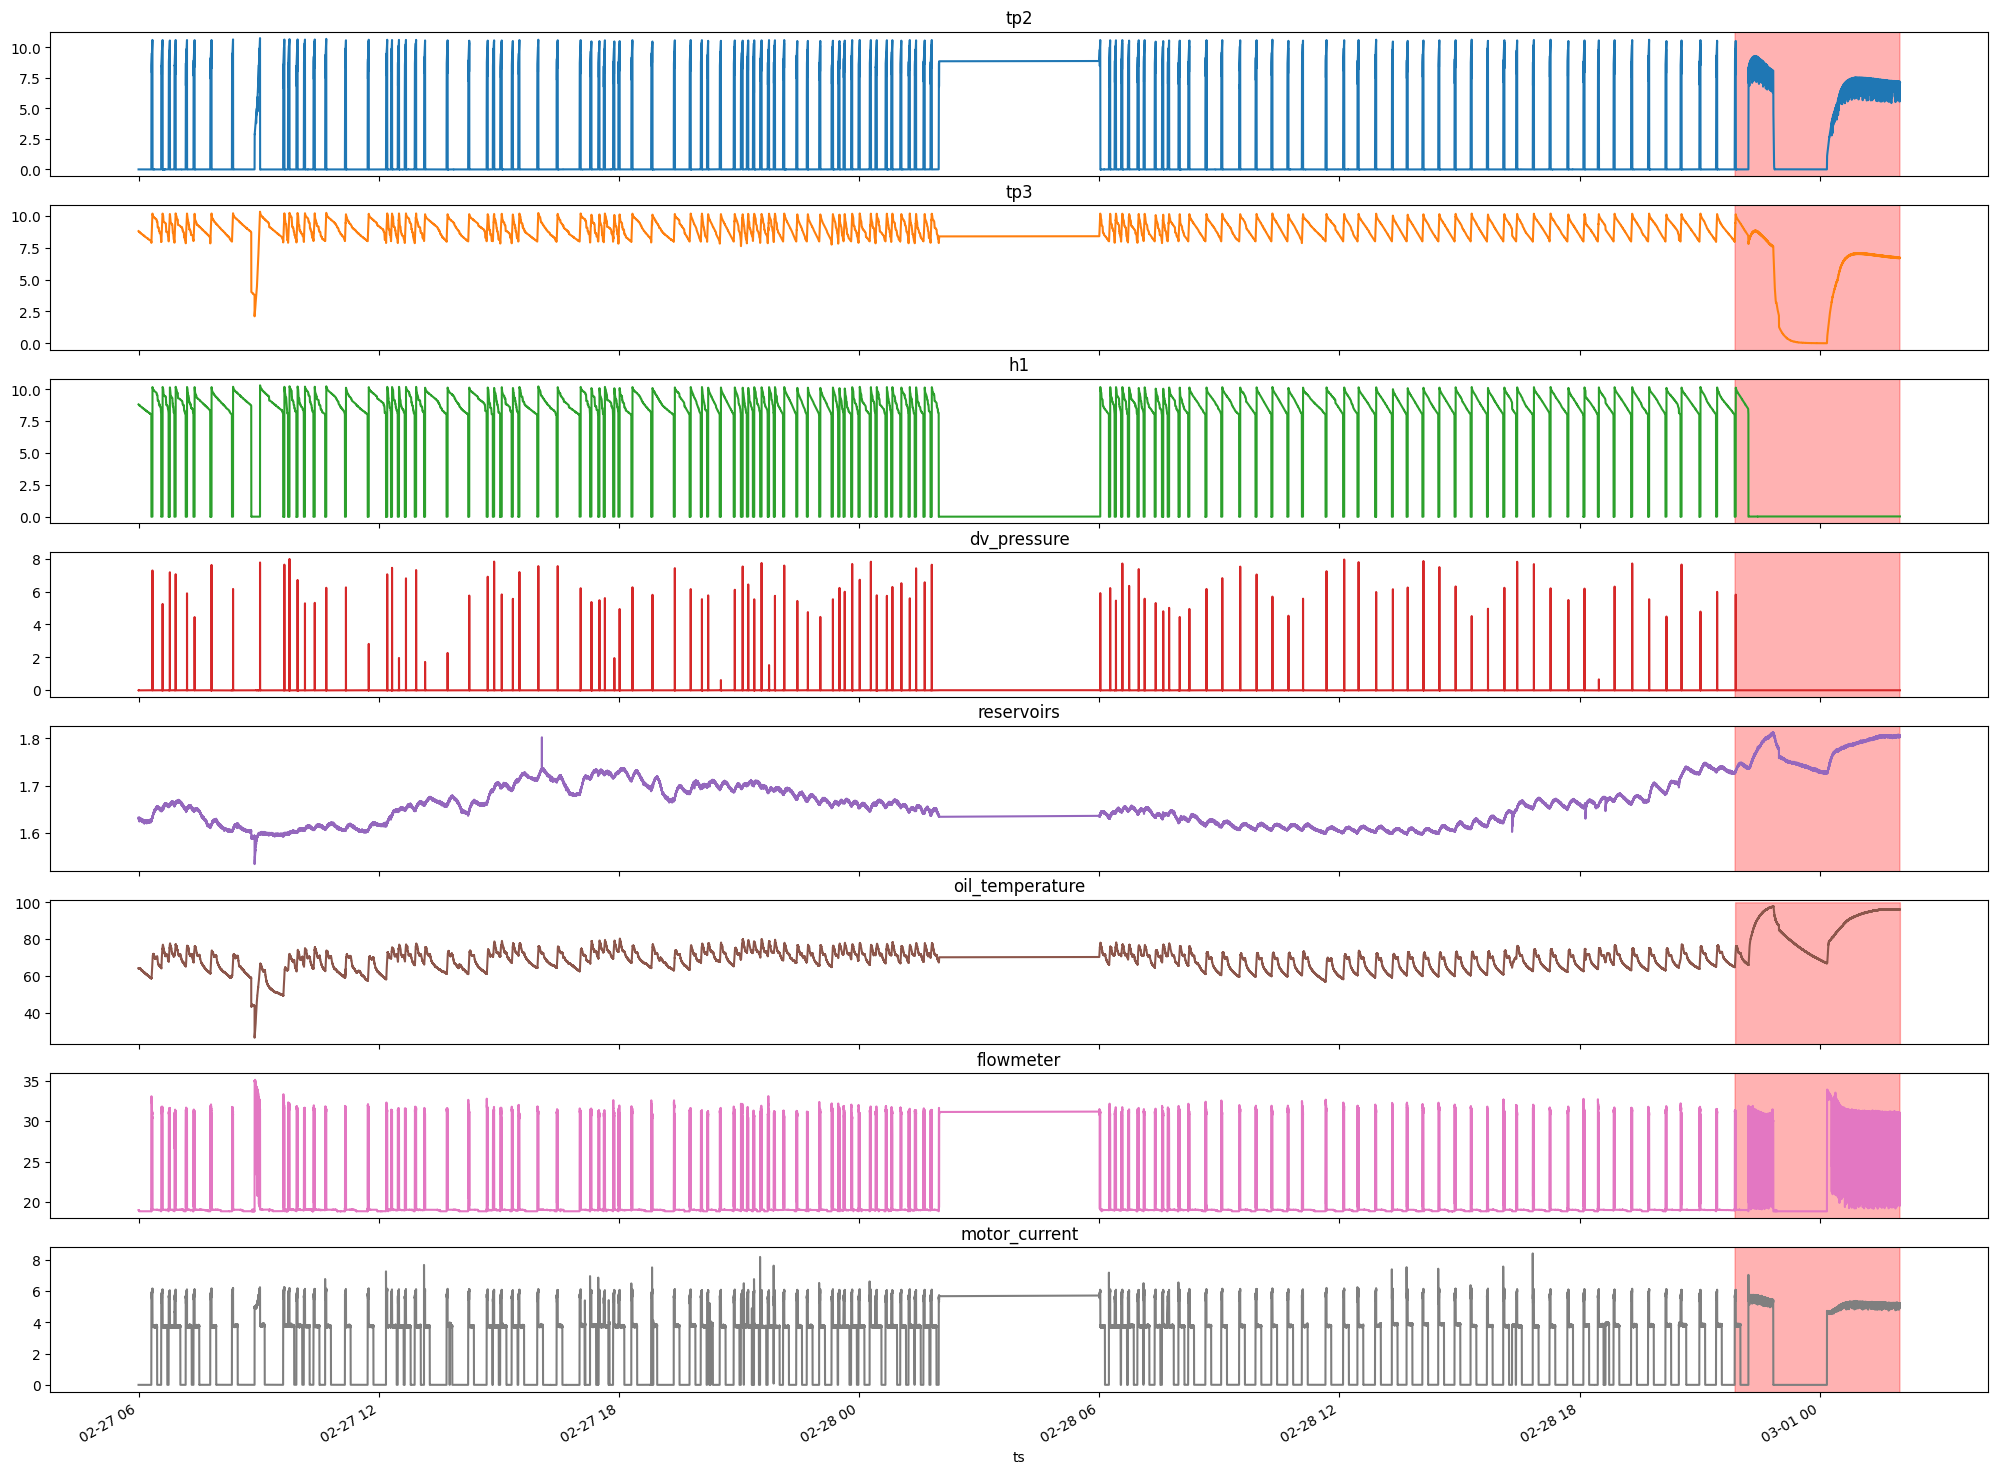

In [67]:
axes = df.plot(
    x='ts',
    y=analog_cols,
    subplots=True,
    figsize=(25, 20),
    legend=False
)

for ax, col in zip(axes, analog_cols):
    ax.set_title(col)
    ax.autoscale(False)
    ax.fill_between(
        df['ts'].to_list(),
        100,
        -100,
        where=(df['failure_id'] == 1).to_list(),
        color='red',
        alpha=0.3
    )

In [75]:
# Failure 1 Plots - Digital Sensors
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select ts, failure_id, {columns} 
        from train_data 
        where '2022-02-27 06:00:00' <= ts and ts < '2022-03-01 03:00:00'
        order by ts asc
    """.format(columns=','.join(digital_cols)), con=con, parse_dates=['ts'])

print(df.shape)

(144002, 10)


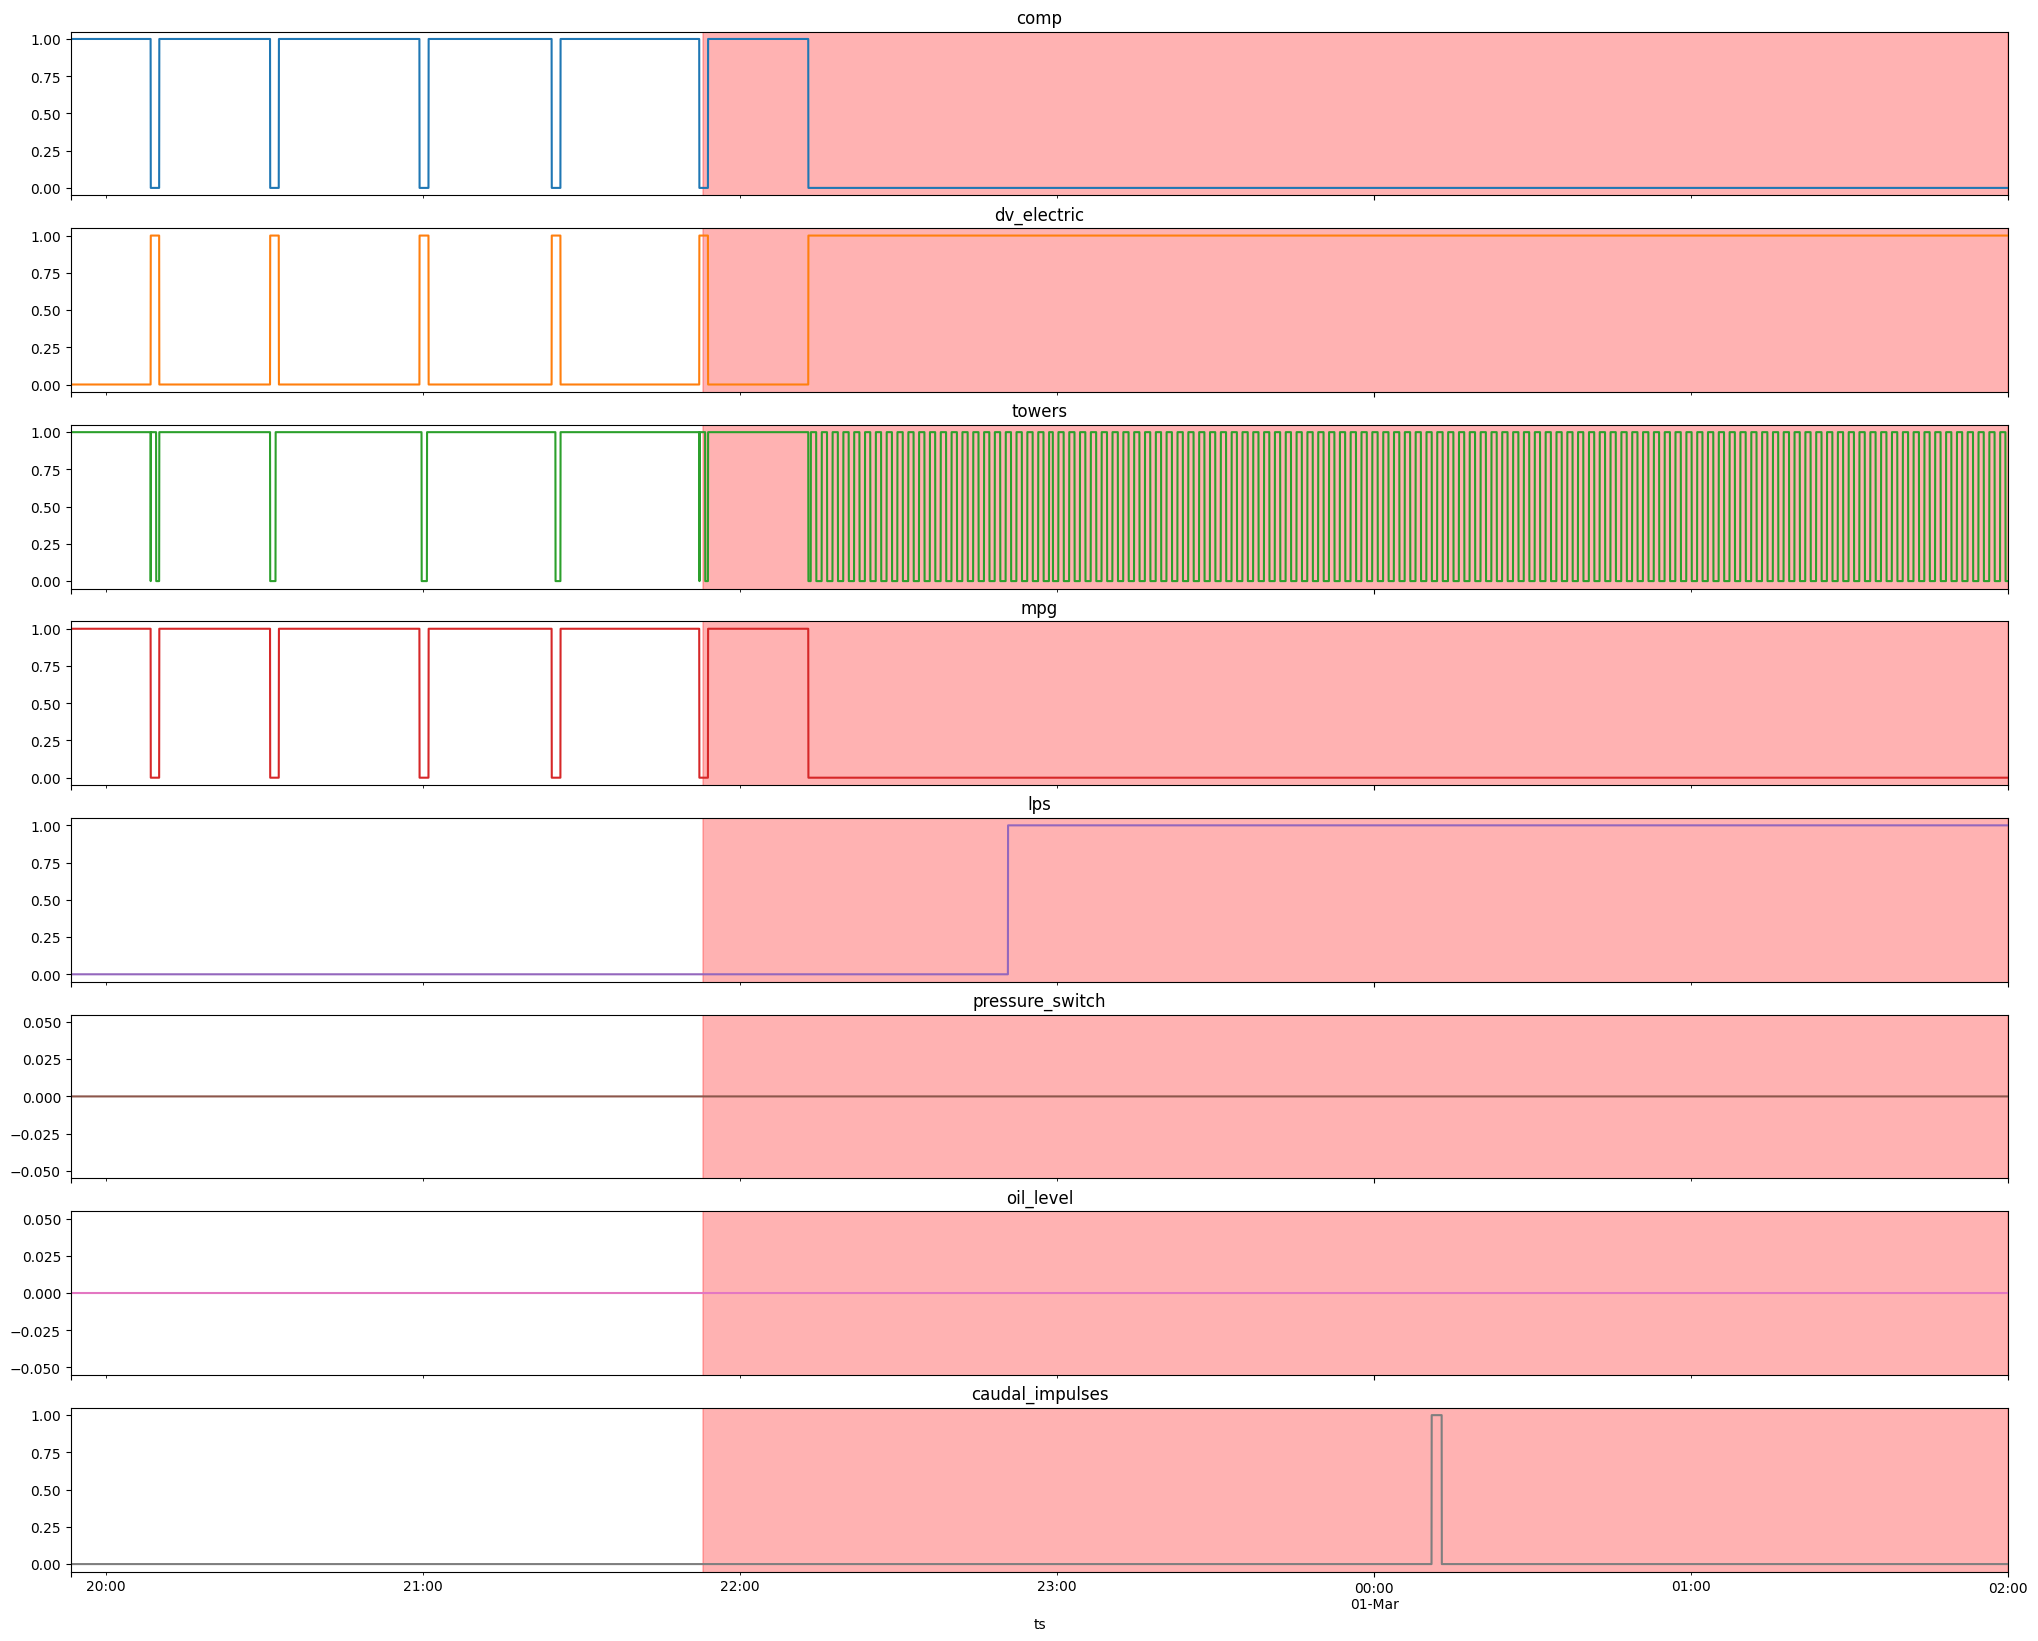

In [76]:
n = 22000

axes = df.tail(n).plot(
    x='ts',
    y=digital_cols,
    subplots=True,
    figsize=(25, 20),
    legend=False
)

for ax, col in zip(axes, digital_cols):
    ax.set_title(col)
    ax.autoscale(False)
    ax.fill_between(
        df['ts'].tail(n).to_list(),
        100,
        -100,
        where=(df['failure_id'].tail(n) == 1).to_list(),
        color='red',
        alpha=0.3
    )

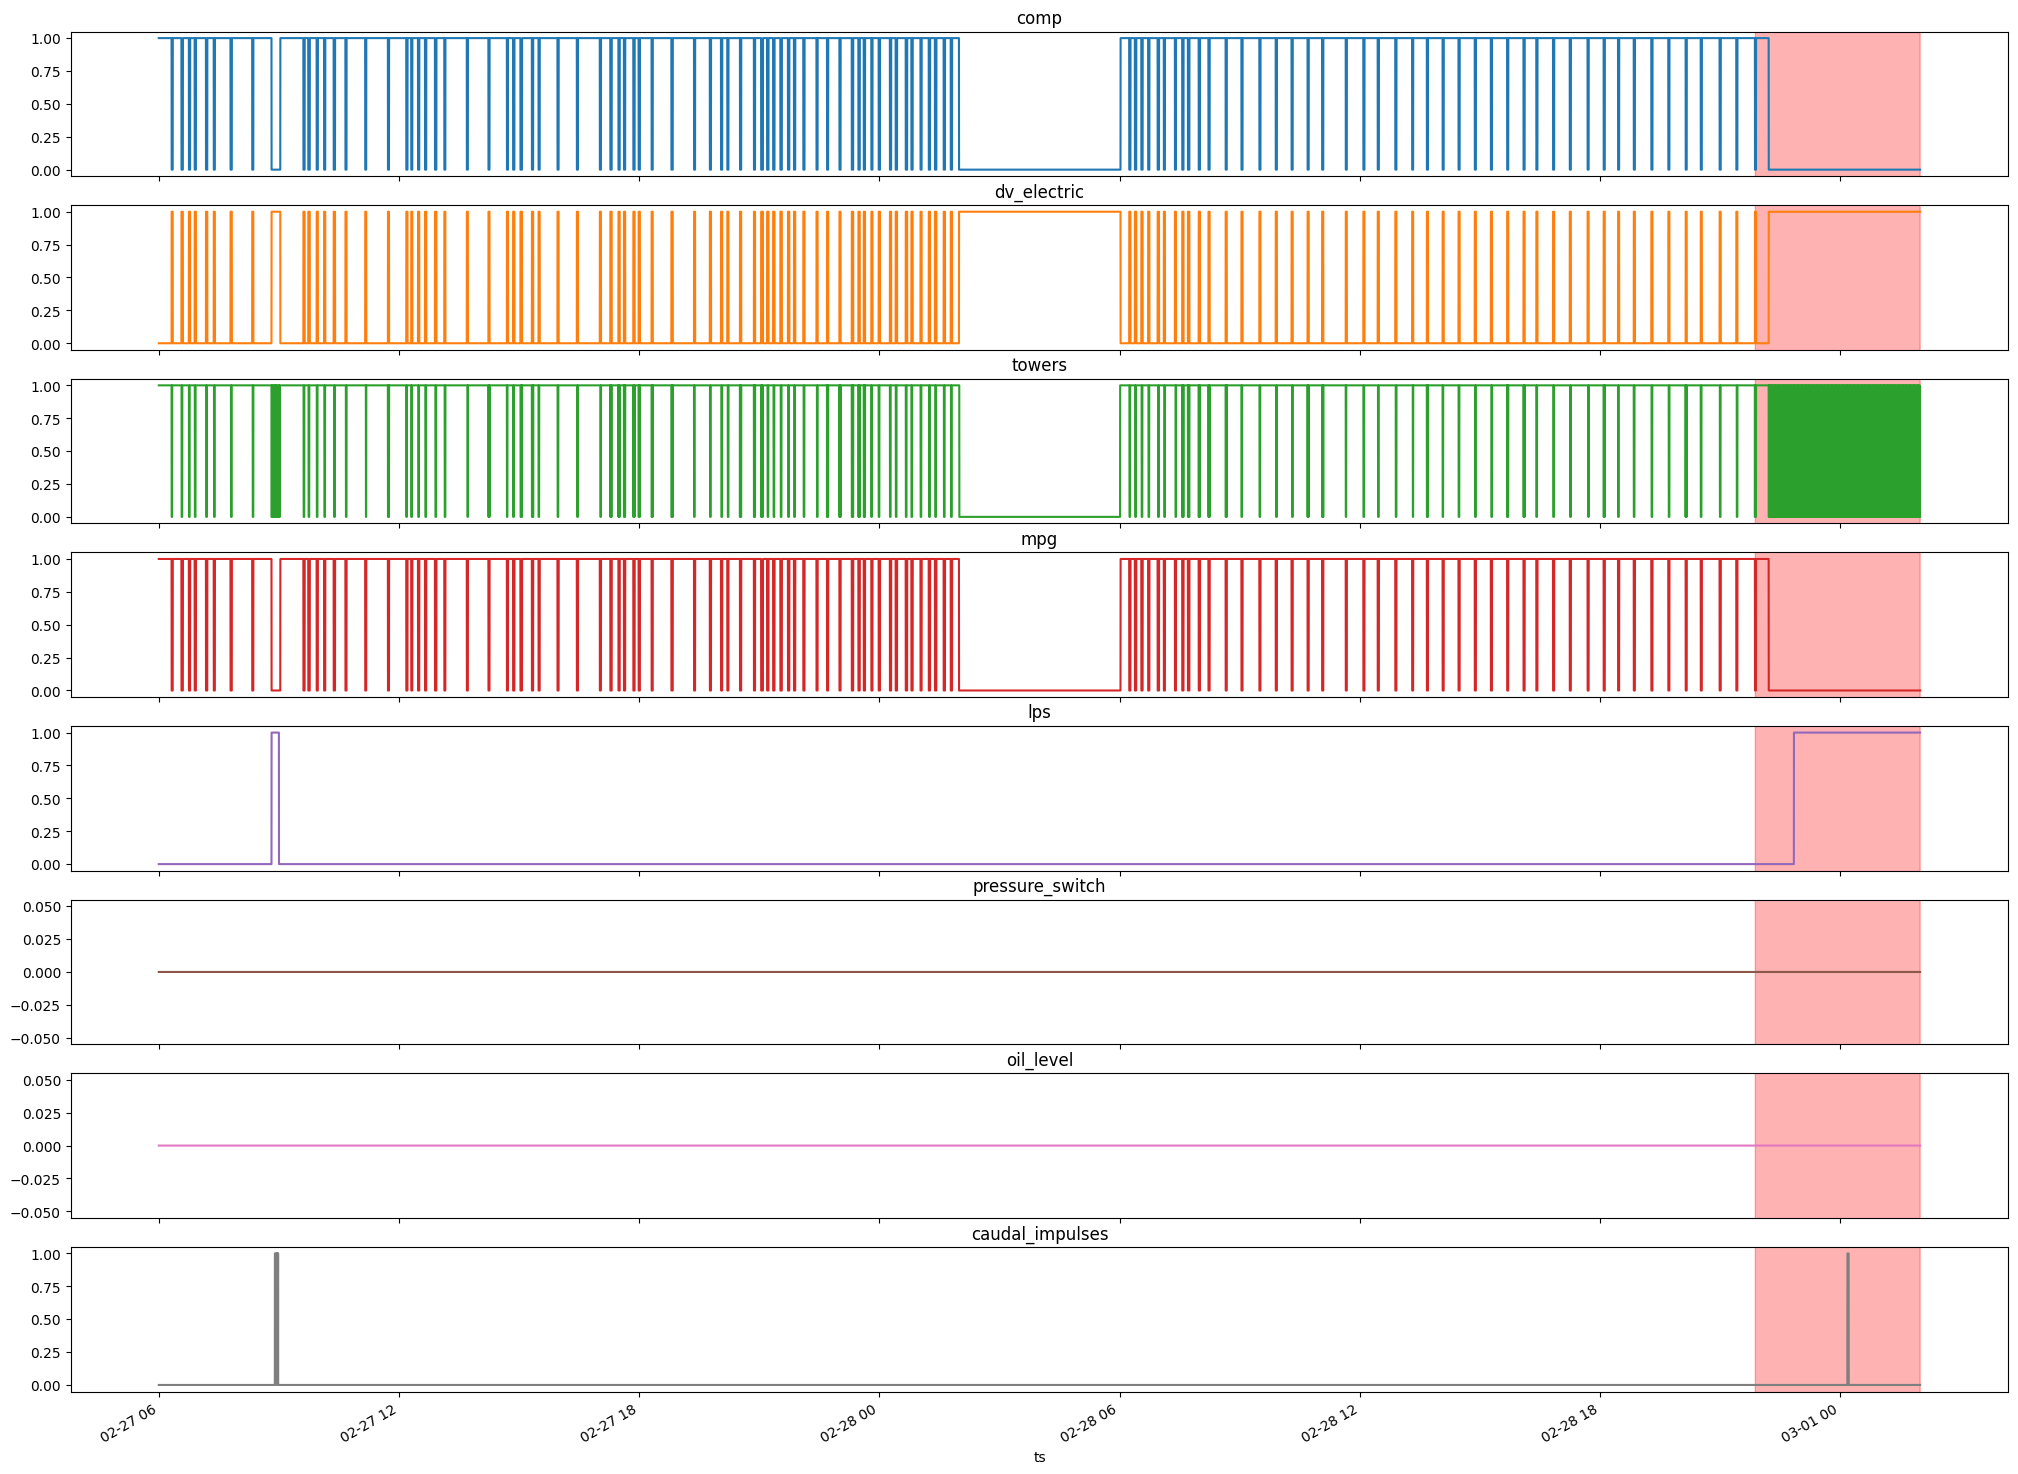

In [77]:
axes = df.plot(
    x='ts',
    y=digital_cols,
    subplots=True,
    figsize=(25, 20),
    legend=False
)

for ax, col in zip(axes, digital_cols):
    ax.set_title(col)
    ax.autoscale(False)
    ax.fill_between(
        df['ts'].to_list(),
        100,
        -100,
        where=(df['failure_id'] == 1).to_list(),
        color='red',
        alpha=0.3
    )

### Failure 2

In [79]:
# Failure 2 Plots - Analog Sensors
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select ts, failure_id, {columns} 
        from train_data 
        where '2022-03-21 06:00:00' <= ts and ts < '2022-03-23 16:00:00'
        order by ts asc
    """.format(columns=','.join(analog_cols)), con=con, parse_dates=['ts'])

print(df.shape)

(180002, 10)


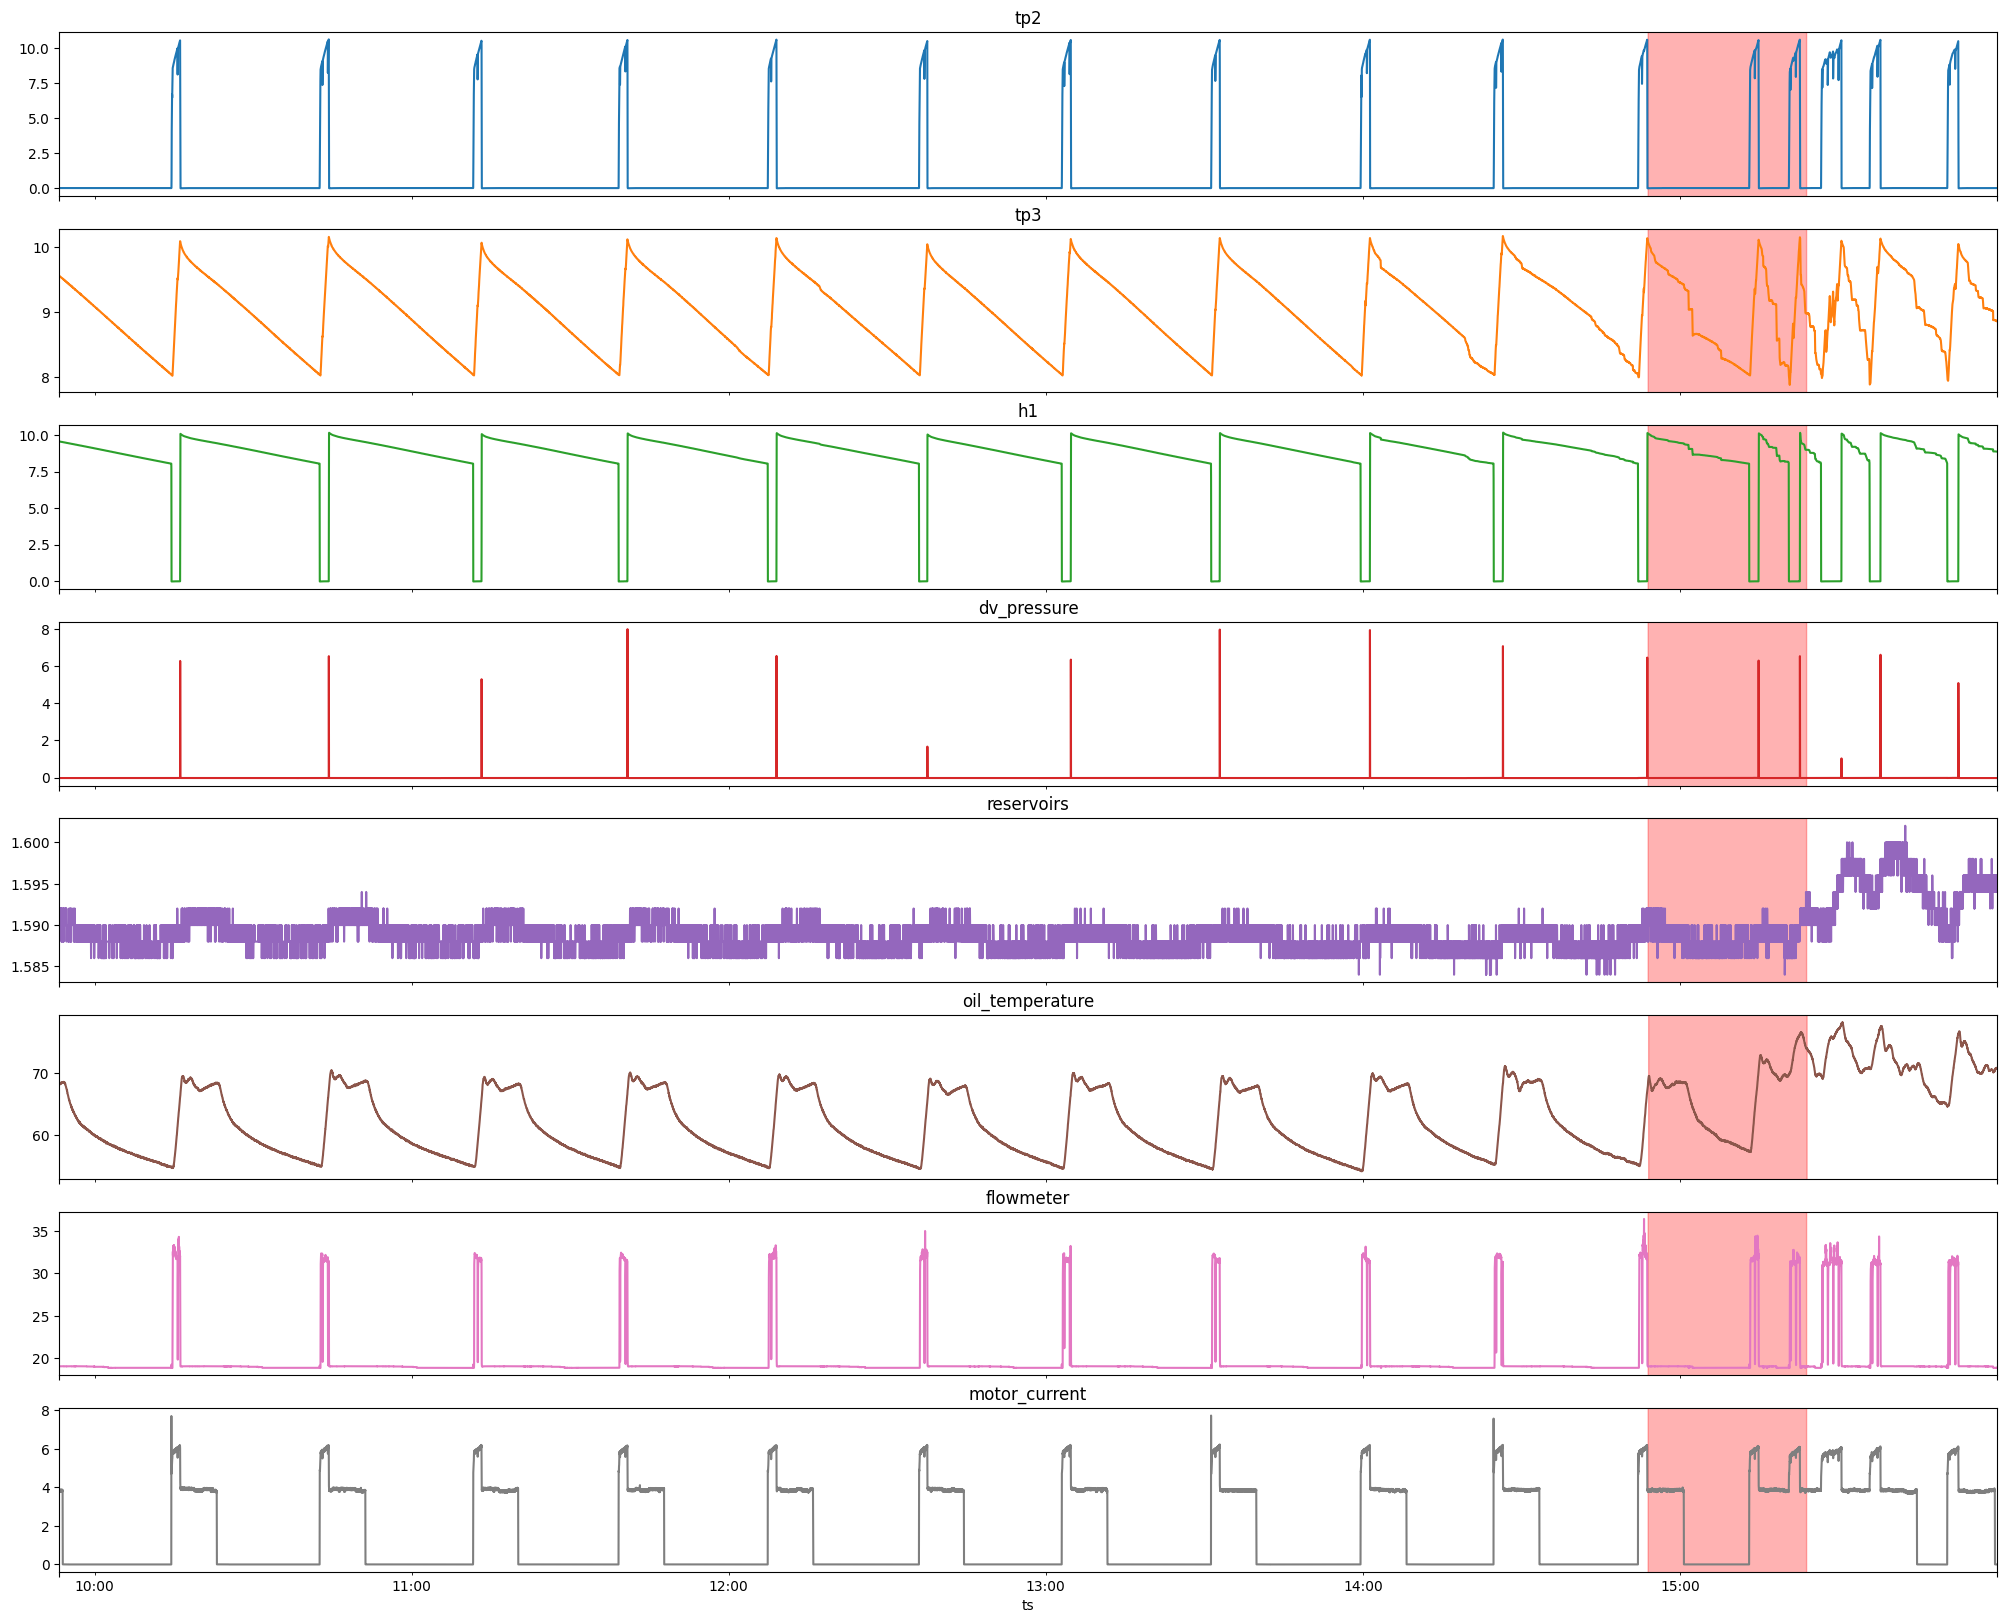

In [80]:
n = 22000

axes = df.tail(n).plot(
    x='ts',
    y=analog_cols,
    subplots=True,
    figsize=(25, 20),
    legend=False
)

for ax, col in zip(axes, analog_cols):
    ax.set_title(col)
    ax.autoscale(False)
    ax.fill_between(
        df['ts'].tail(n).to_list(),
        100,
        -100,
        where=(df['failure_id'] == 2).tail(n).to_list(),
        color='red',
        alpha=0.3
    )

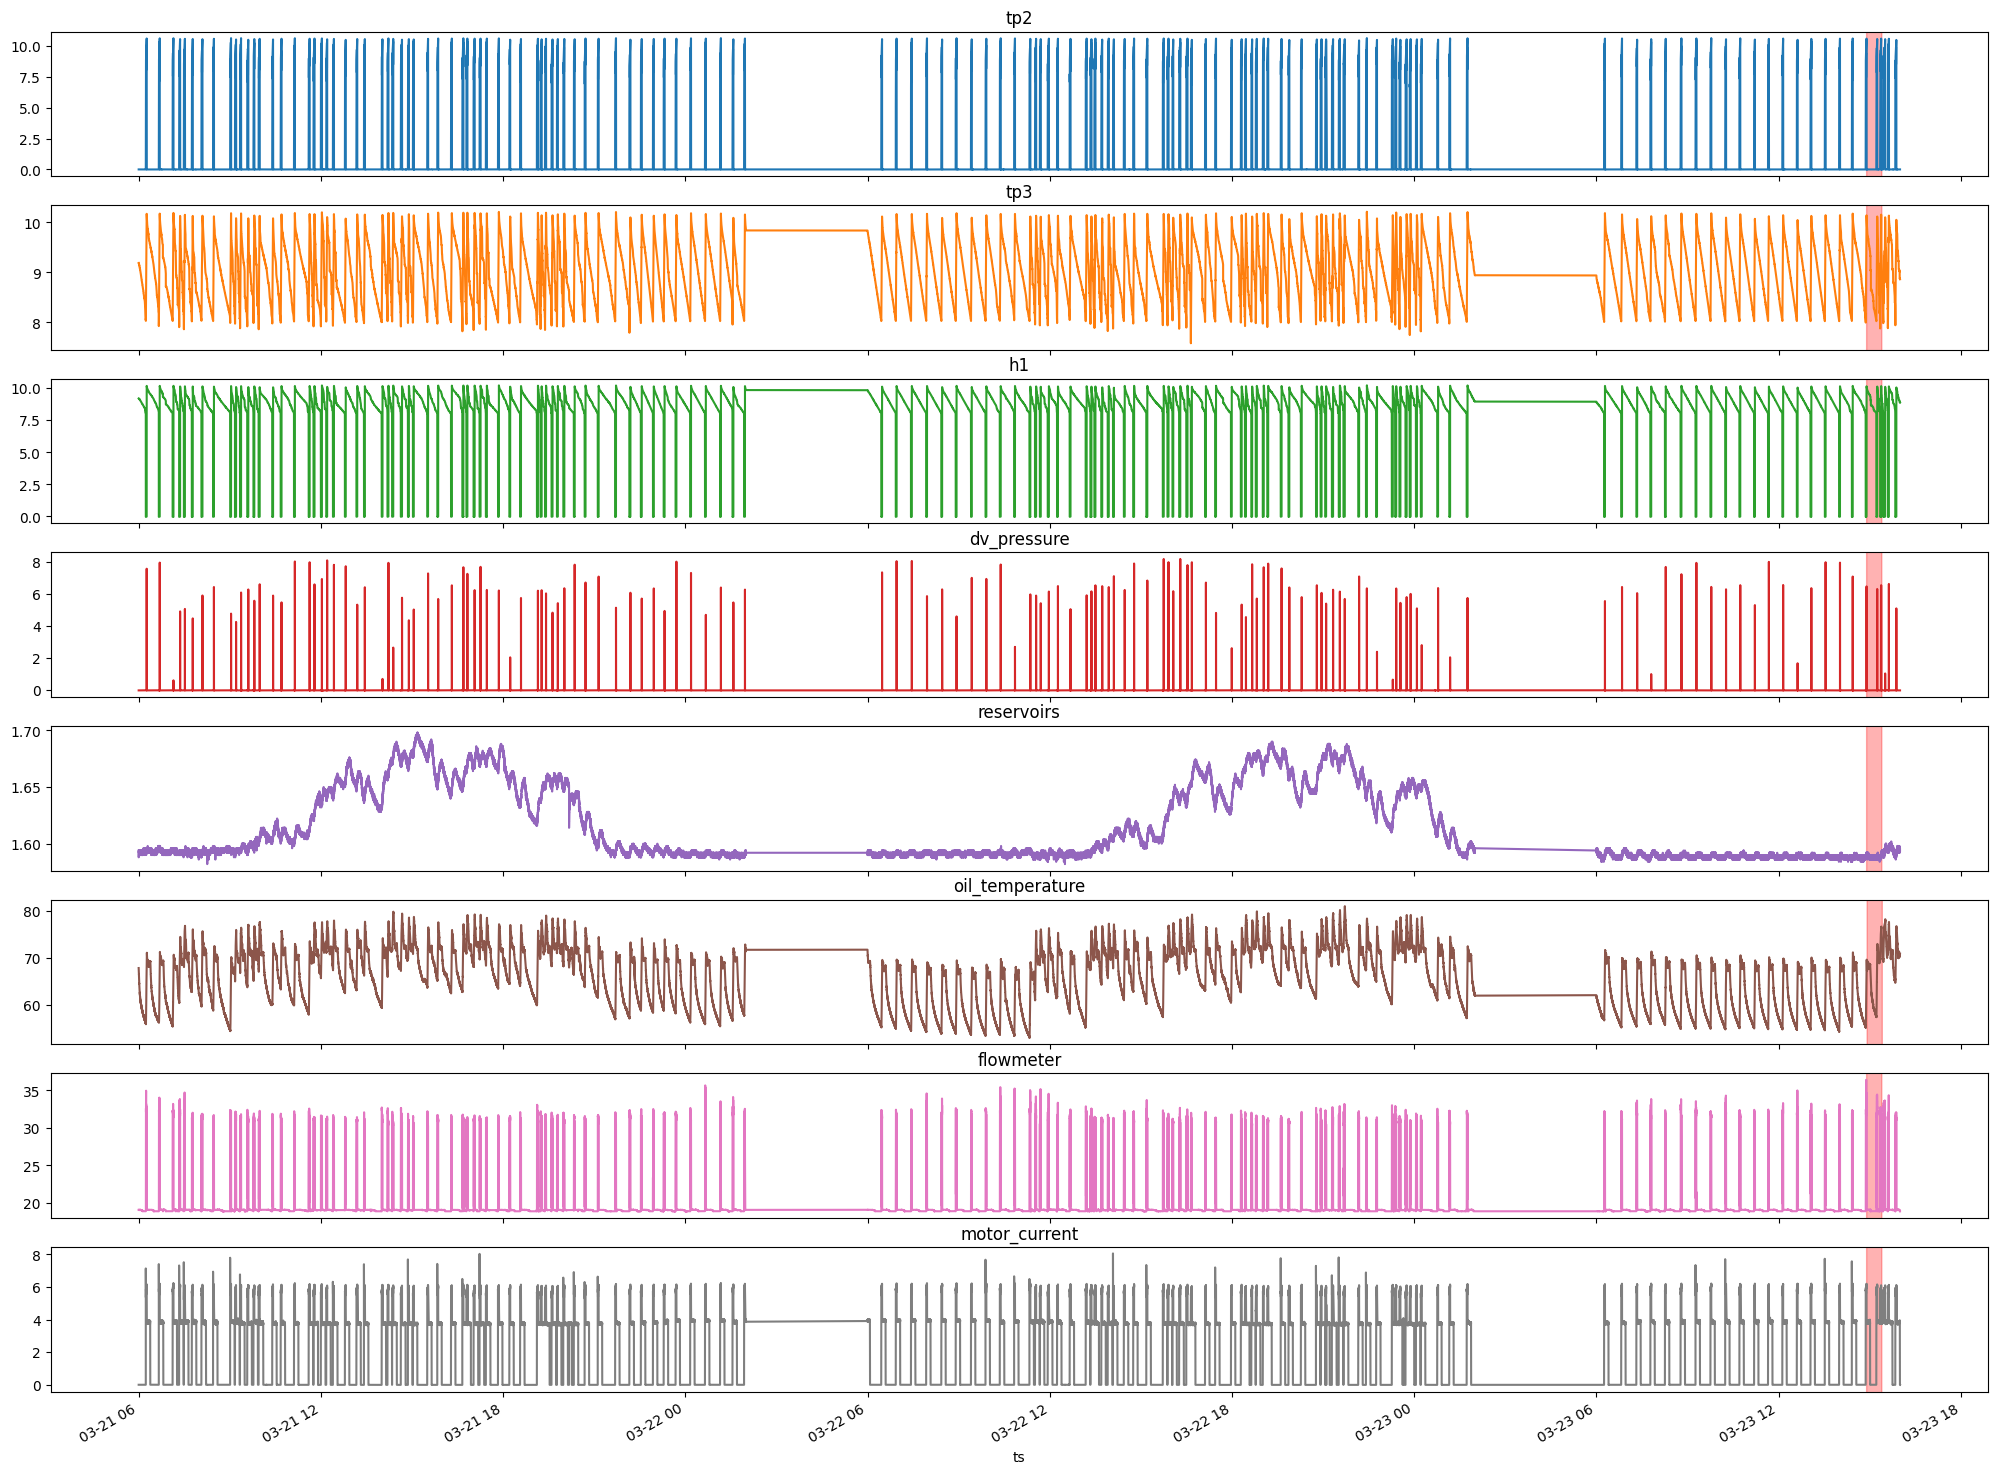

In [81]:
axes = df.plot(
    x='ts',
    y=analog_cols,
    subplots=True,
    figsize=(25, 20),
    legend=False
)

for ax, col in zip(axes, analog_cols):
    ax.set_title(col)
    ax.autoscale(False)
    ax.fill_between(
        df['ts'].to_list(),
        100,
        -100,
        where=(df['failure_id'] == 2).to_list(),
        color='red',
        alpha=0.3
    )

In [83]:
# Failure 2 Plots - Digital Sensors
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select ts, failure_id, {columns} 
        from train_data 
        where '2022-03-21 06:00:00' <= ts and ts < '2022-03-23 16:00:00'
        order by ts asc
    """.format(columns=','.join(digital_cols)), con=con, parse_dates=['ts'])

print(df.shape)

(180002, 10)


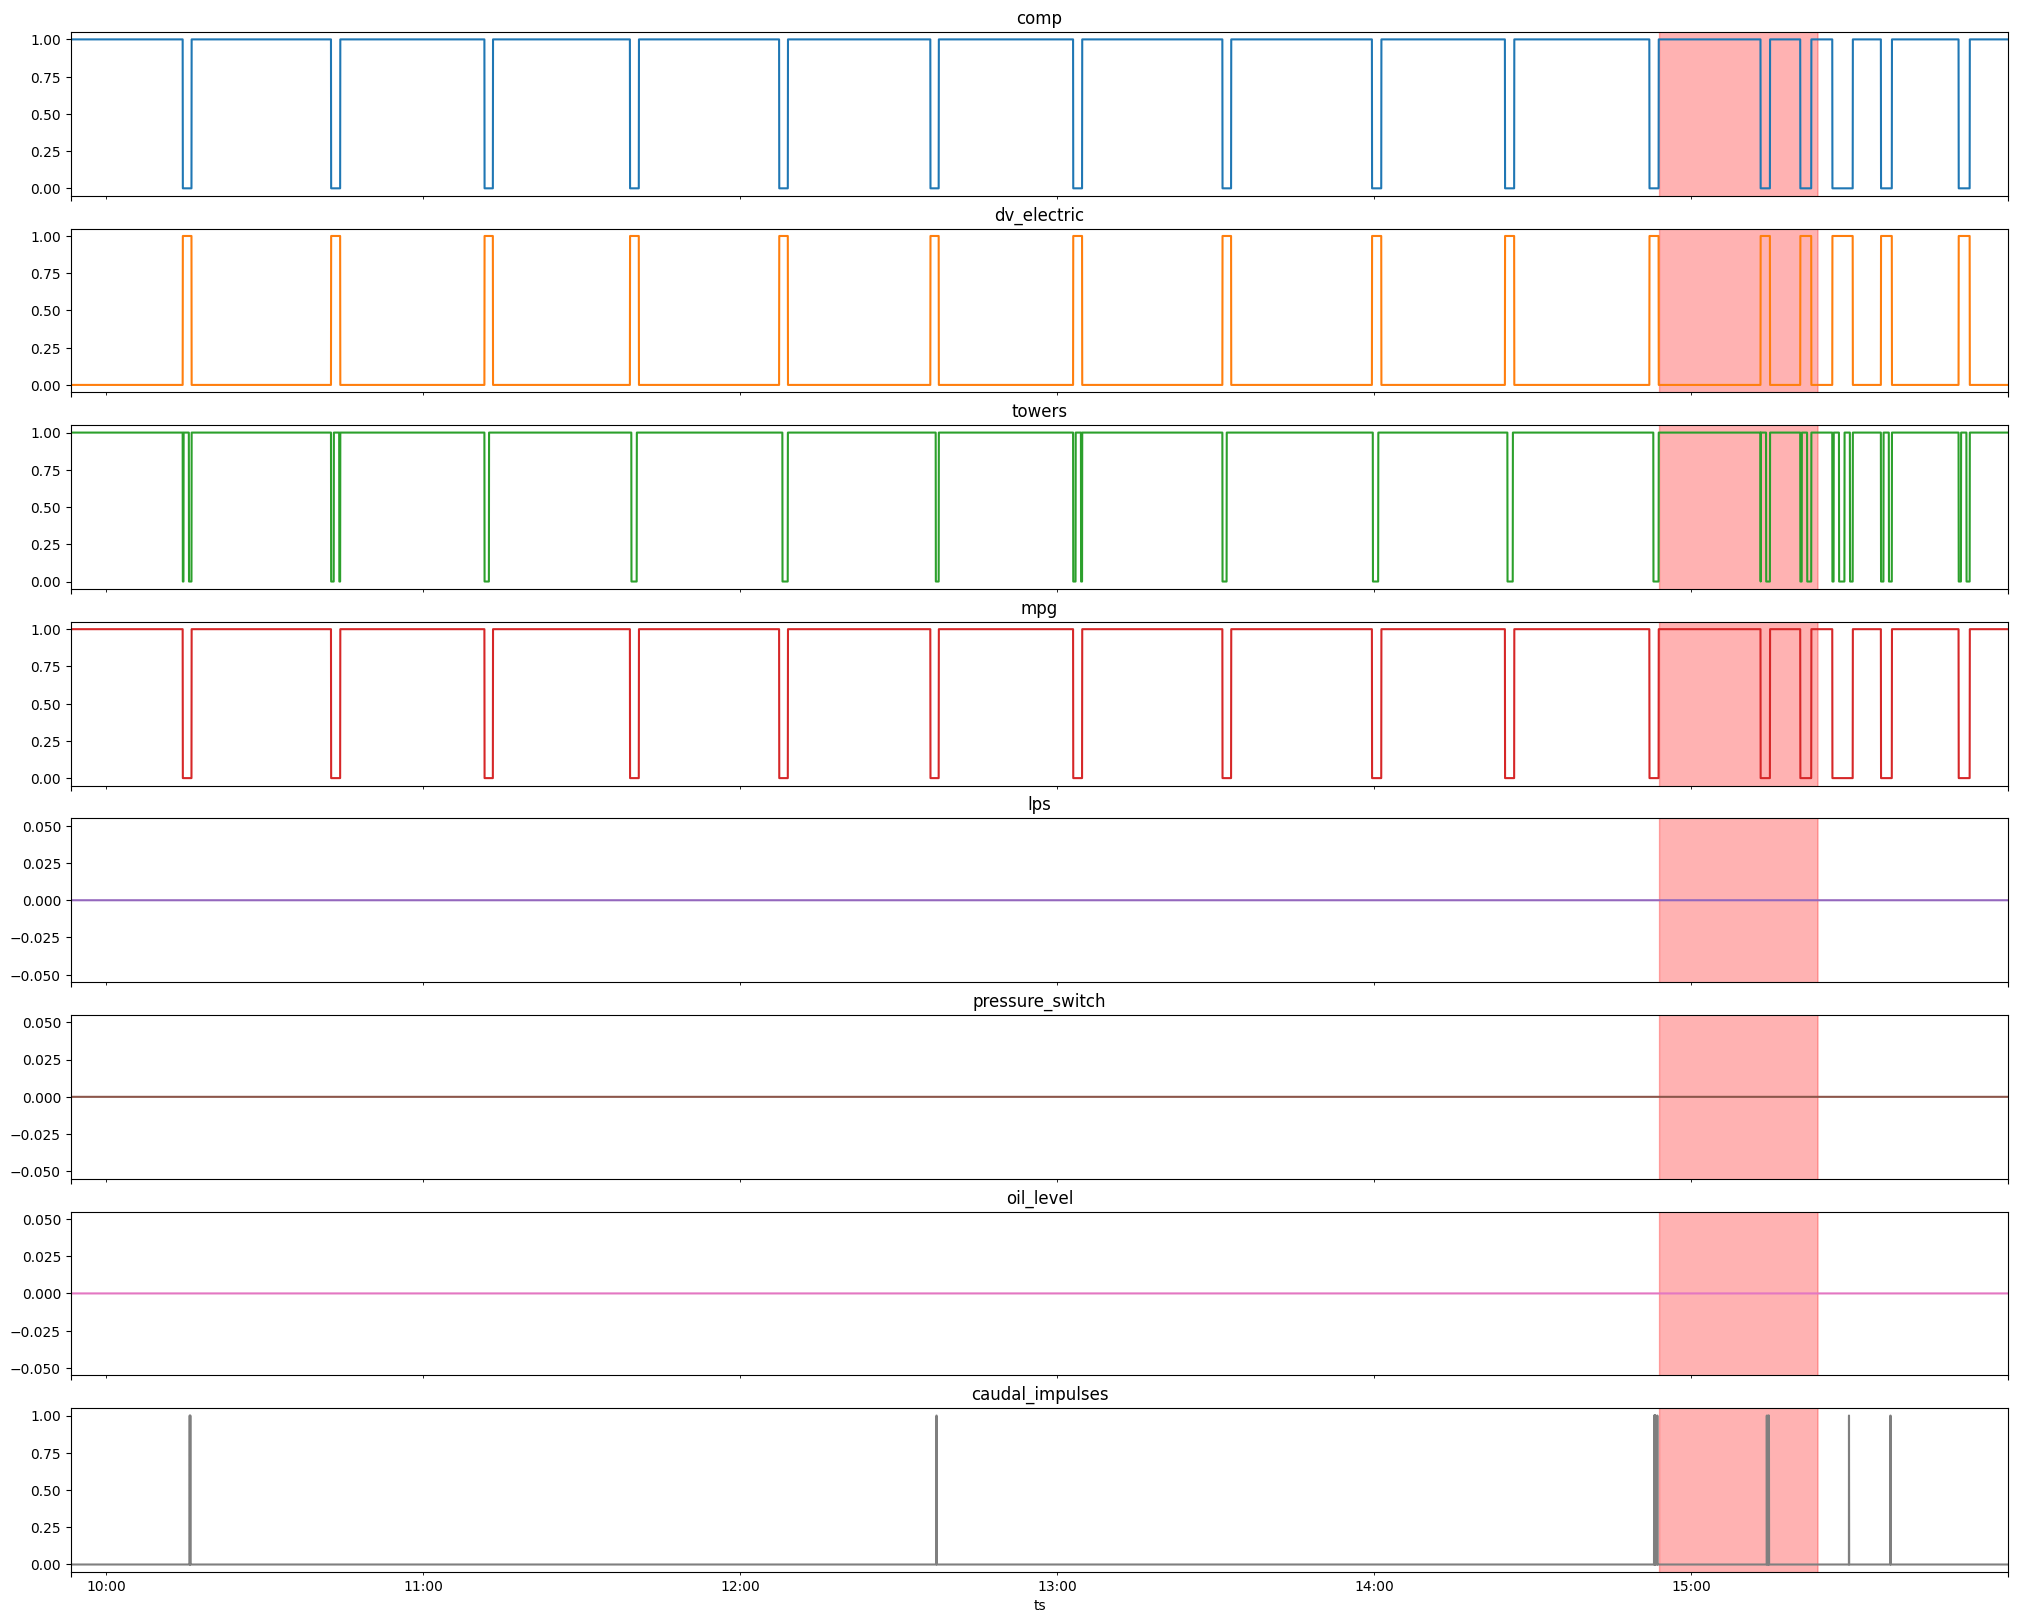

In [84]:
n = 22000

axes = df.tail(n).plot(
    x='ts',
    y=digital_cols,
    subplots=True,
    figsize=(25, 20),
    legend=False
)

for ax, col in zip(axes, digital_cols):
    ax.set_title(col)
    ax.autoscale(False)
    ax.fill_between(
        df['ts'].tail(n).to_list(),
        100,
        -100,
        where=(df['failure_id'] == 2).tail(n).to_list(),
        color='red',
        alpha=0.3
    )

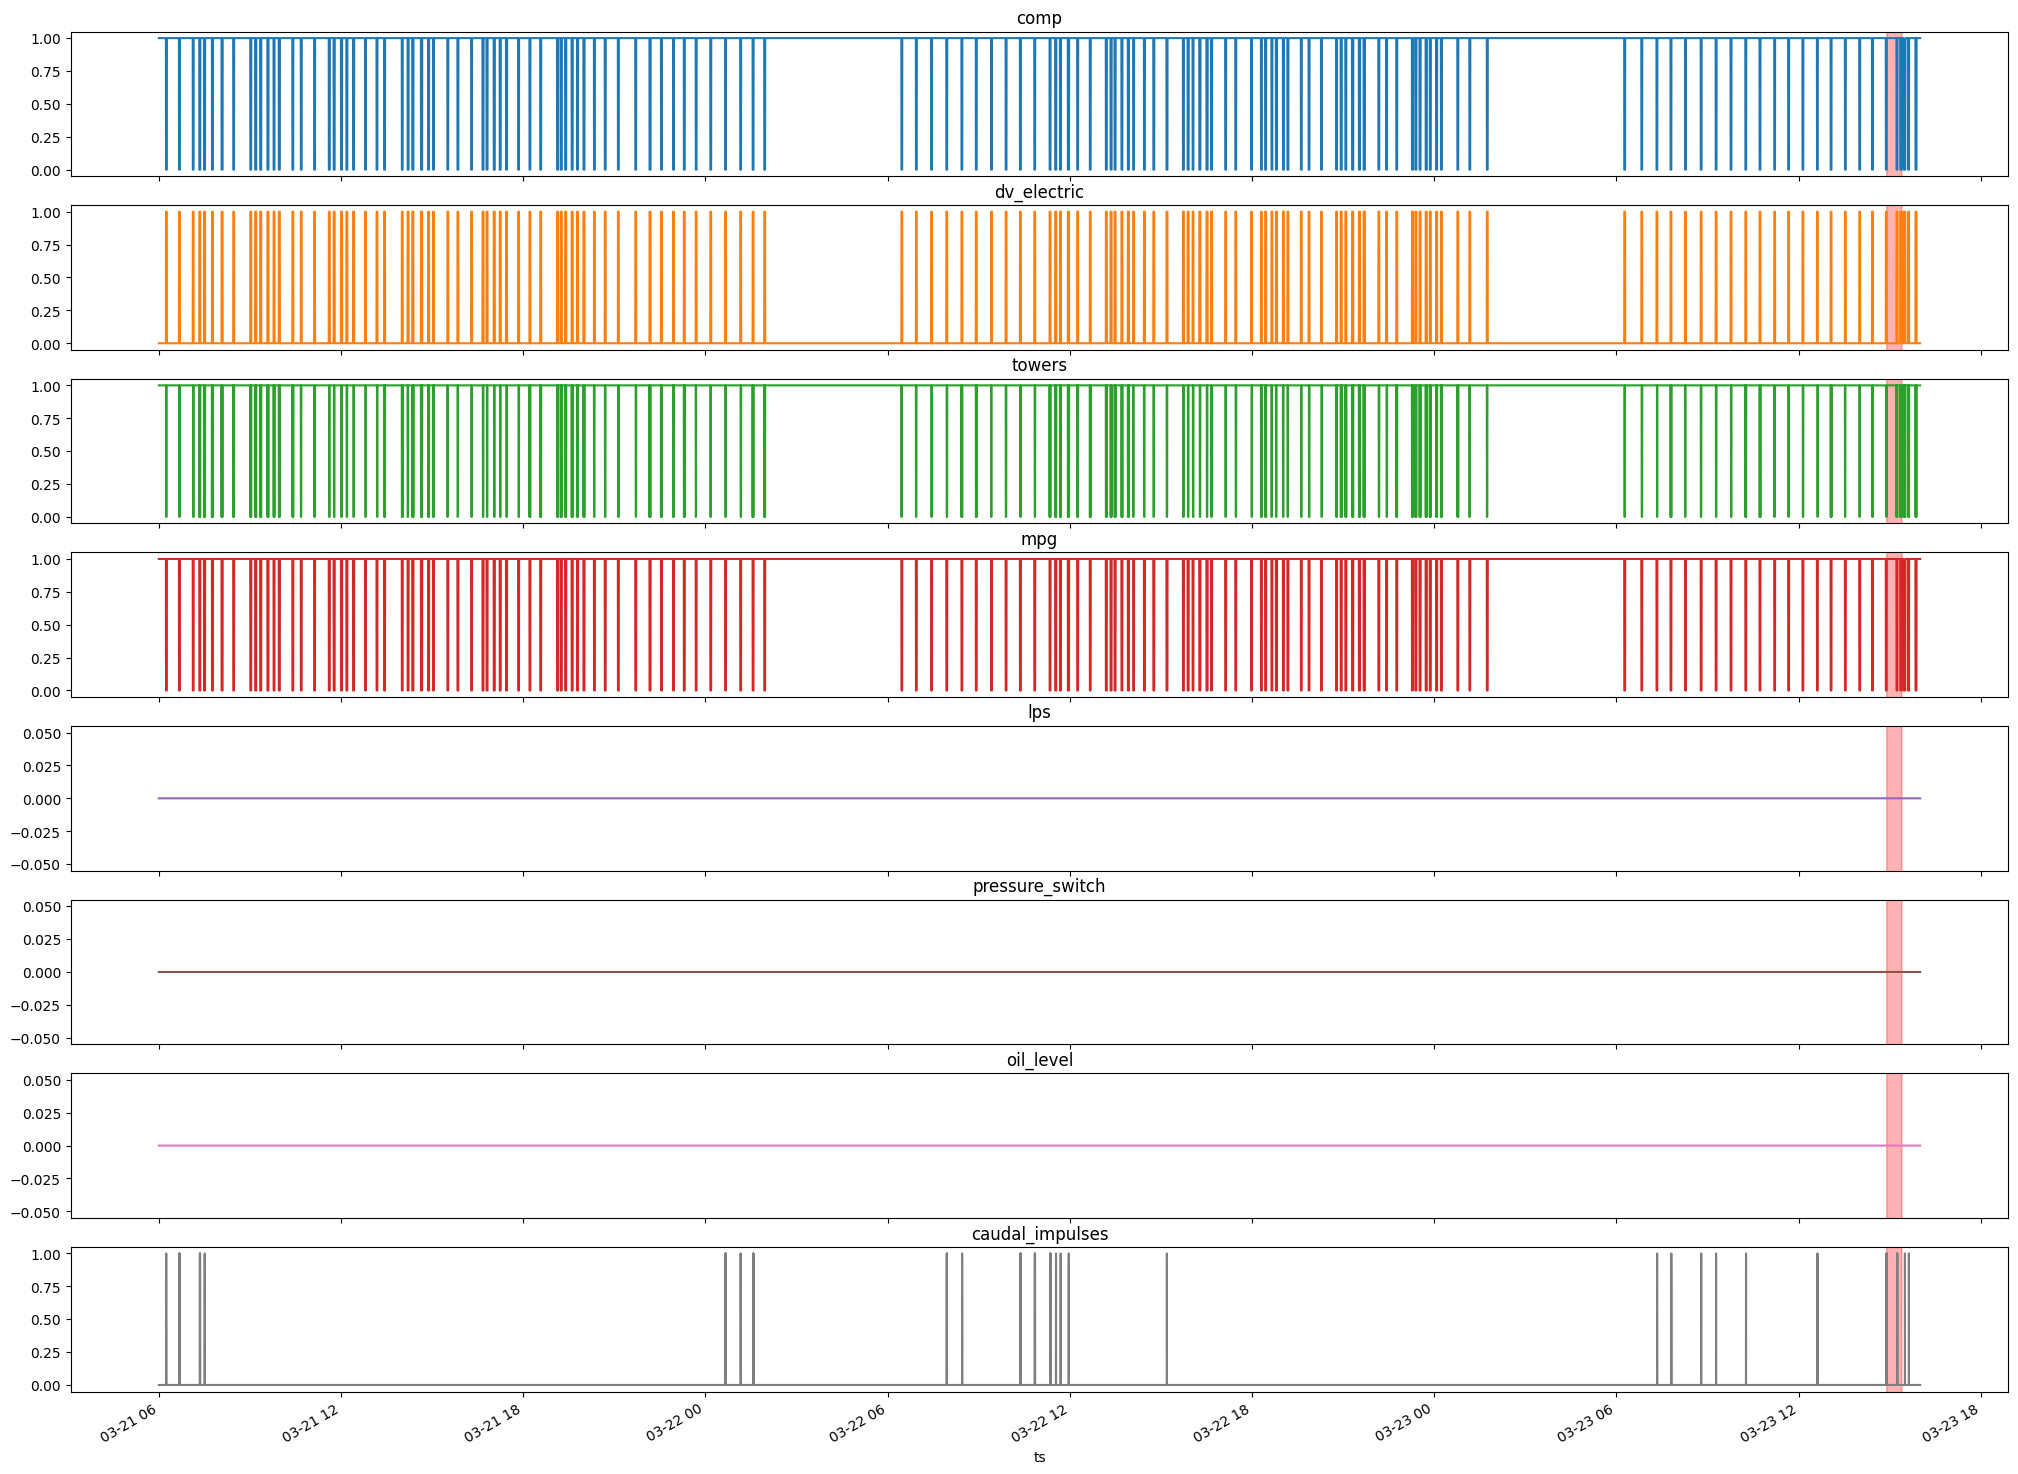

In [85]:
axes = df.plot(
    x='ts',
    y=digital_cols,
    subplots=True,
    figsize=(25, 20),
    legend=False
)

for ax, col in zip(axes, digital_cols):
    ax.set_title(col)
    ax.autoscale(False)
    ax.fill_between(
        df['ts'].to_list(),
        100,
        -100,
        where=(df['failure_id'] == 2).to_list(),
        color='red',
        alpha=0.3
    )

### Failure 3

In [87]:
# Failure 3 Plots - Analog Sensors
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select ts, failure_id, {columns} 
        from train_data 
        where '2022-05-28 06:00:00' <= ts and ts < '2022-05-30 14:00:00'
        order by ts asc
    """.format(columns=','.join(analog_cols)), con=con, parse_dates=['ts'])

print(df.shape)

(172802, 10)


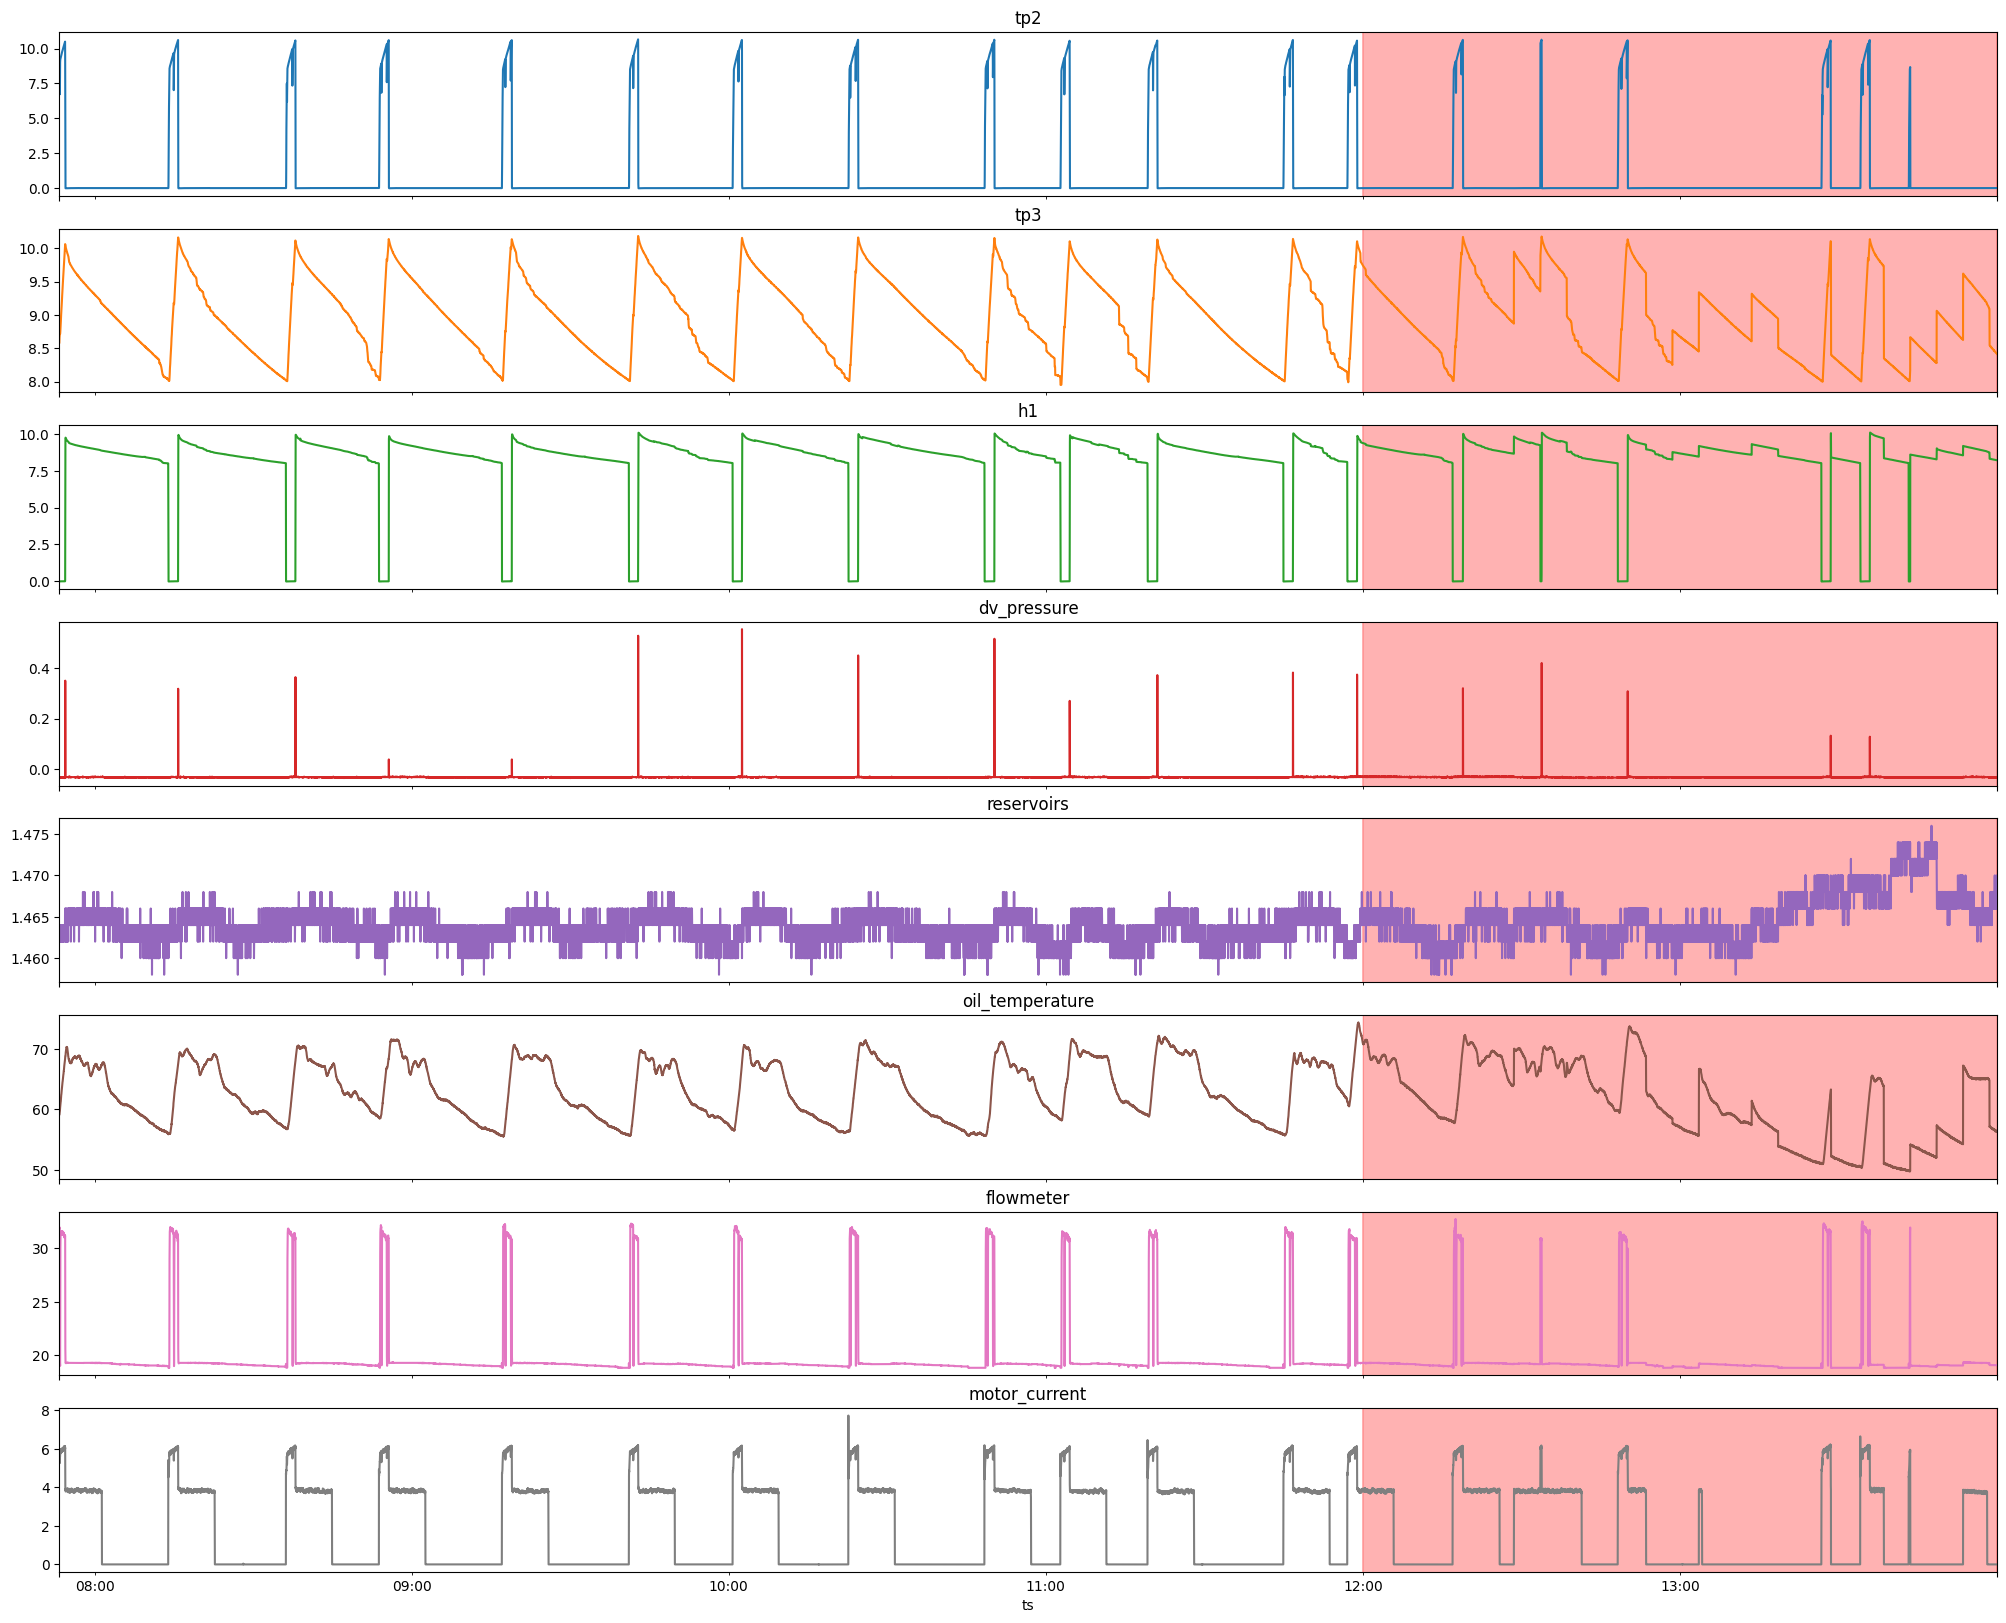

In [88]:
n = 22000

axes = df.tail(n).plot(
    x='ts',
    y=analog_cols,
    subplots=True,
    figsize=(25, 20),
    legend=False
)

for ax, col in zip(axes, analog_cols):
    ax.set_title(col)
    ax.autoscale(False)
    ax.fill_between(
        df['ts'].tail(n).to_list(),
        100,
        -100,
        where=(df['failure_id'] == 3).tail(n).to_list(),
        color='red',
        alpha=0.3
    )

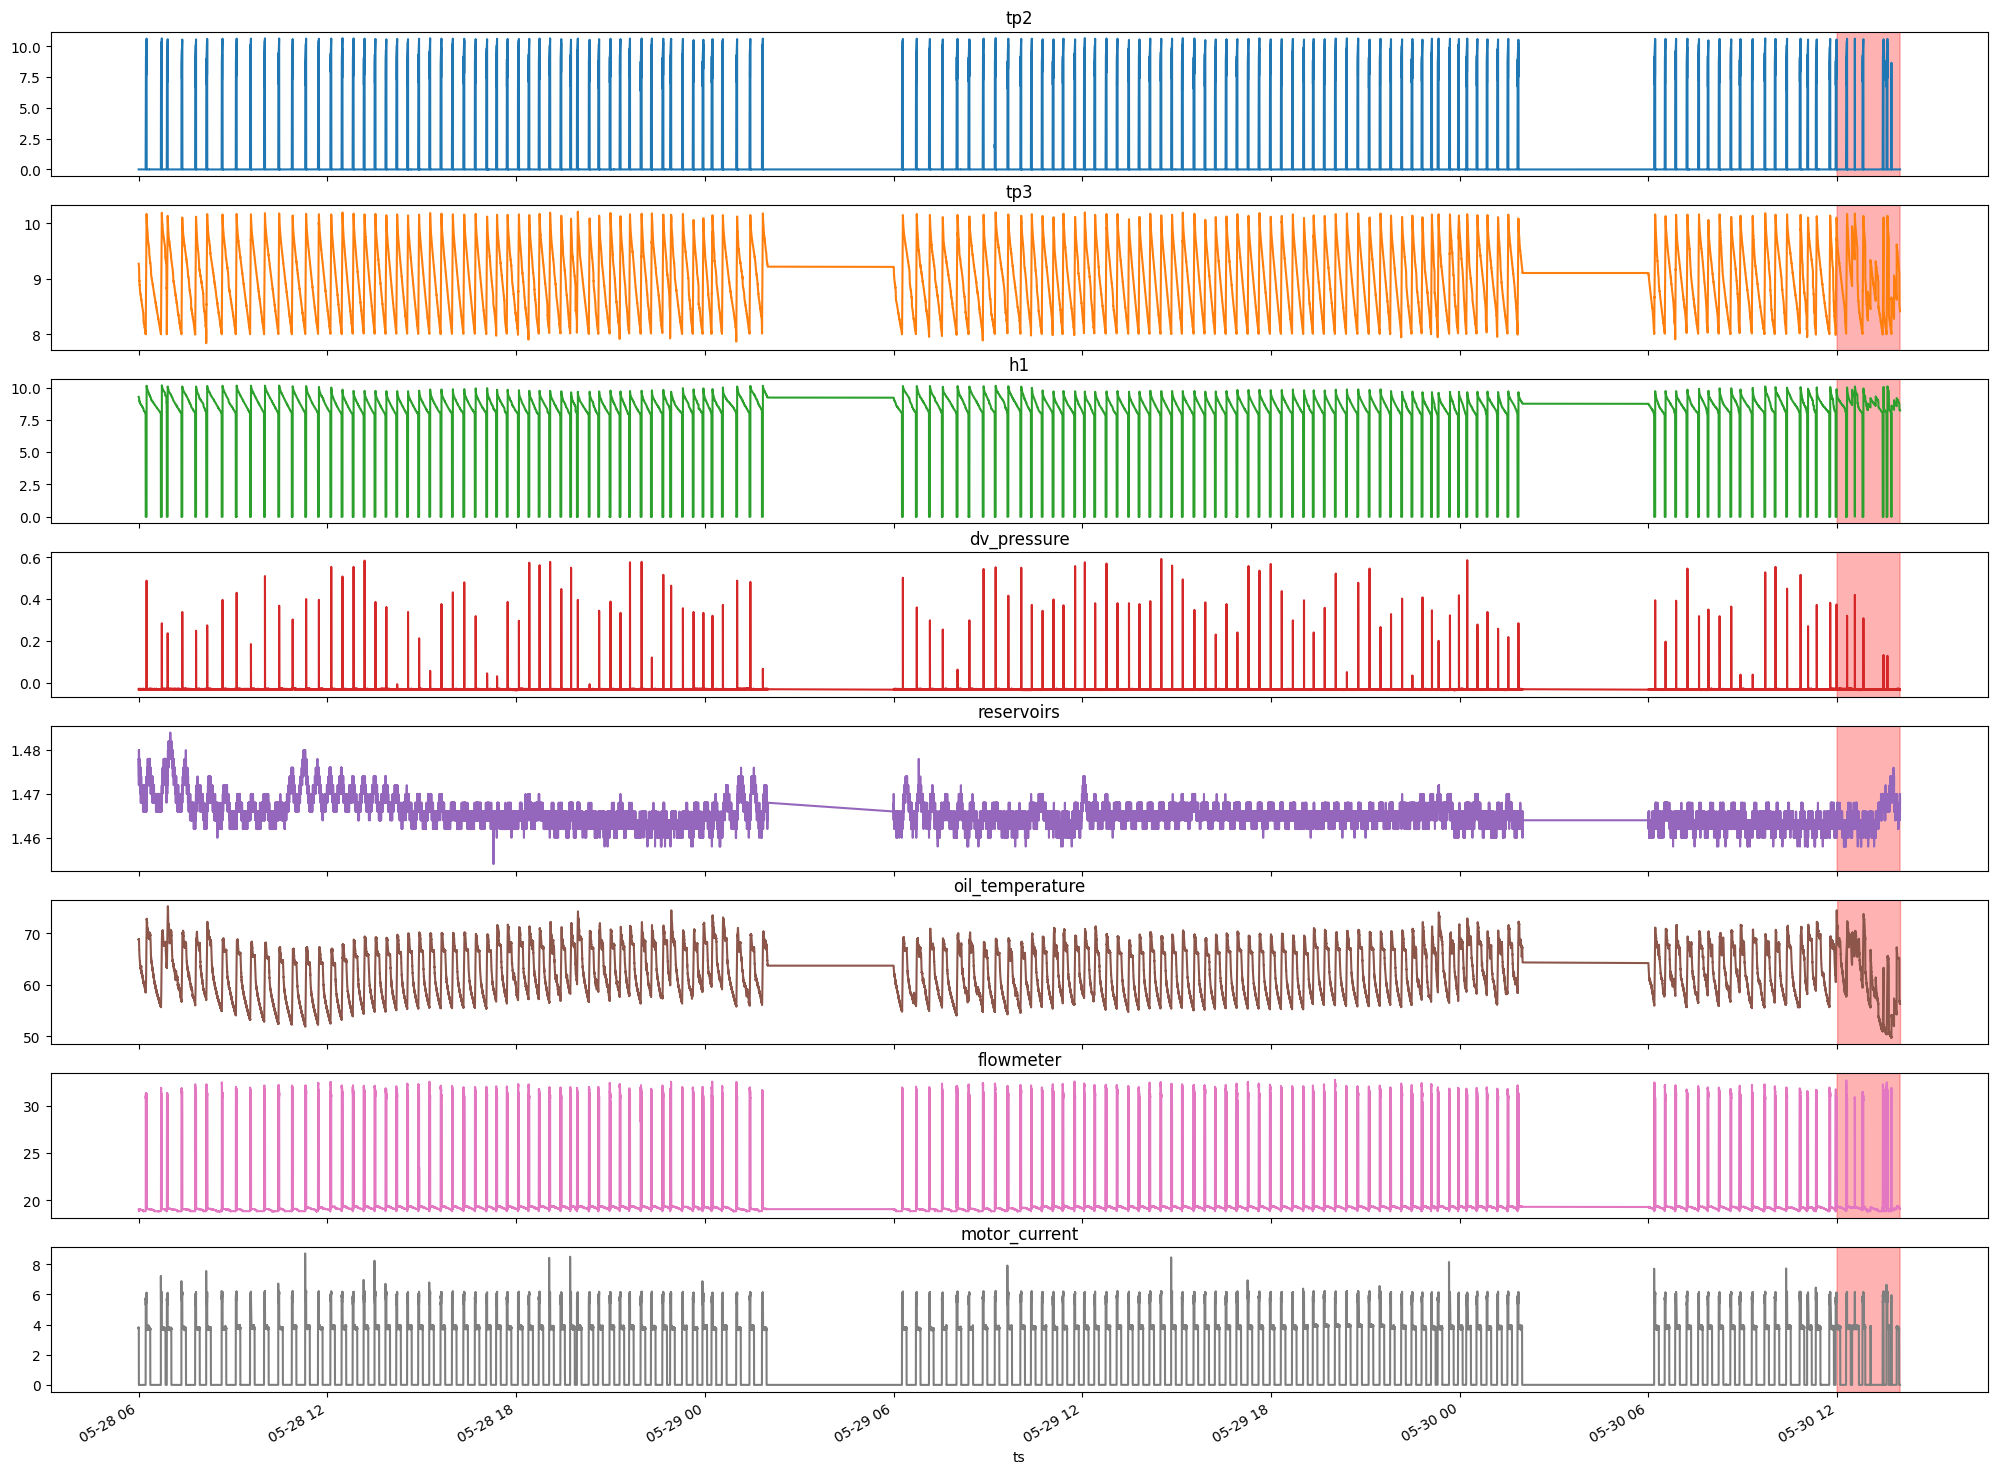

In [89]:
axes = df.plot(
    x='ts',
    y=analog_cols,
    subplots=True,
    figsize=(25, 20),
    legend=False
)

for ax, col in zip(axes, analog_cols):
    ax.set_title(col)
    ax.autoscale(False)
    ax.fill_between(
        df['ts'].to_list(),
        100,
        -100,
        where=(df['failure_id'] == 3).to_list(),
        color='red',
        alpha=0.3
    )

In [90]:
# Failure 3 Plots - Digital Sensors
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select ts, failure_id, {columns} 
        from train_data 
        where '2022-05-28 06:00:00' <= ts and ts < '2022-05-30 14:00:00'
        order by ts asc
    """.format(columns=','.join(digital_cols)), con=con, parse_dates=['ts'])

print(df.shape)

(172802, 10)


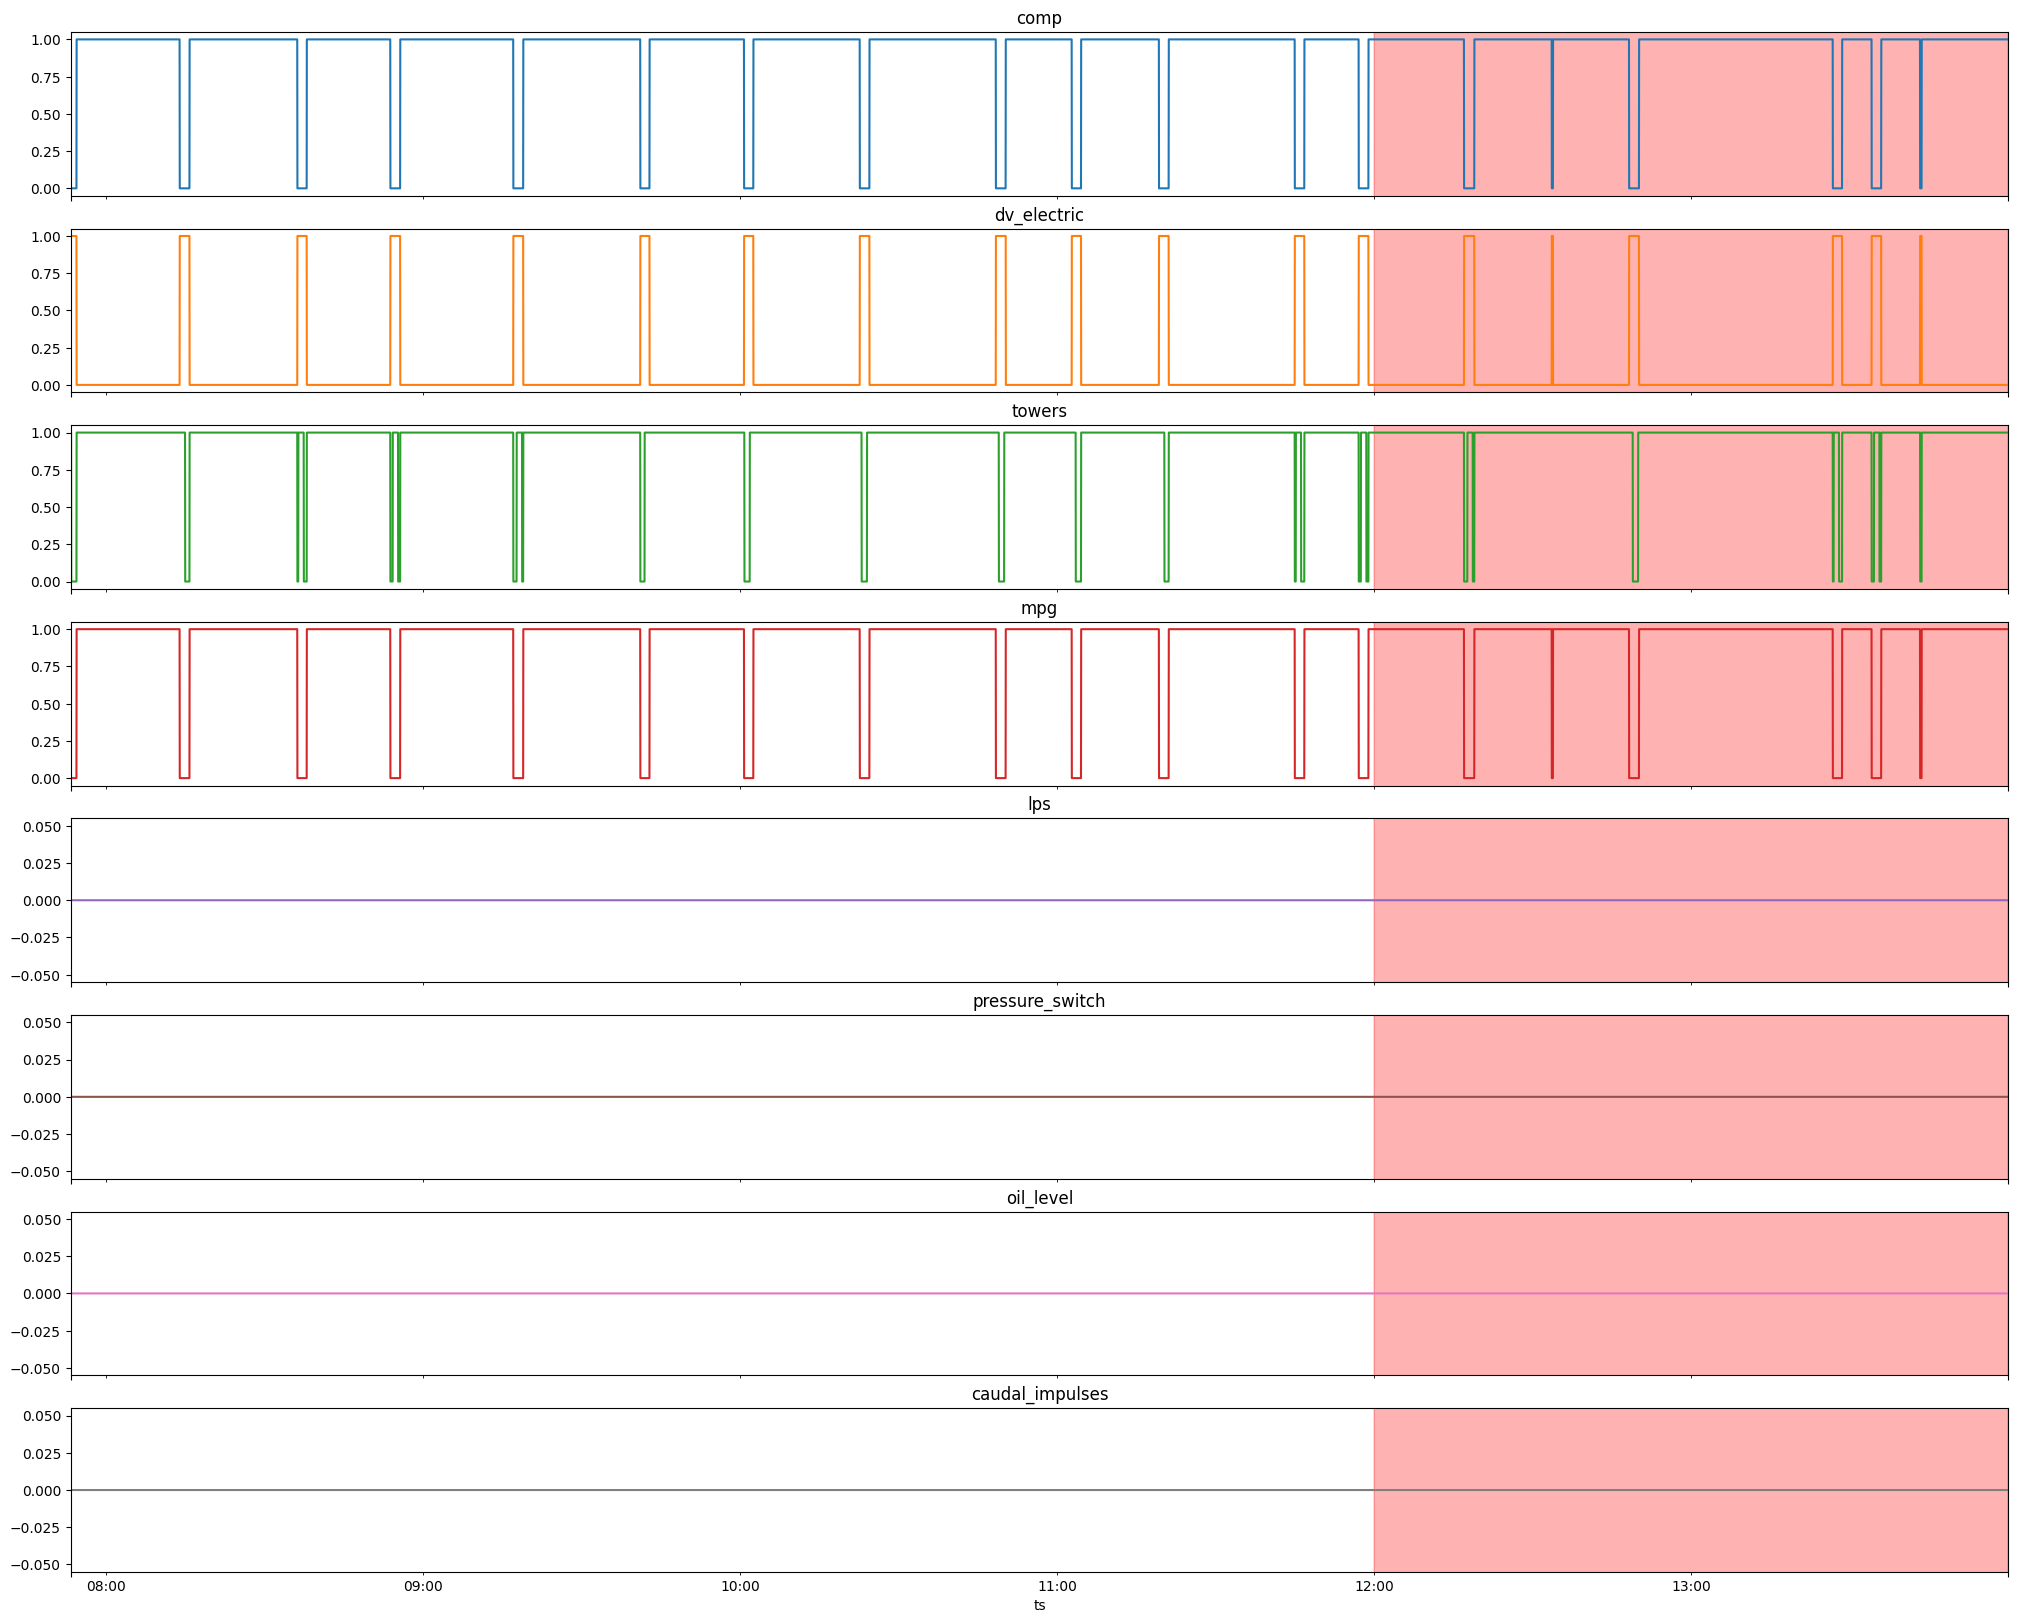

In [92]:
n = 22000

axes = df.tail(n).plot(
    x='ts',
    y=digital_cols,
    subplots=True,
    figsize=(25, 20),
    legend=False
)

for ax, col in zip(axes, digital_cols):
    ax.set_title(col)
    ax.autoscale(False)
    ax.fill_between(
        df['ts'].tail(n).to_list(),
        100,
        -100,
        where=(df['failure_id'].tail(n) == 3).to_list(),
        color='red',
        alpha=0.3
    )

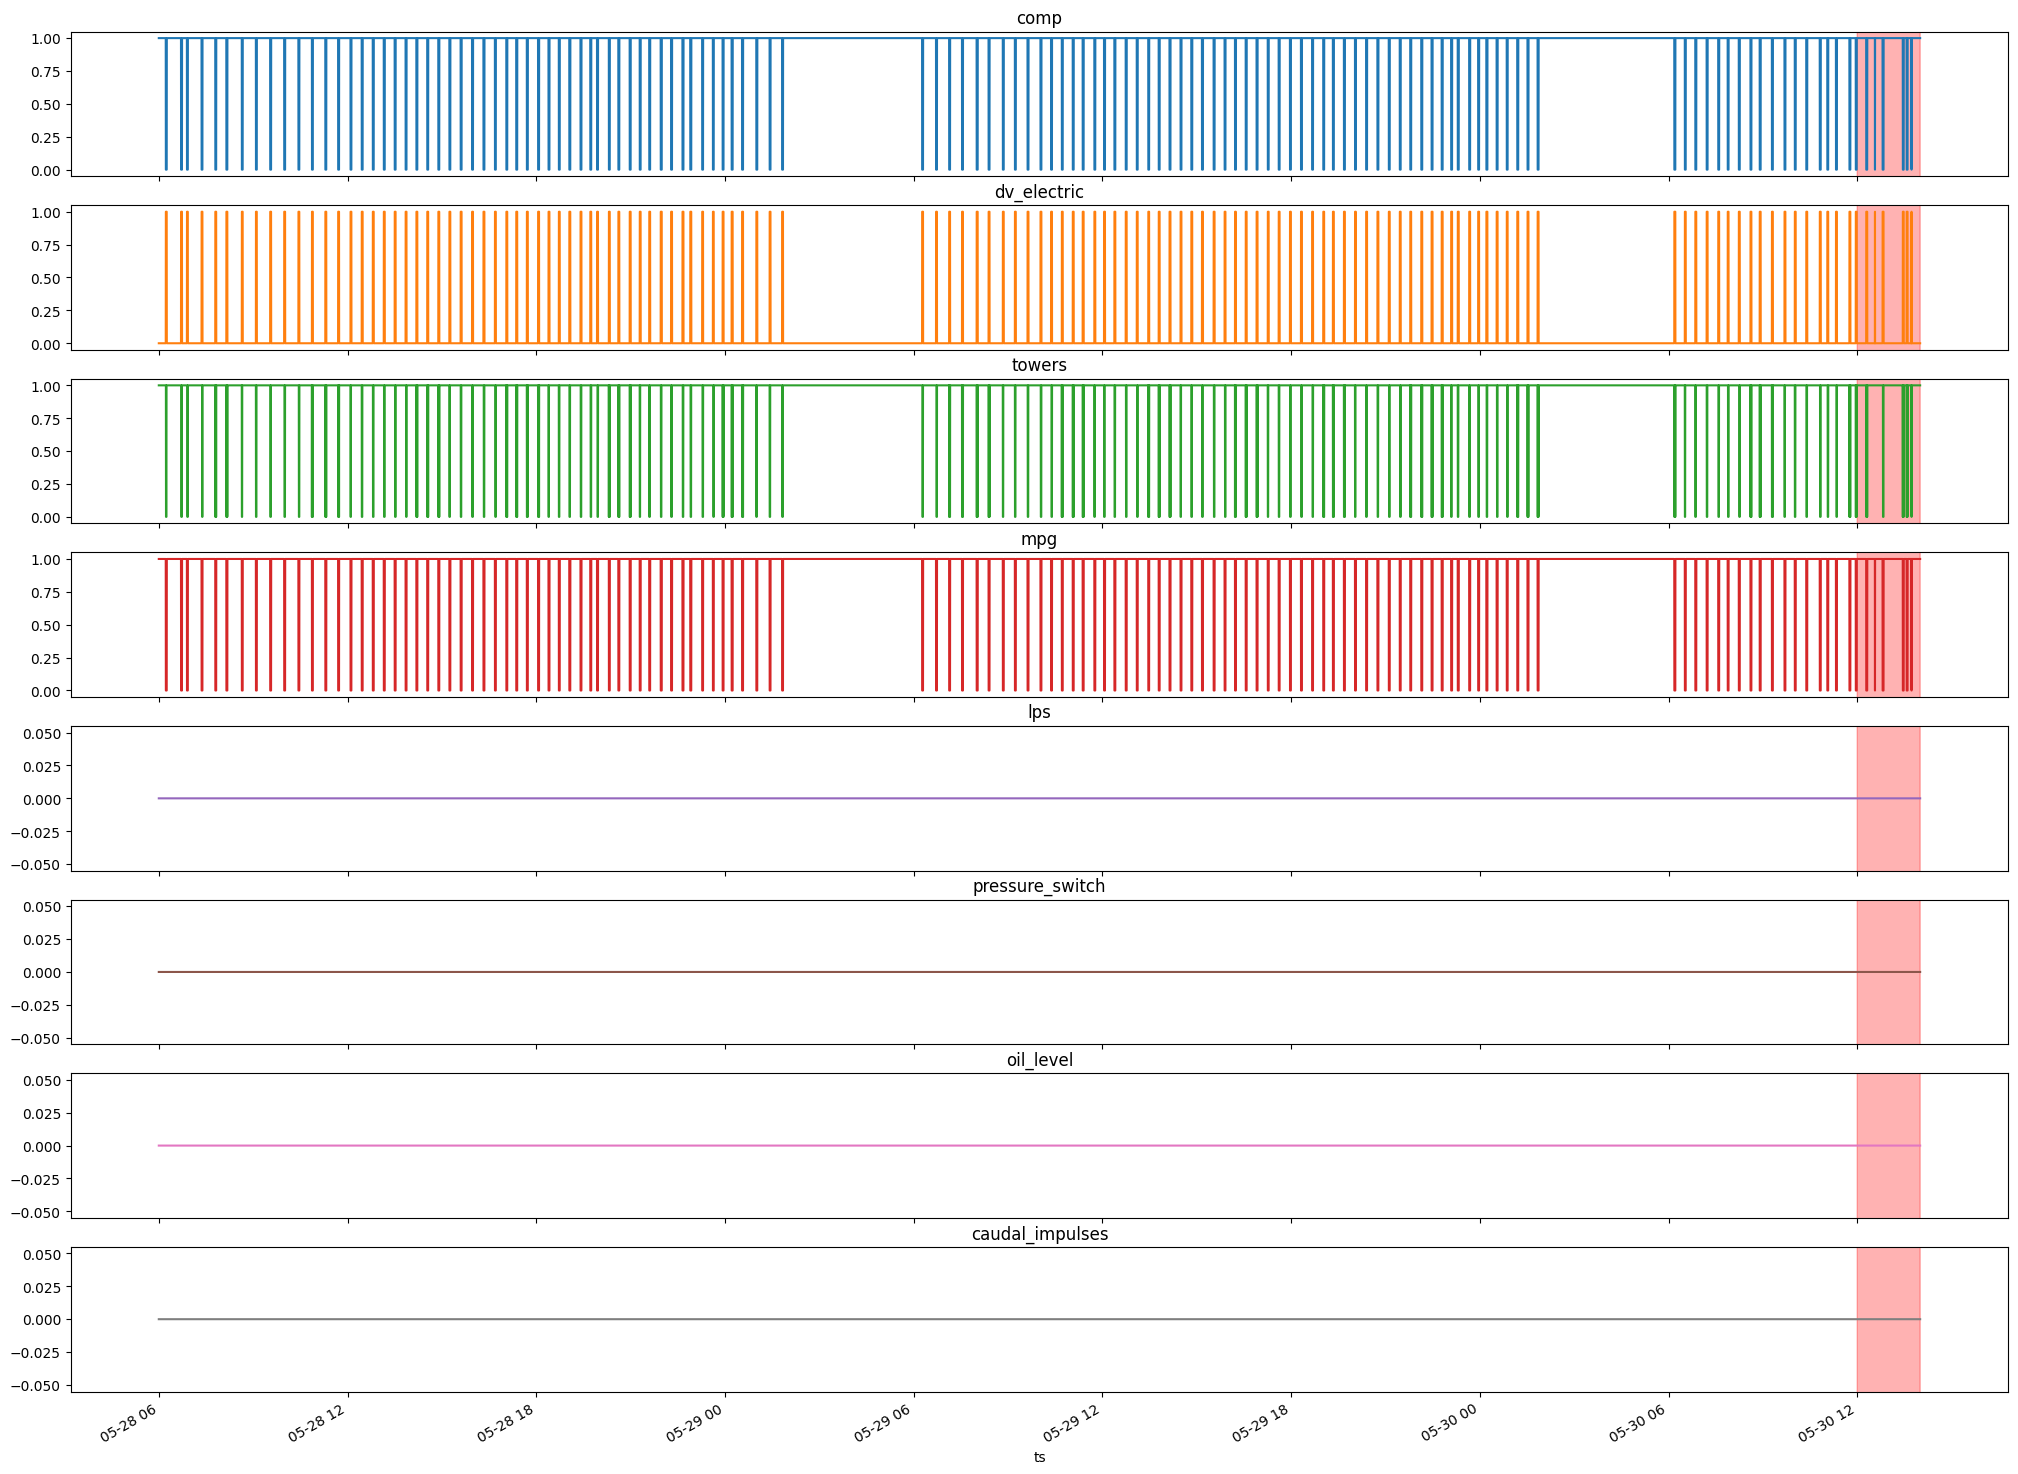

In [91]:
axes = df.plot(
    x='ts',
    y=digital_cols,
    subplots=True,
    figsize=(25, 20),
    legend=False
)

for ax, col in zip(axes, digital_cols):
    ax.set_title(col)
    ax.autoscale(False)
    ax.fill_between(
        df['ts'].to_list(),
        100,
        -100,
        where=(df['failure_id'] == 3).to_list(),
        color='red',
        alpha=0.3
    )

### LPS Failure

In [93]:
# LPS Failure Plots - Analog Sensors
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select ts, lps, {columns} 
        from train_data 
        where '2022-01-08 06:00:00' <= ts and ts < '2022-01-10 08:00:00'
        order by ts asc
    """.format(columns=','.join(analog_cols)), con=con, parse_dates=['ts'])

print(df.shape)

(151202, 10)


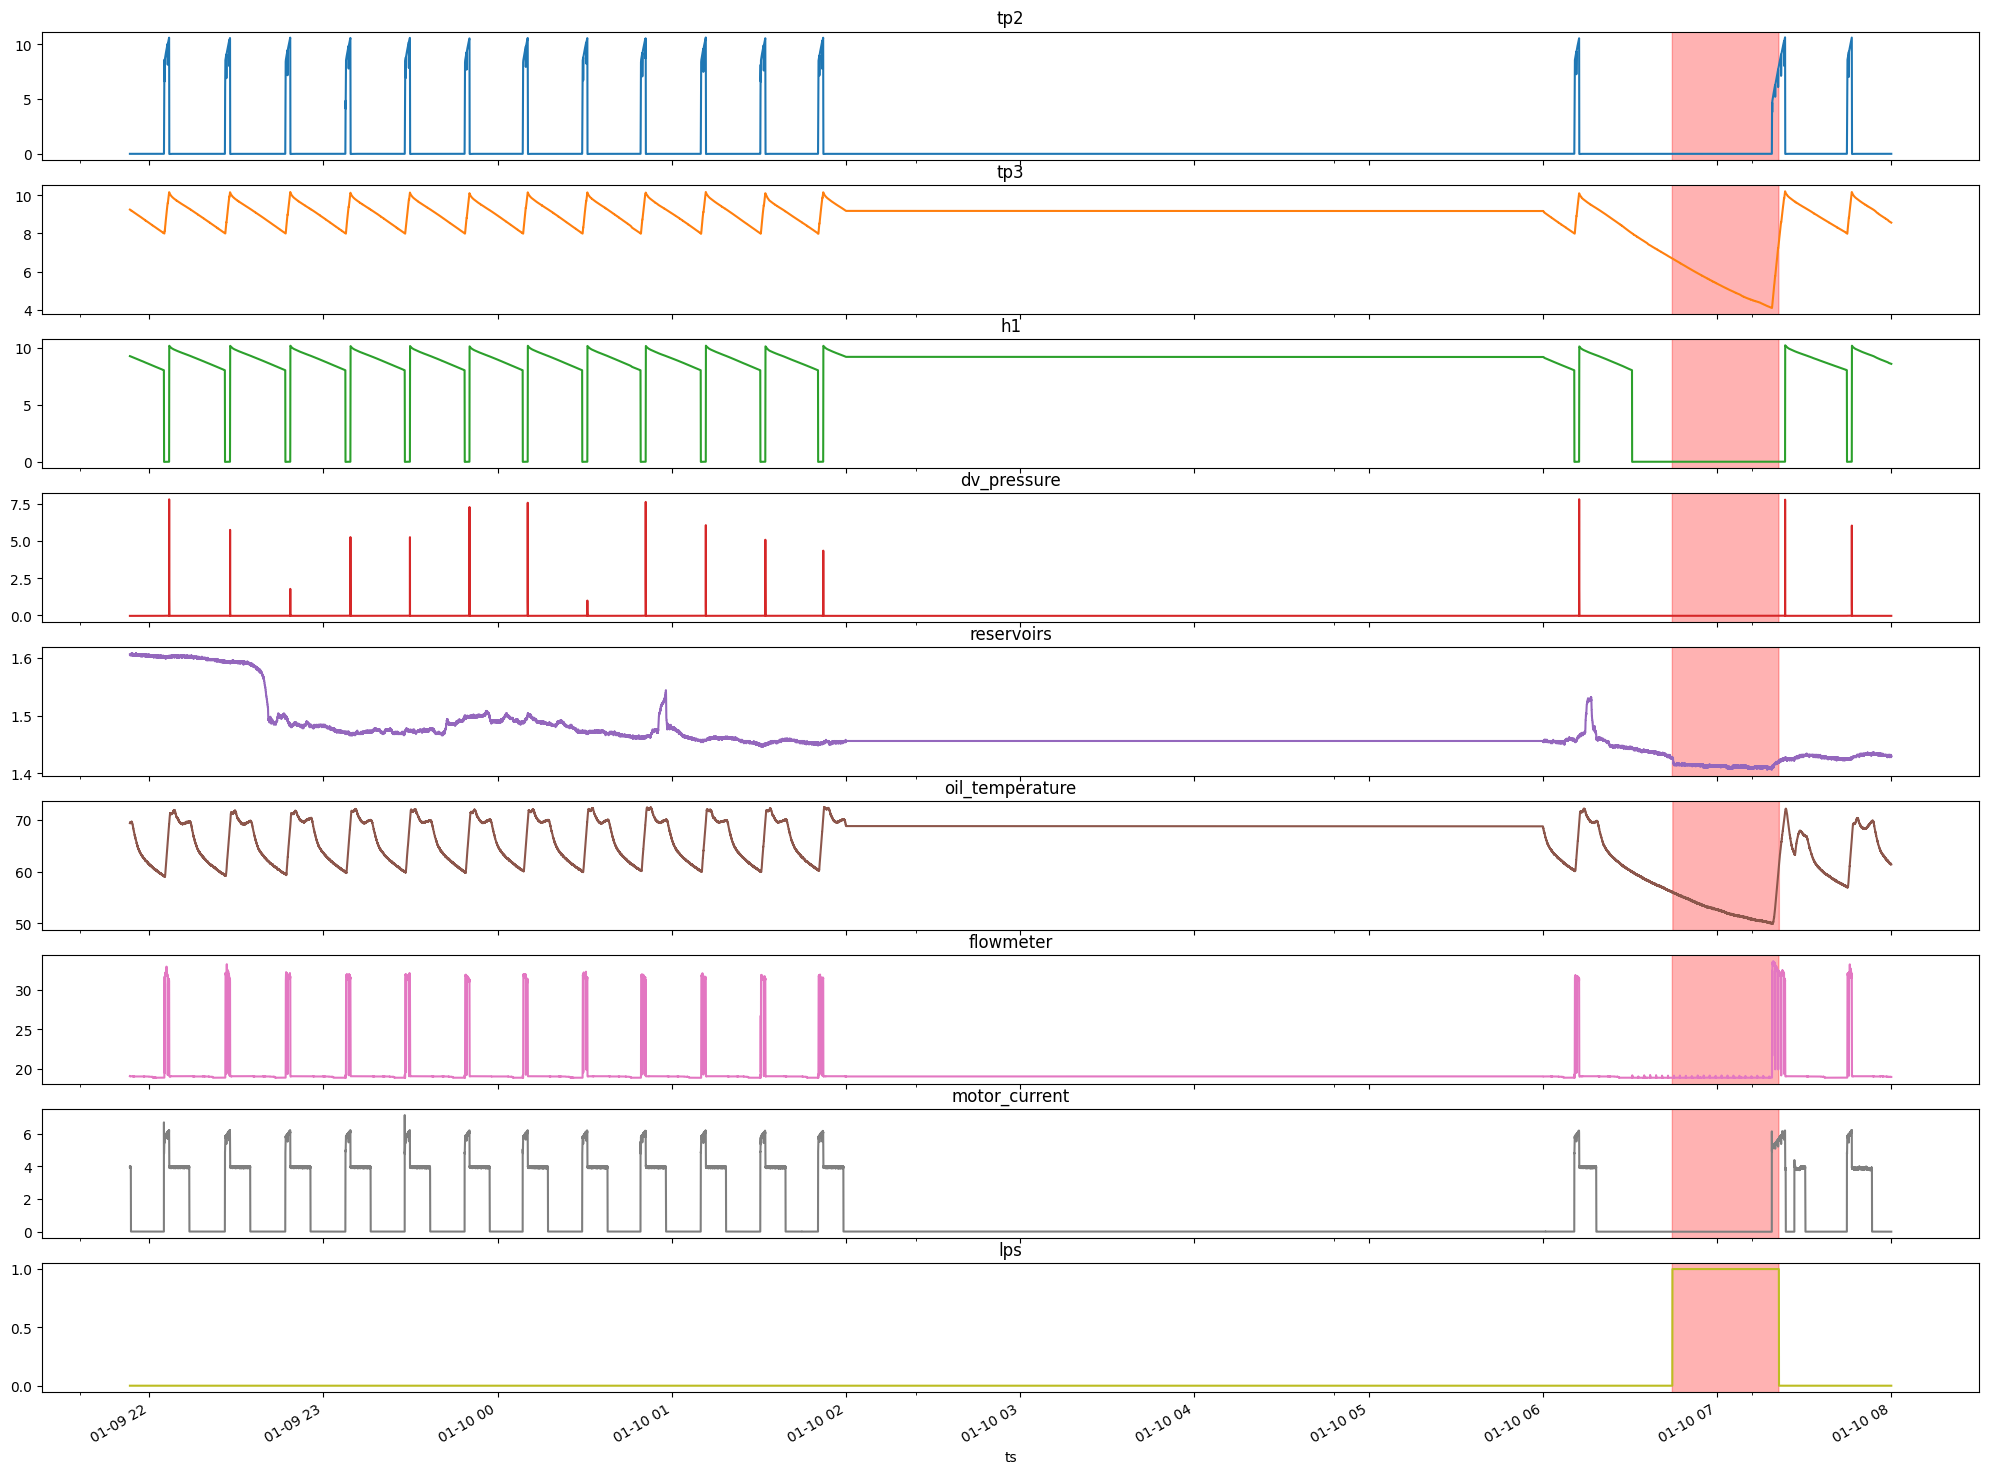

In [94]:
n = 22000

axes = df.tail(n).plot(
    x='ts',
    y=analog_cols + ['lps'],
    subplots=True,
    figsize=(25, 20),
    legend=False
)

for ax, col in zip(axes, analog_cols + ['lps']):
    ax.set_title(col)
    ax.autoscale(False)
    ax.fill_between(
        df['ts'].tail(n).to_list(),
        100,
        -100,
        where=(df['lps'] == 1).tail(n).to_list(),
        color='red',
        alpha=0.3
    )

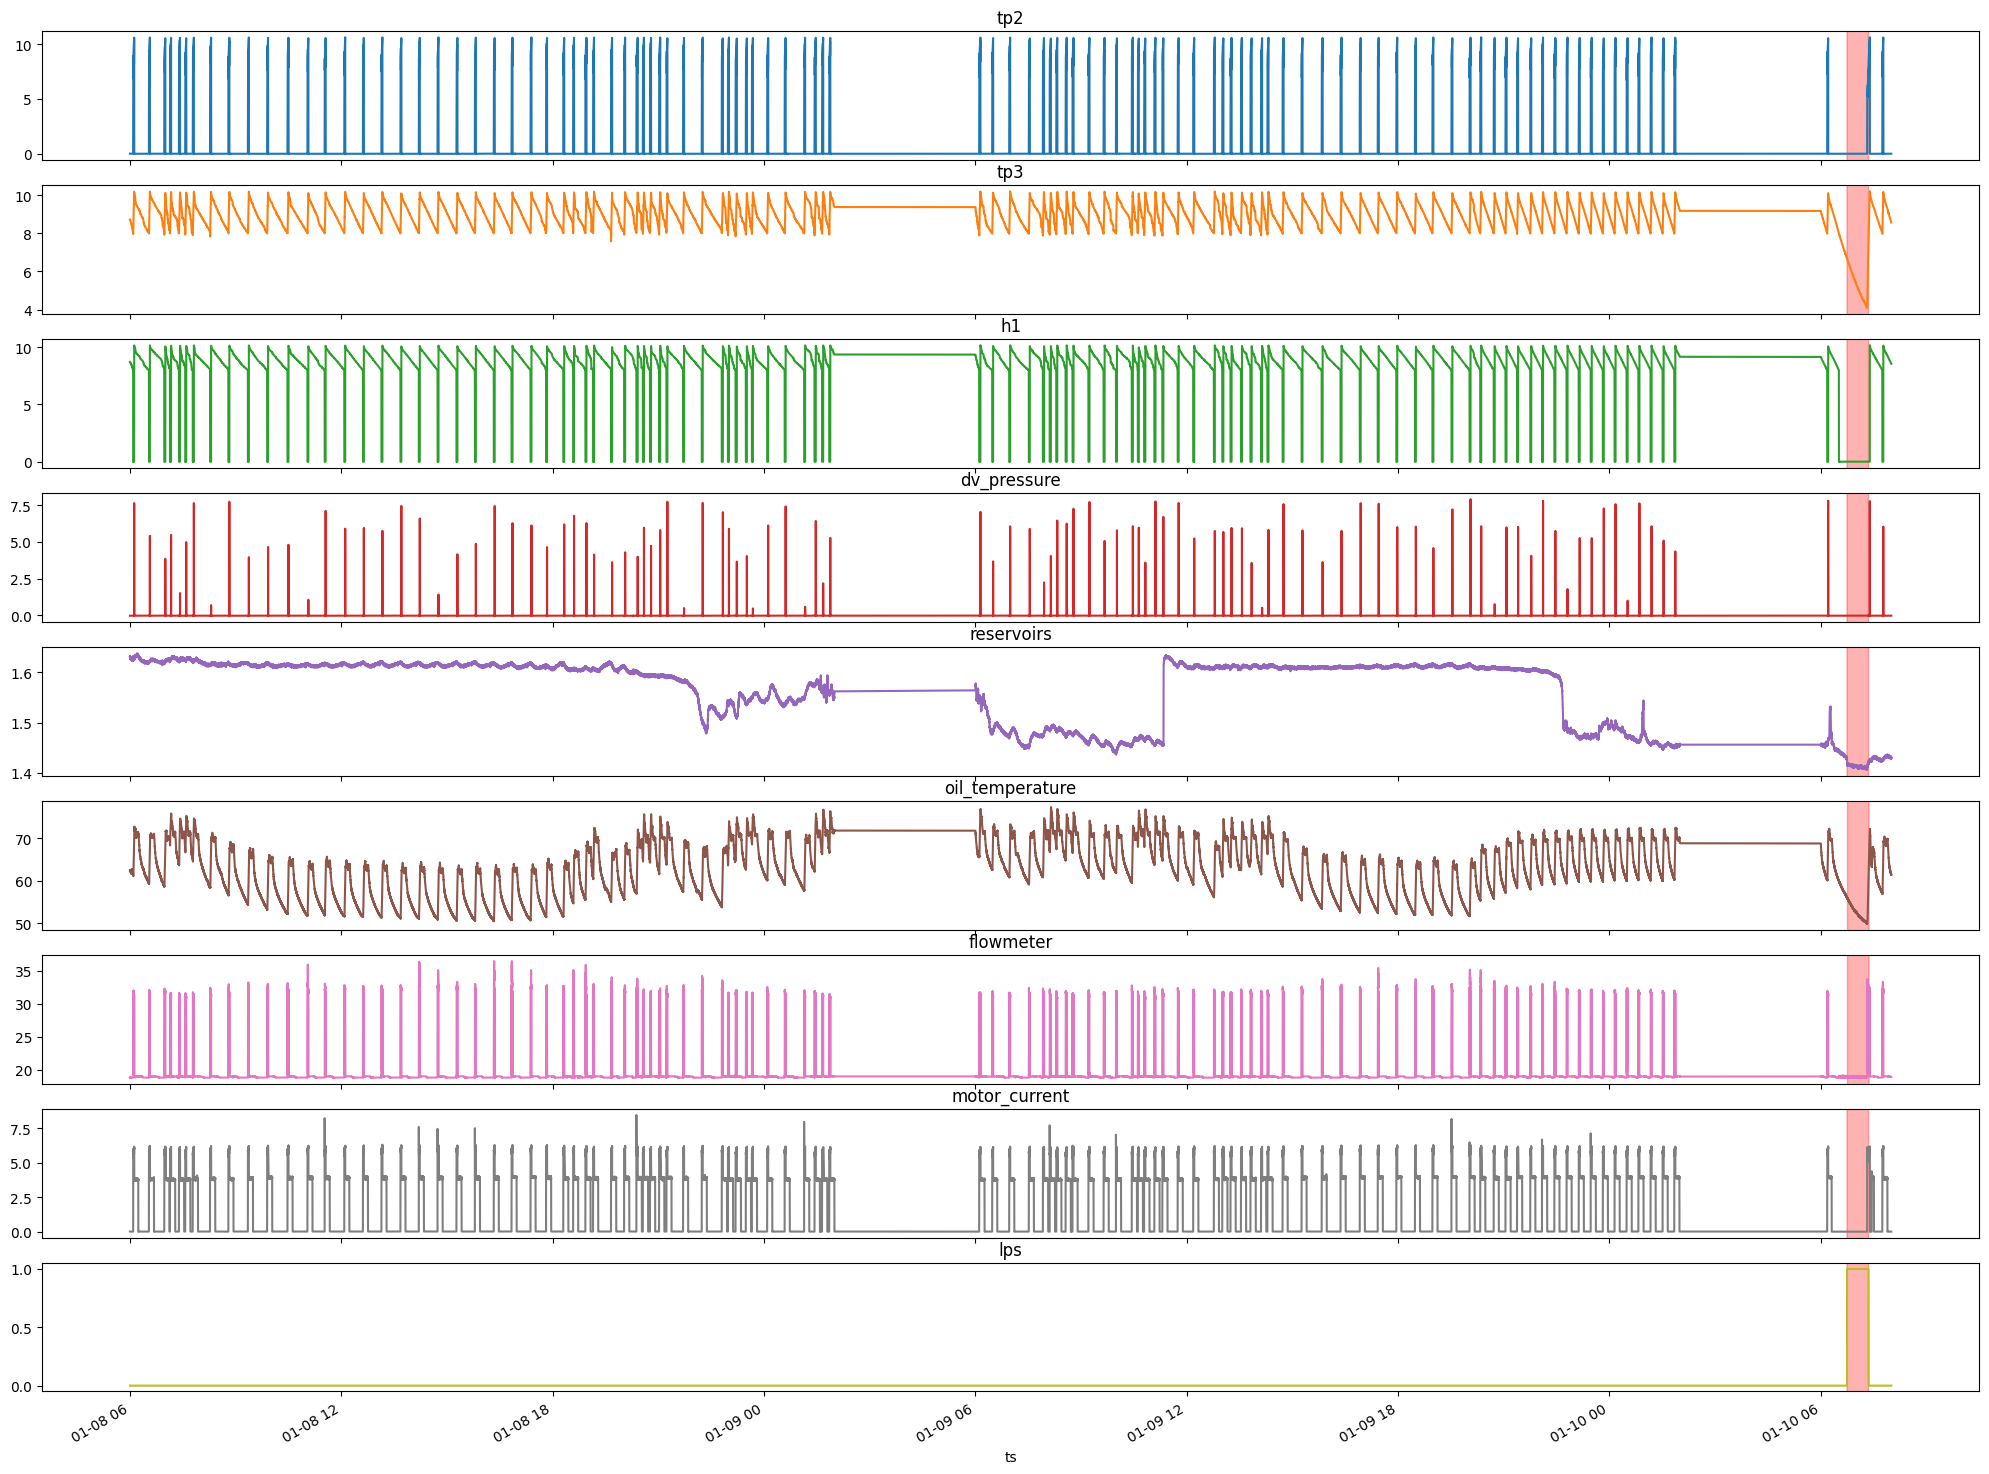

In [95]:
axes = df.plot(
    x='ts',
    y=analog_cols + ['lps'],
    subplots=True,
    figsize=(25, 20),
    legend=False
)

for ax, col in zip(axes, analog_cols + ['lps']):
    ax.set_title(col)
    ax.autoscale(False)
    ax.fill_between(
        df['ts'].to_list(),
        100,
        -100,
        where=(df['lps'] == 1).to_list(),
        color='red',
        alpha=0.3
    )

In [96]:
# LPS Failure Plots - Digital Sensors
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select ts, {columns} 
        from train_data 
        where '2022-01-08 06:00:00' <= ts and ts < '2022-01-10 08:00:00'
        order by ts asc
    """.format(columns=','.join(digital_cols)), con=con, parse_dates=['ts'])

print(df.shape)

(151202, 9)


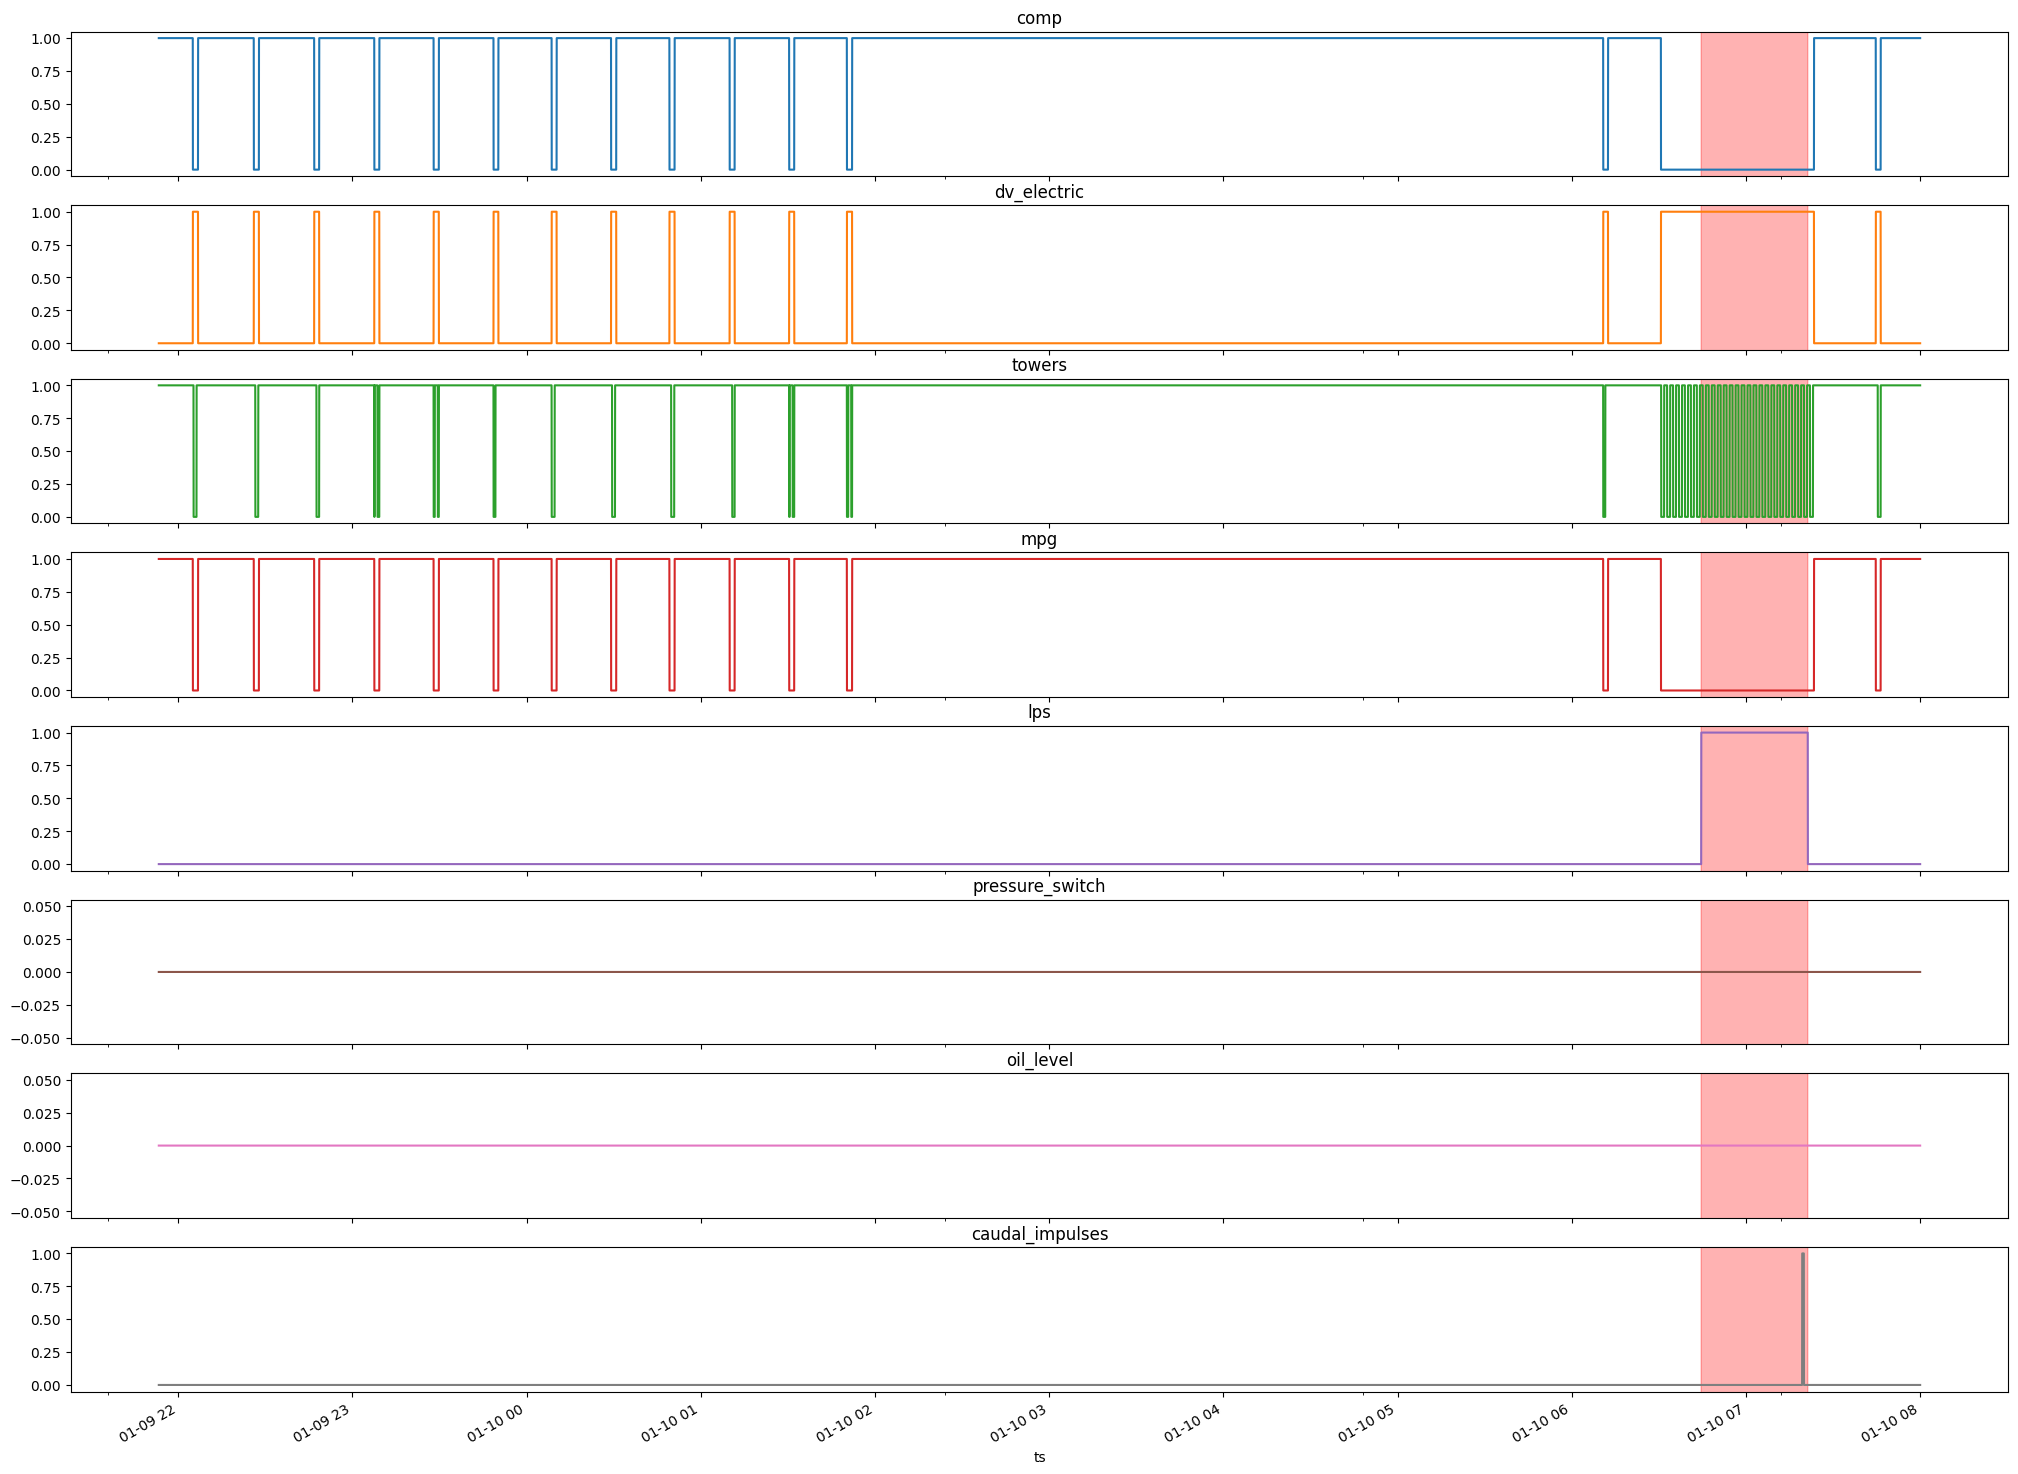

In [98]:
n = 22000
axes = df.tail(n).plot(
    x='ts',
    y=digital_cols,
    subplots=True,
    figsize=(25, 20),
    legend=False
)

for ax, col in zip(axes, digital_cols):
    ax.set_title(col)
    ax.autoscale(False)
    ax.fill_between(
        df['ts'].tail(n).to_list(),
        100,
        -100,
        where=(df['lps'].tail(n) == 1).to_list(),
        color='red',
        alpha=0.3
    )

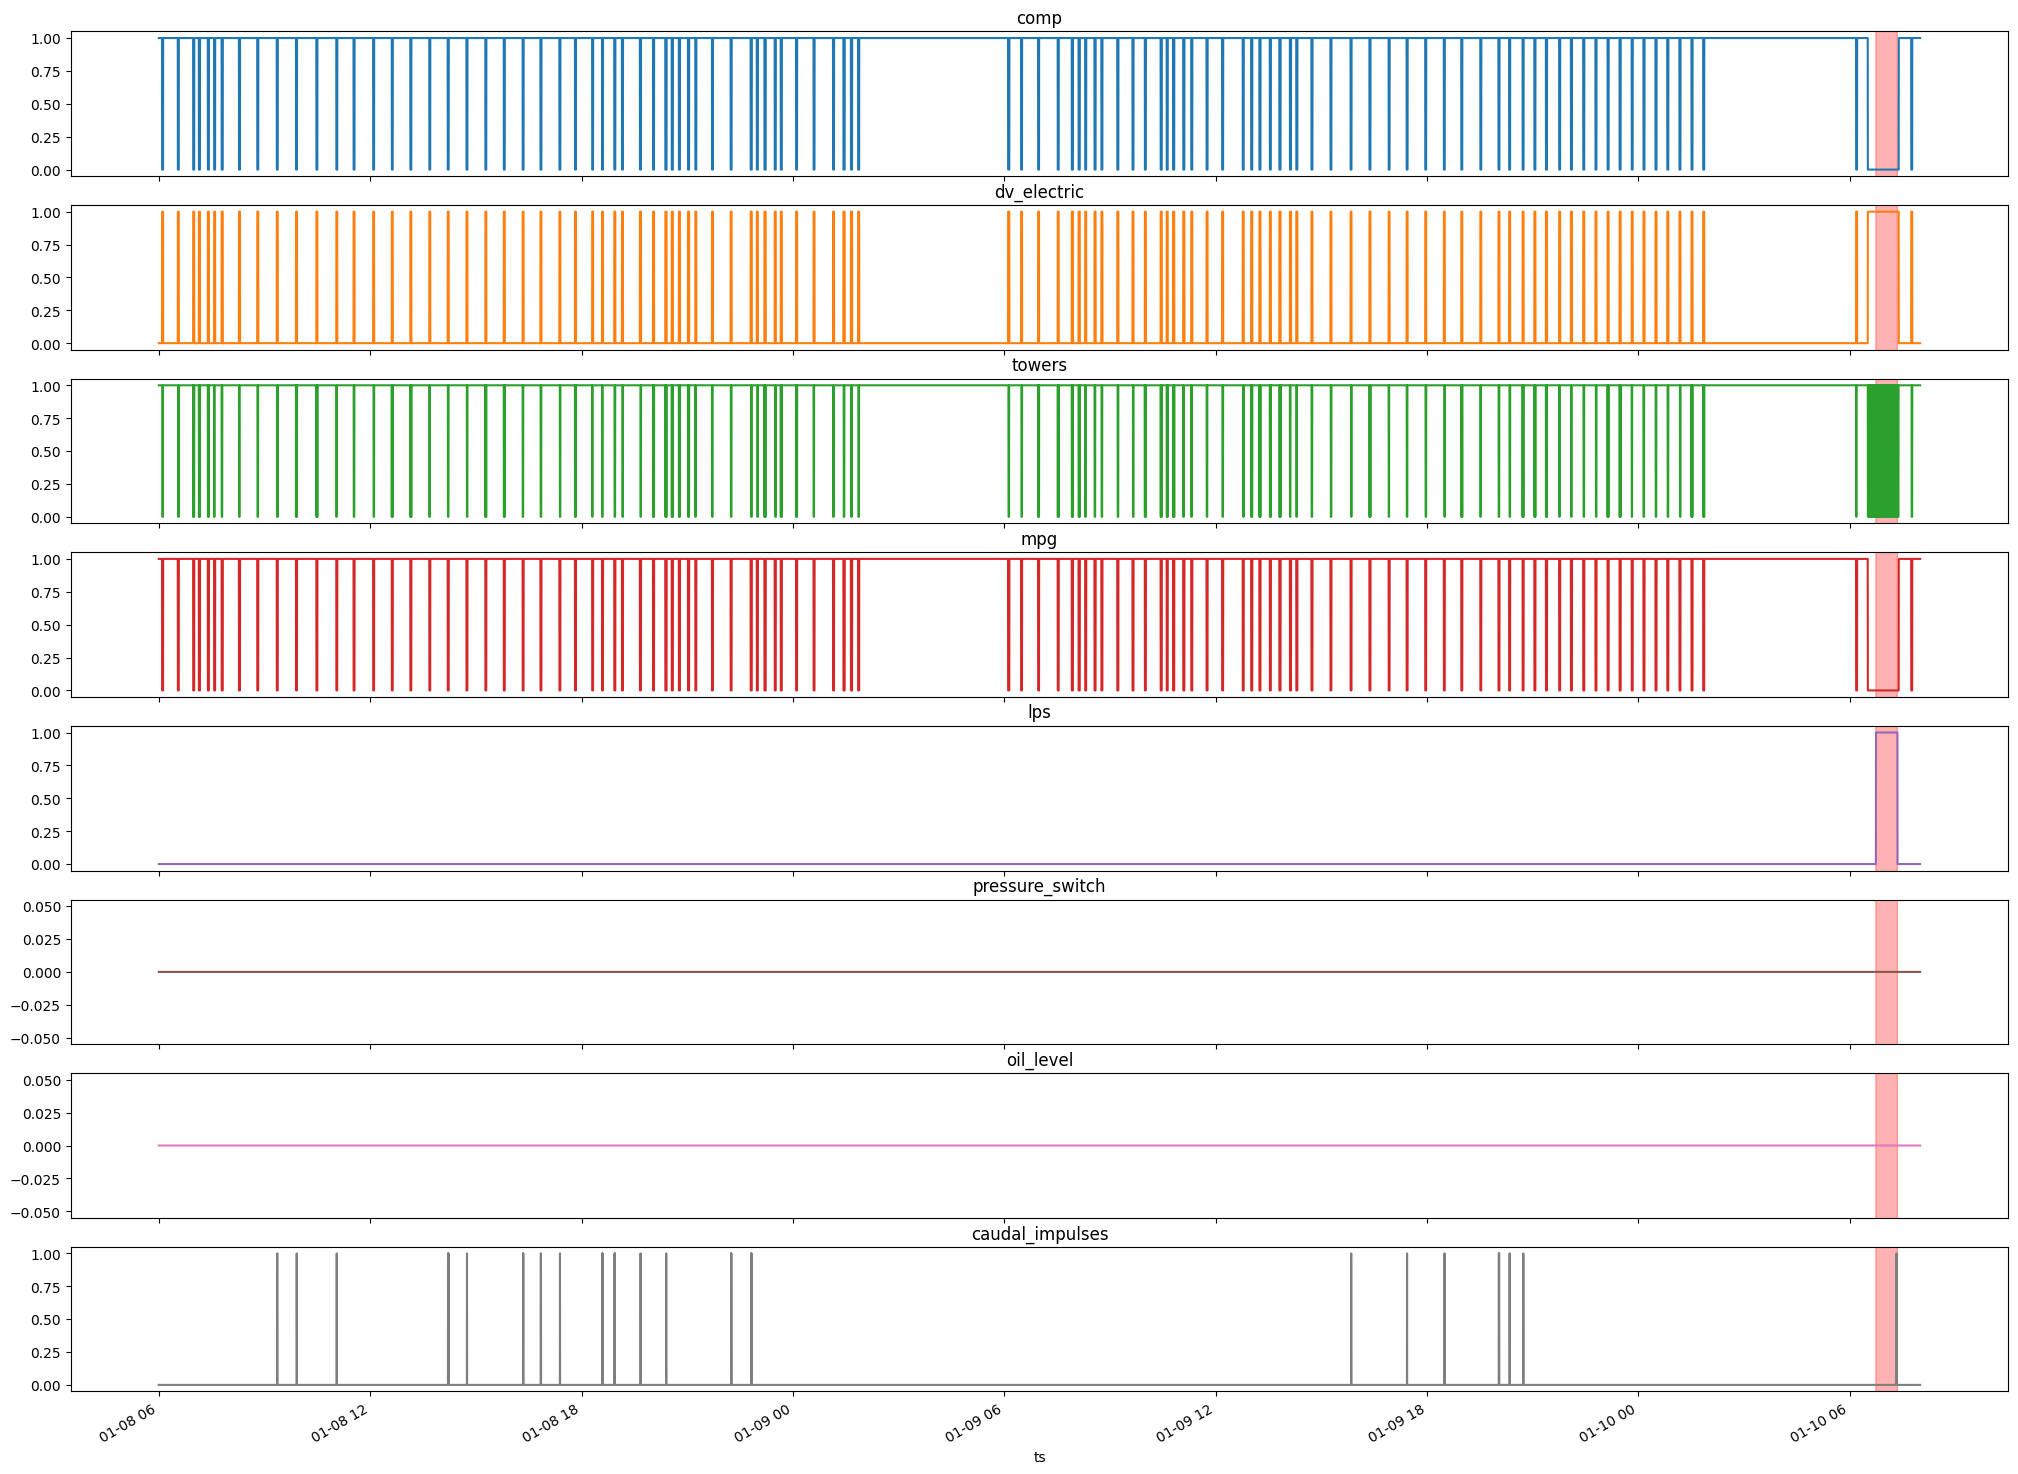

In [97]:
axes = df.plot(
    x='ts',
    y=digital_cols,
    subplots=True,
    figsize=(25, 20),
    legend=False
)

for ax, col in zip(axes, digital_cols):
    ax.set_title(col)
    ax.autoscale(False)
    ax.fill_between(
        df['ts'].to_list(),
        100,
        -100,
        where=(df['lps'] == 1).to_list(),
        color='red',
        alpha=0.3
    )

(288004, 3)


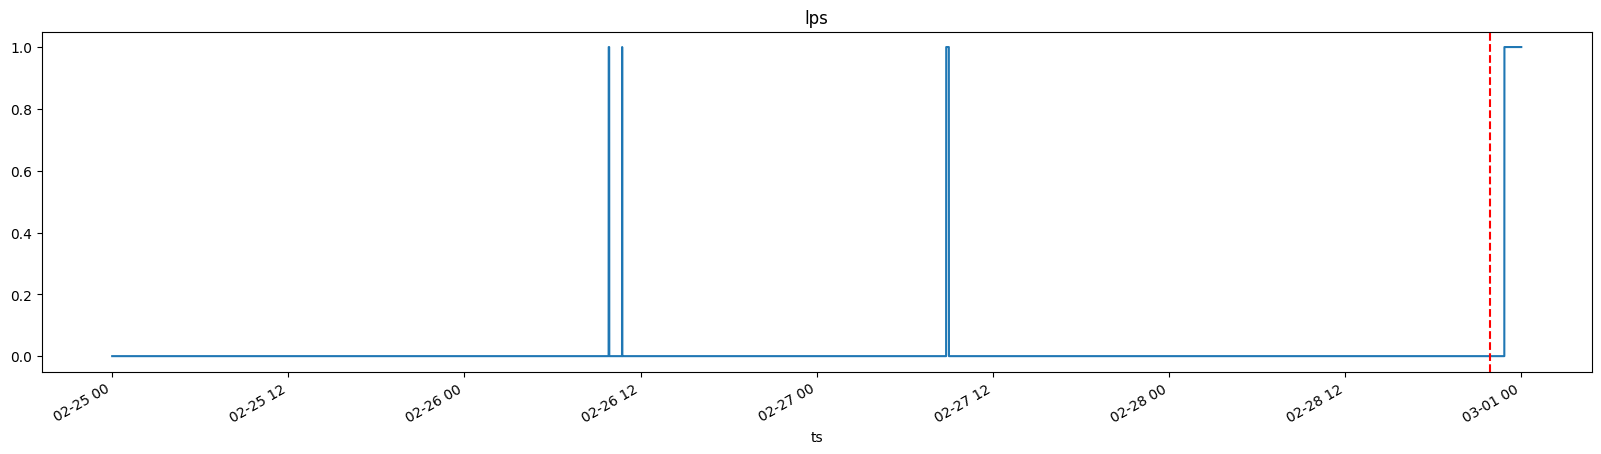

In [100]:
# LPS + Failure 1
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select ts, lps, failure_id
        from train_data 
        where '2022-02-25 00:00:00' <= ts and ts < '2022-03-01 00:00:00'
        order by ts asc
    """.format(columns=','.join(analog_cols)), con=con, parse_dates=['ts'])

print(df.shape)

ax = df.plot(
    x='ts',
    y='lps',
    subplots=True,
    figsize=(20, 5),
    legend=False
)
plt.title('lps');
plt.axvline(x=pd.Timestamp('2022-02-28 21:53:00'), color='red', linestyle='--');

(271830, 3)


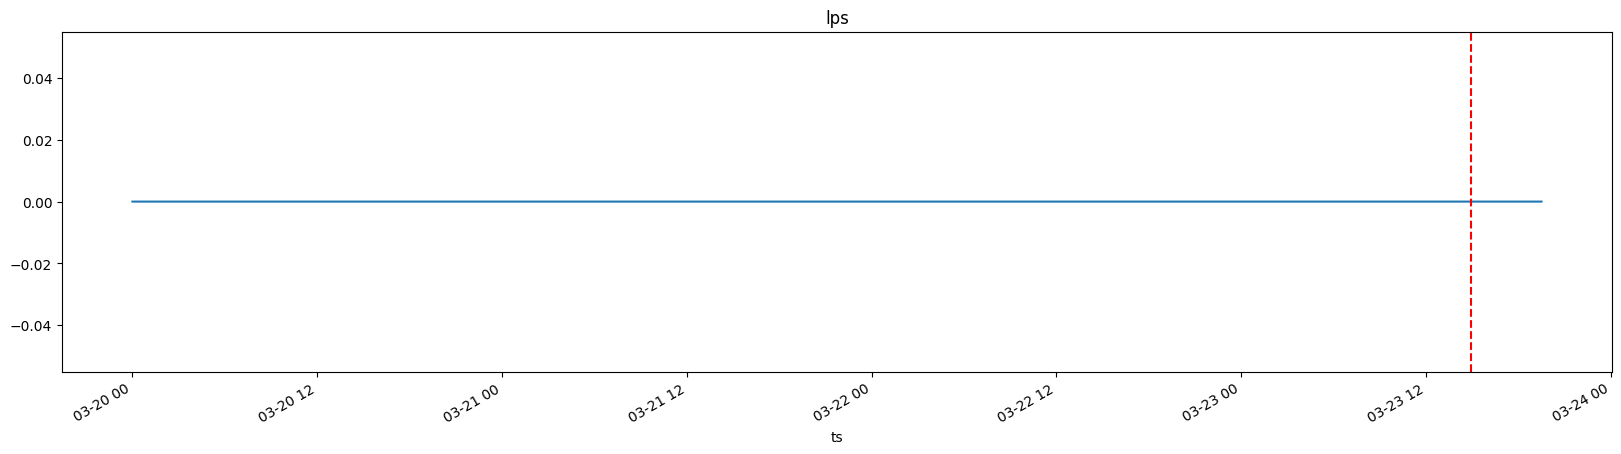

In [101]:
# LPS + Failure 2
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select ts, lps, failure_id
        from train_data 
        where '2022-03-20 00:00:00' <= ts and ts < '2022-03-24 00:00:00'
        order by ts asc
    """.format(columns=','.join(analog_cols)), con=con, parse_dates=['ts'])

print(df.shape)

ax = df.plot(
    x='ts',
    y='lps',
    subplots=True,
    figsize=(20, 5),
    legend=False
)
plt.title('lps');
plt.axvline(x=pd.Timestamp('2022-03-23 14:54:00'), color='red', linestyle='--');

(1008014, 3)


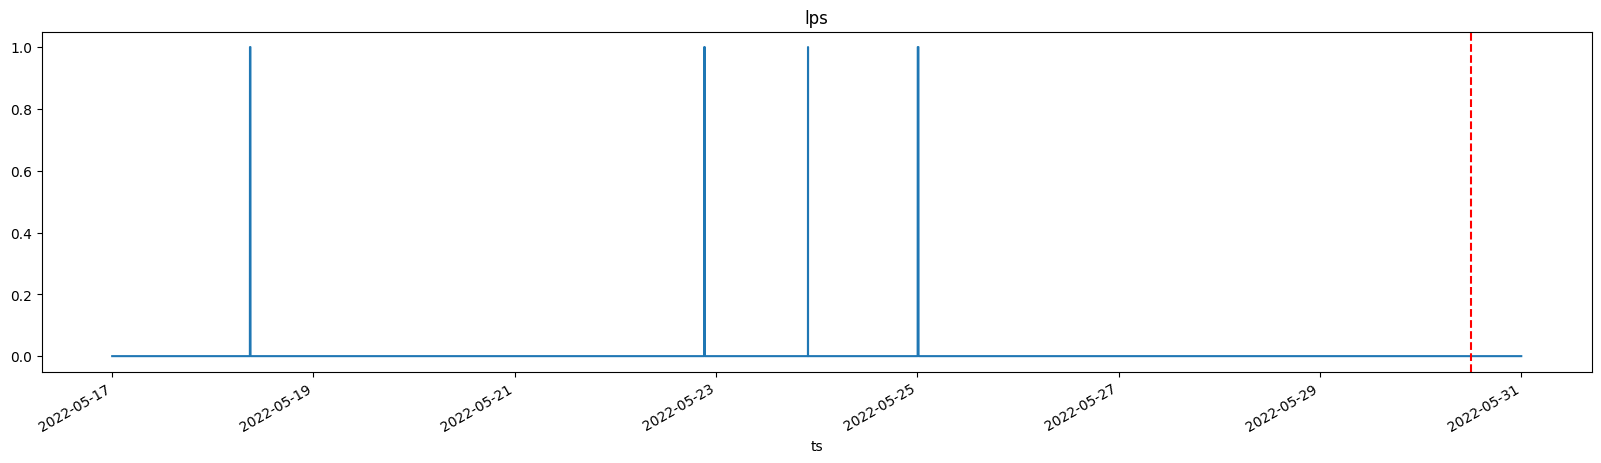

In [102]:
# LPS + Failure 3
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select ts, lps, failure_id
        from train_data 
        where '2022-05-17 00:00:00' <= ts and ts < '2022-05-31 00:00:00'
        order by ts asc
    """.format(columns=','.join(analog_cols)), con=con, parse_dates=['ts'])

print(df.shape)

ax = df.plot(
    x='ts',
    y='lps',
    subplots=True,
    figsize=(20, 5),
    legend=False
)
plt.title('lps');
plt.axvline(x=pd.Timestamp('2022-05-30 12:00:00'), color='red', linestyle='--');

### Correlation Matrix

In [ ]:
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql('select * from train_data', con=con, parse_dates=['ts'])

In [6]:
df.columns

Index(['ts', 'tp2', 'tp3', 'h1', 'dv_pressure', 'reservoirs',
       'oil_temperature', 'flowmeter', 'motor_current', 'comp', 'dv_electric',
       'towers', 'mpg', 'lps', 'pressure_switch', 'oil_level',
       'caudal_impulses', 'gps_long', 'gps_lat', 'gps_speed', 'gps_quality',
       'failure_id', 'day_id', 'pseudo_label'],
      dtype='object')

In [3]:
cols = [
    'tp2',
    'tp3',
    'h1',
    'dv_pressure',
    'reservoirs',
    'oil_temperature',
    'flowmeter',
    'motor_current',
    'comp',
    'dv_electric',
    'towers',
    'mpg',
    'lps',
    # 'pressure_switch', # Not useful, 0 all the time
    'oil_level',
    'caudal_impulses',
    'failure_id',
    'pseudo_label'
]

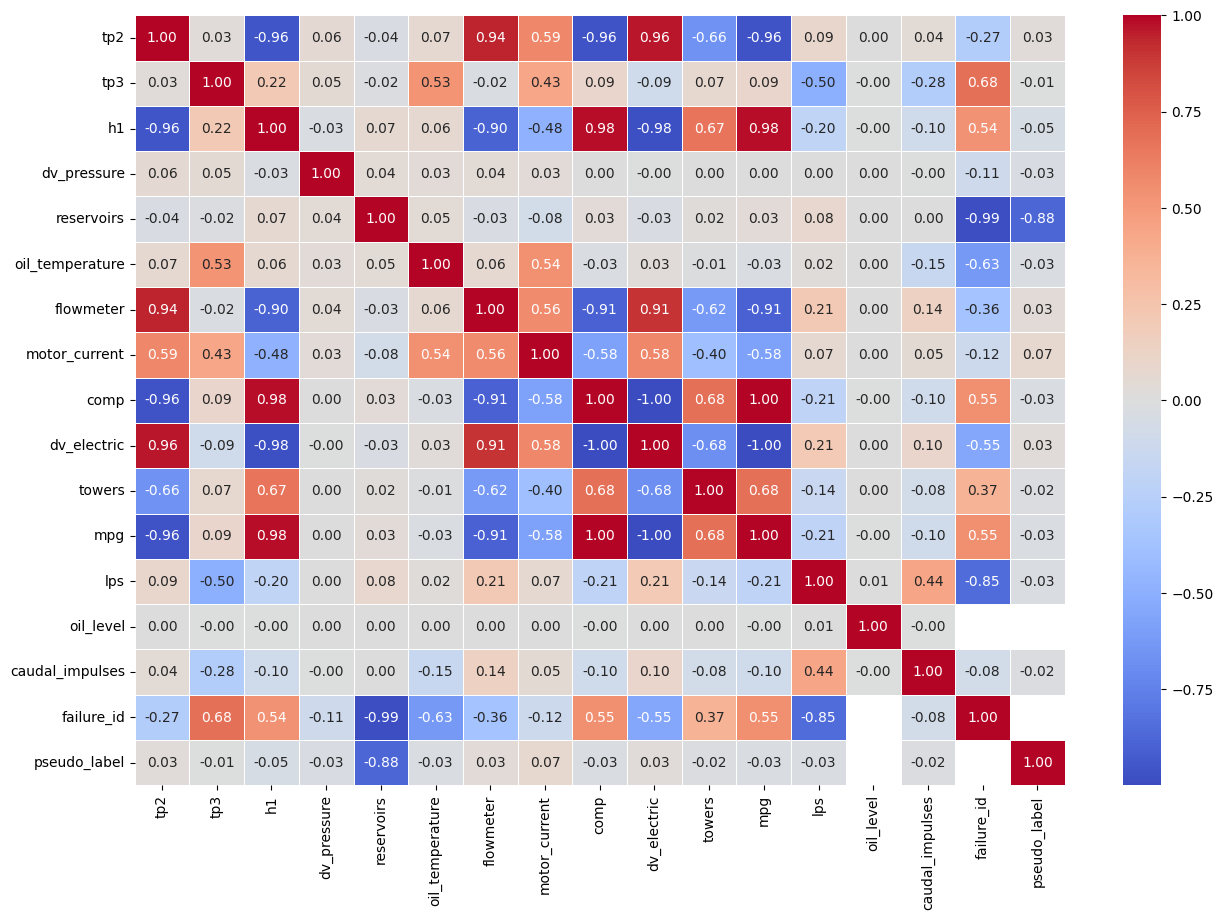

In [4]:
matrix = df.loc[:, cols].corr()
plt.figure(figsize = (15, 10))
ax = sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

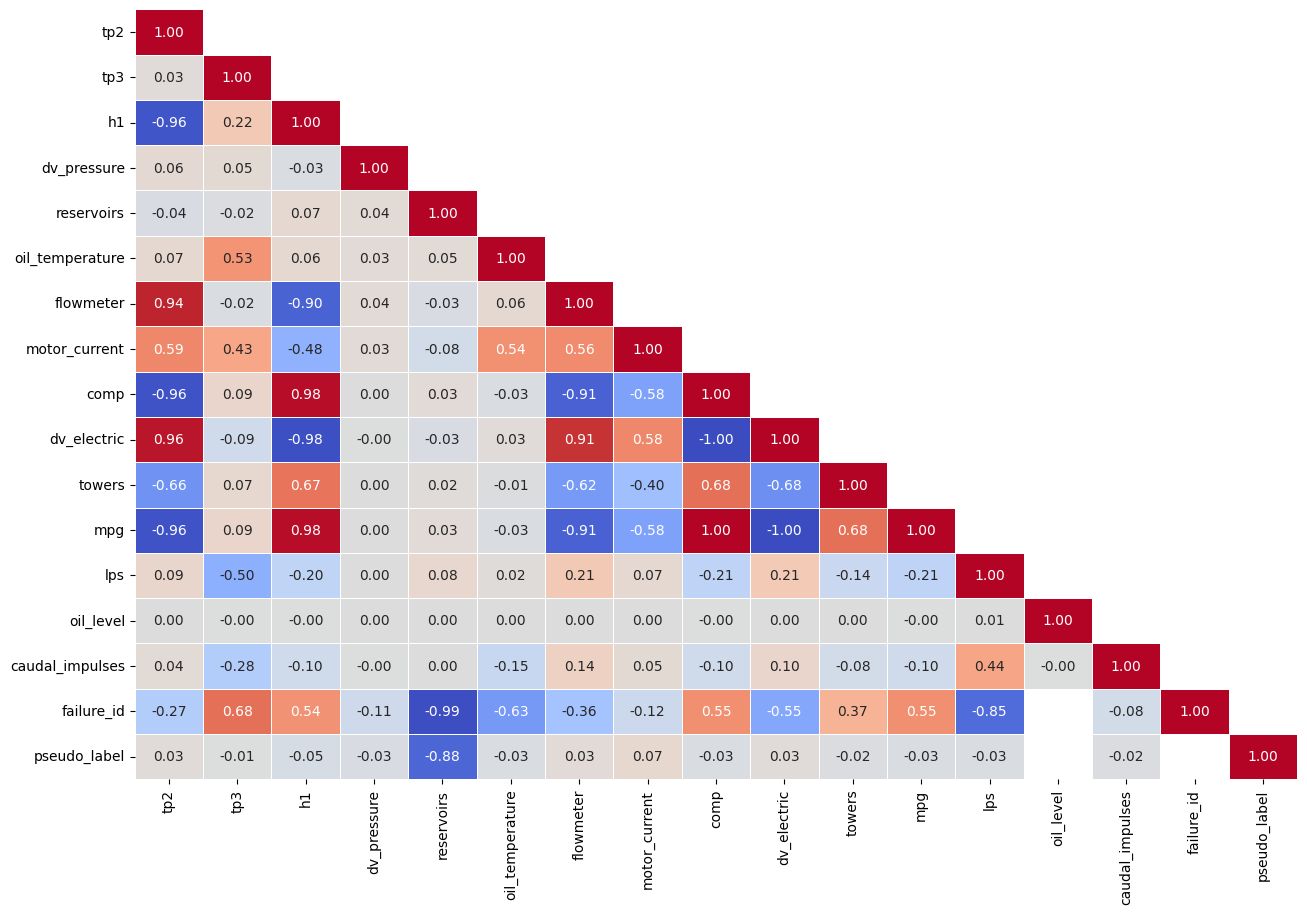

In [10]:
matrix = df.loc[:, cols].corr()
mask = np.triu(np.ones_like(matrix, dtype=bool), k=1)
plt.figure(figsize = (15, 10))
ax = sns.heatmap(matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=False)